# Online Local Adaptive Model - Notebook 3_2

* Prior Probability Shift is one of the common problems encountered in Machine Learning algortihms.   
* There are some approaches for dealing with this problem in a 'static' scenario. But there are situations in which we need a model which deals with secvential data as input (e.g. a server which gets input from different users, with different data distributions).   
* In this project, we try to build a model which self adapts its predictions based on the local label distribution. 

### About notebook 3_2

In this notebook we address the problem of Prior Probability Shift. In Experiment 2, a modified LeNet5 model is trained in order to make it able to adapt to local distribution.

## Notebook setup and data preparation

### Notebook setup

In [2]:
from IPython.core.display import display, HTML
from IPython.display import Image
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2

### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import deque
import os
import pickle
from training_plotter import TrainingPlotter
from dataset import MNISTDataset
from utils import Utils
from lenet5 import Lenet5
from lenet5_with_distr import Lenet5WithDistr
import PIL.Image

# numpy print options
np.set_printoptions(linewidth = 150)
np.set_printoptions(edgeitems = 10)
# np.set_printoptions(precision=3)
# pd.set_option('display.precision', 3)

### Set seed

In [4]:
# create a random generator using a constant seed in order to reproduce results
seed = 112358
nprg = np.random.RandomState(seed)

### Import MNIST dataset

In [5]:
MNIST_TRAIN_IMAGES_FILEPATH = 'MNIST_dataset/train-images.idx3-ubyte'
MNIST_TRAIN_LABELS_FILEPATH = 'MNIST_dataset/train-labels.idx1-ubyte'
MNIST_TEST_IMAGES_FILEPATH = 'MNIST_dataset/t10k-images.idx3-ubyte'
MNIST_TEST_LABELS_FILEPATH = 'MNIST_dataset/t10k-labels.idx1-ubyte'

mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)


### Use a subset of  MNIST dataset

In [5]:
mnist_subset = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
SUBSET_SIZE = 10000
mnist_subset.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
print(np.sum(mnist_subset.train.images))
print(mnist_subset.summary)

1032086.8716514301

        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        


---
### - build a list with distributions used in previously trained models
---

Restoring model 0 from Lenet5_with_imposed_distr_0_5000samples_2018_05_07---11_45.model.ckpt
The restored model 0 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]



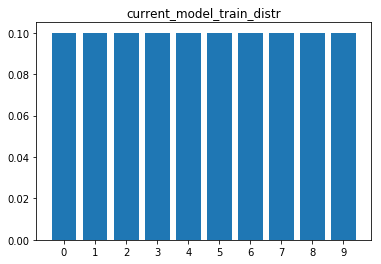

Restoring model 1 from Lenet5_with_imposed_distr_1_5000samples_2018_05_07---11_48.model.ckpt
The restored model 1 was trained using distr: [0.016  0.0322 0.0644 0.129  0.2588 0.258  0.129  0.0644 0.0322 0.016 ]



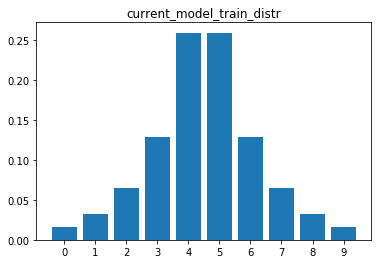

Restoring model 2 from Lenet5_with_imposed_distr_2_5000samples_2018_05_07---11_52.model.ckpt
The restored model 2 was trained using distr: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]



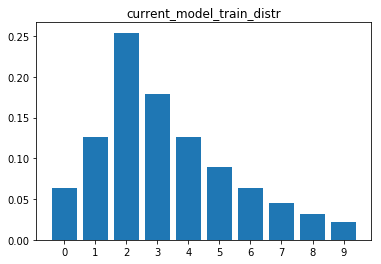

Restoring model 3 from Lenet5_with_imposed_distr_3_5000samples_2018_05_07---11_55.model.ckpt
The restored model 3 was trained using distr: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]



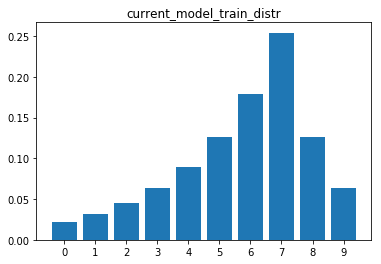

Restoring model 4 from Lenet5_with_imposed_distr_4_5000samples_2018_05_07---11_58.model.ckpt
The restored model 4 was trained using distr: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]



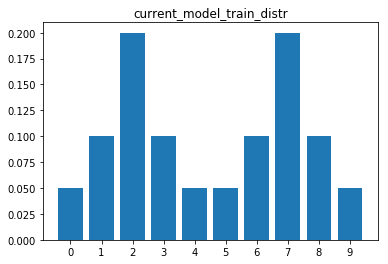

Restoring model 5 from Lenet5_with_imposed_distr_5_5000samples_2018_05_07---12_01.model.ckpt
The restored model 5 was trained using distr: [0.1368 0.194  0.0968 0.0484 0.0242 0.0242 0.0484 0.0968 0.1936 0.1368]



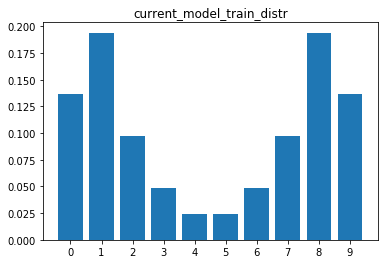

Restoring model 6 from Lenet5_with_imposed_distr_6_5000samples_2018_05_07---12_05.model.ckpt
The restored model 6 was trained using distr: [0.0142 0.02   0.028  0.0392 0.055  0.077  0.1078 0.1508 0.2112 0.2968]



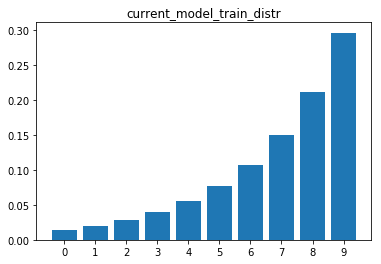

Restoring model 7 from Lenet5_with_imposed_distr_7_5000samples_2018_05_07---12_08.model.ckpt
The restored model 7 was trained using distr: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]



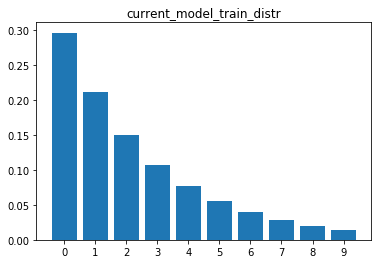

In [6]:
# WORK_DIR = "./results/PriorProbabilityShift_experiment_5_10000samples/"
WORK_DIR = "./results/PriorProbabilityShift_experiment_5_5000samples/"
ckpt_file_list = Utils.get_all_files_from_dir_ending_with(WORK_DIR, "ckpt.meta", without_file_extension=True)
perf_dict = {'idx_model':[], 'idx_distr':[], 'test_loss':[], 'test_acc':[], 'total_predict':[], 'total_actual':[], 'train_distr':[], 'test_distr':[], 'ckpt_file':[]}

# build a list with all ditributions considered in training phase
distrs_used_for_training = []
for idx_model, ckpt_file in enumerate(ckpt_file_list):
    print('Restoring model {} from {}'.format(idx_model, ckpt_file))
    temp_model = Lenet5(mnist_dataset=mnist_ds, display_summary=False)
    temp_model.restore_session(ckpt_dir=WORK_DIR, ckpt_filename=ckpt_file)
    current_model_train_distr = temp_model.session.run(temp_model.train_distr)
    distrs_used_for_training.append(current_model_train_distr)   
    print('The restored model {} was trained using distr: {}\n'.format(idx_model, current_model_train_distr))
    plt.bar(range(0, 10), current_model_train_distr)
    plt.xticks(range(0, 10))
    plt.title('current_model_train_distr')
    plt.show()

---
# Experiment 2. Try to adapt the standard version of LeNet5 in order to make the model able to adapt to local label distribution

---
### Section 1
Train 2 models:
- first one without using the distribution as input
- second one using the distribution as input but without explicitly build batches with respect to a distribution (i.e. just append the distribution of current batch before the specified fully connected layers)

Check if appending the distribution has an influence on the accuracy.
***

2018-05-02 00:48:05,284 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
2018-05-02 00:48:05,522 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-02 00:48:06,975 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 00:48:51,734 - EPOCH 1 --- Training: loss = 0.837, acc = 0.722; Validation: loss = 0.162, acc = 0.952; num_examples_used = 53760
2018-05-02 00:49:34,778 - EPOCH 2 --- Training: loss = 0.249, acc = 0.928; Validation: loss = 0.089, acc =

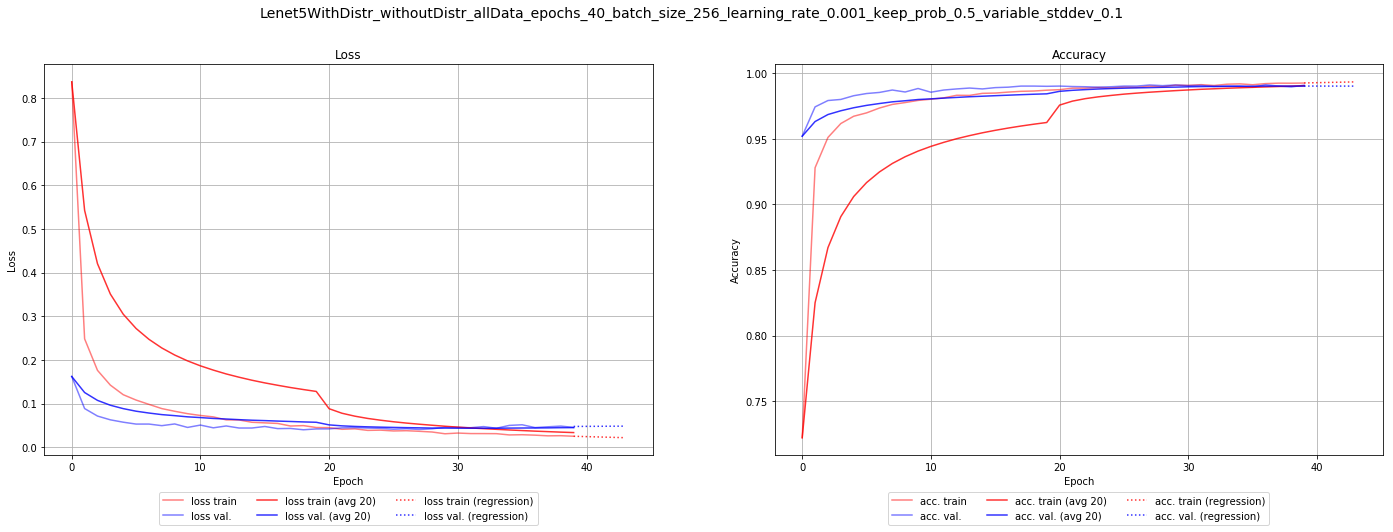

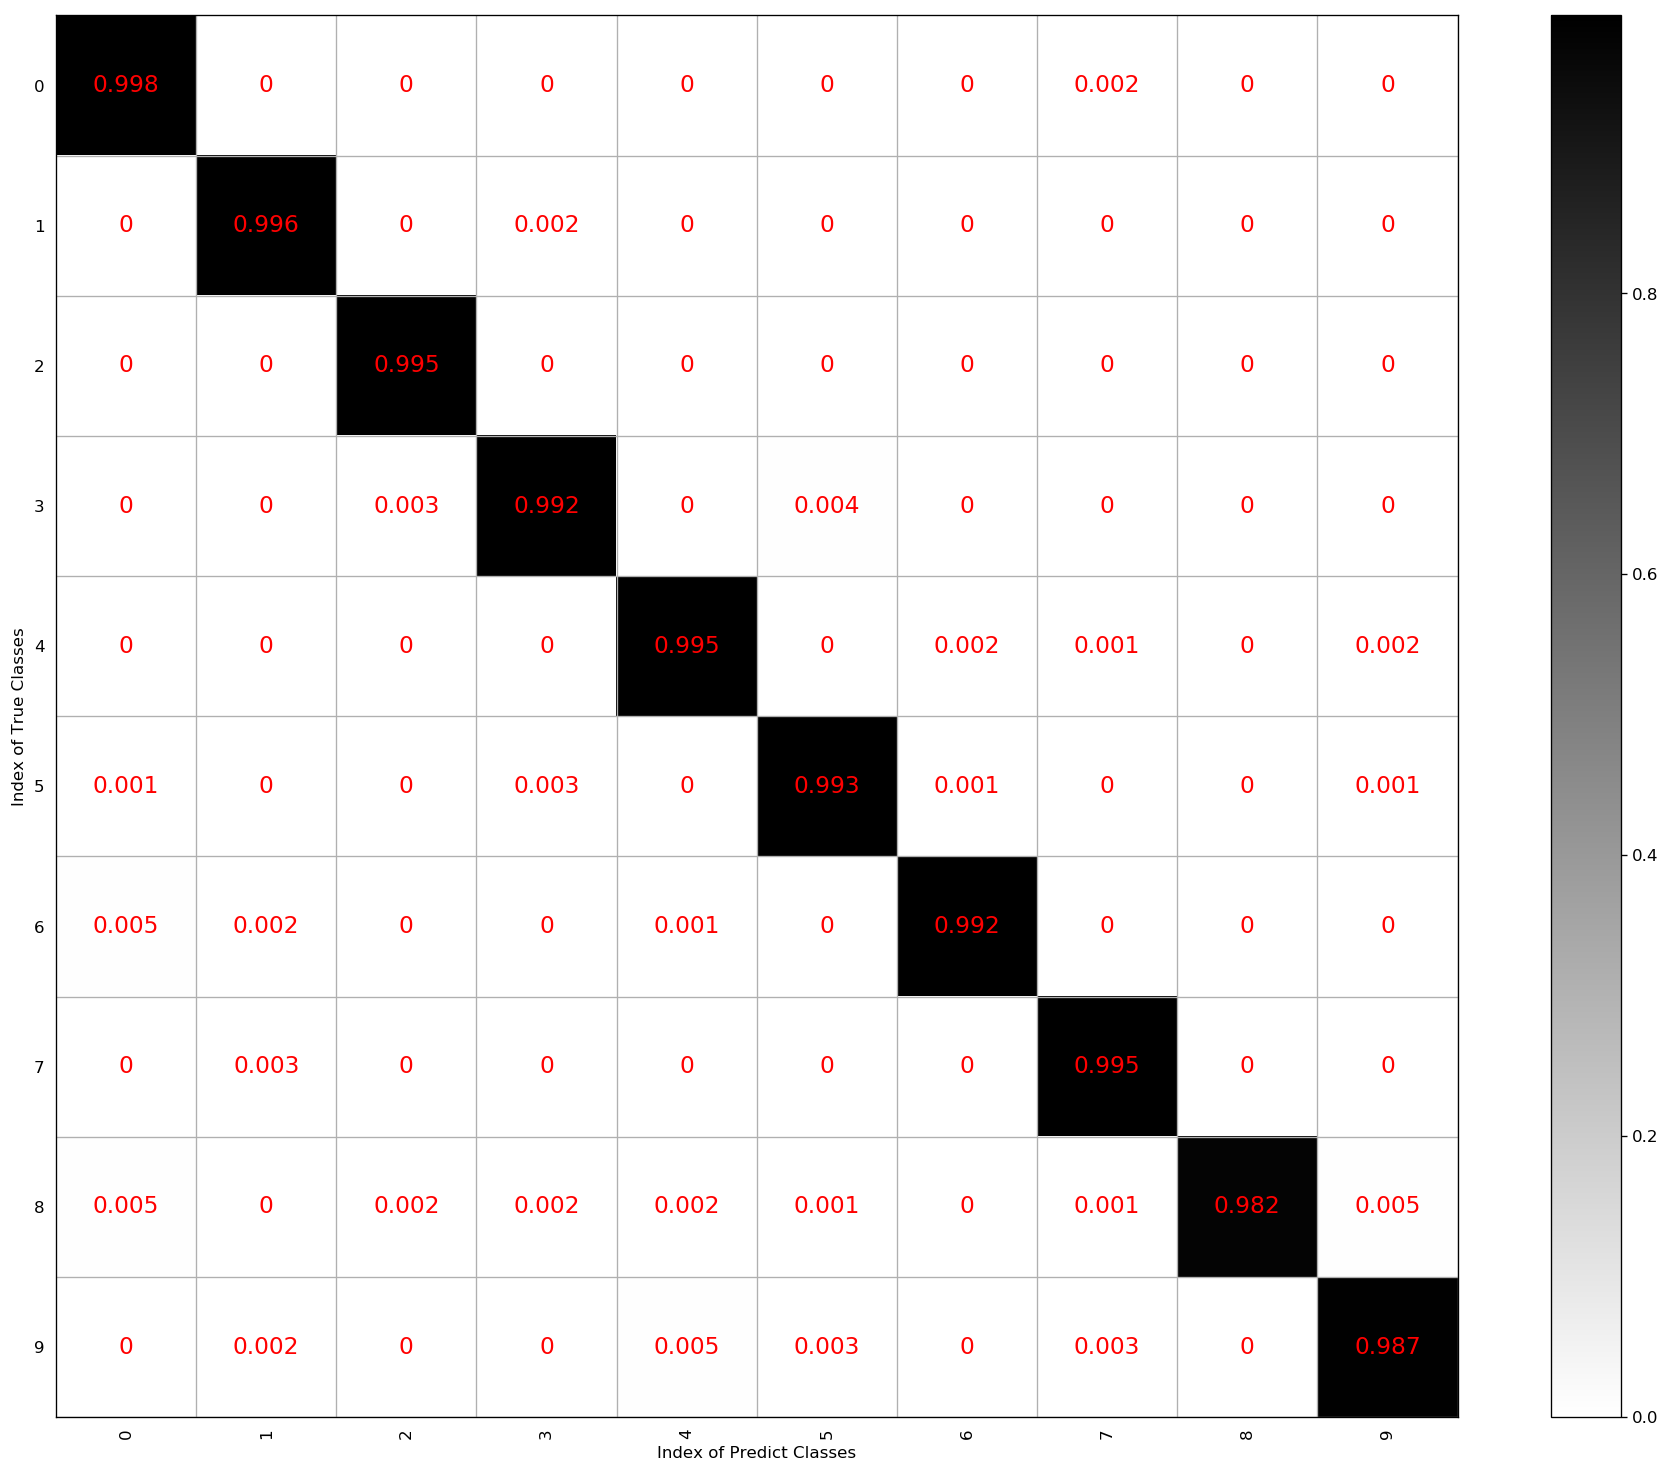

In [39]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withoutDistr_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, False])
lenet5_model_with_distr.train()

2018-05-02 01:15:27,891 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
F3
2018-05-02 01:15:28,054 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 94]
	[None, 10]
2018-05-02 01:15:29,409 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 01:16:08,730 - EPOCH 1 --- Training: loss = 0.899, acc = 0.700; Validation: loss = 0.169, acc = 0.951; num_examples_used = 53760
2018-05-02 01:16:47,958 - EPOCH 2 --- Training: loss = 0.268, acc = 0.923; Validation: loss = 0.099, ac

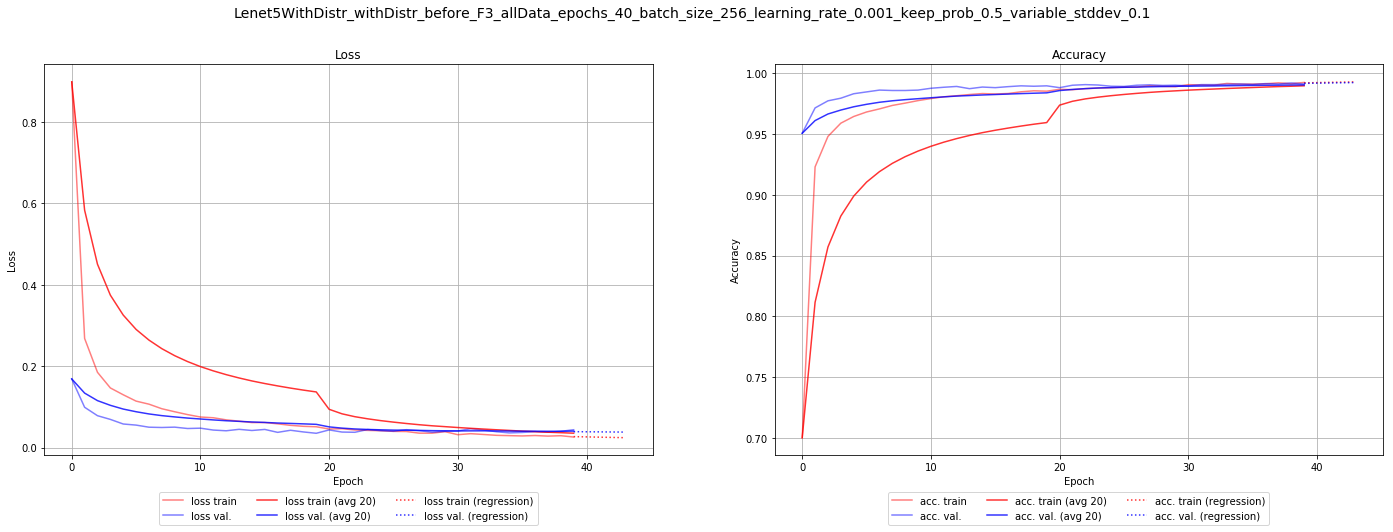

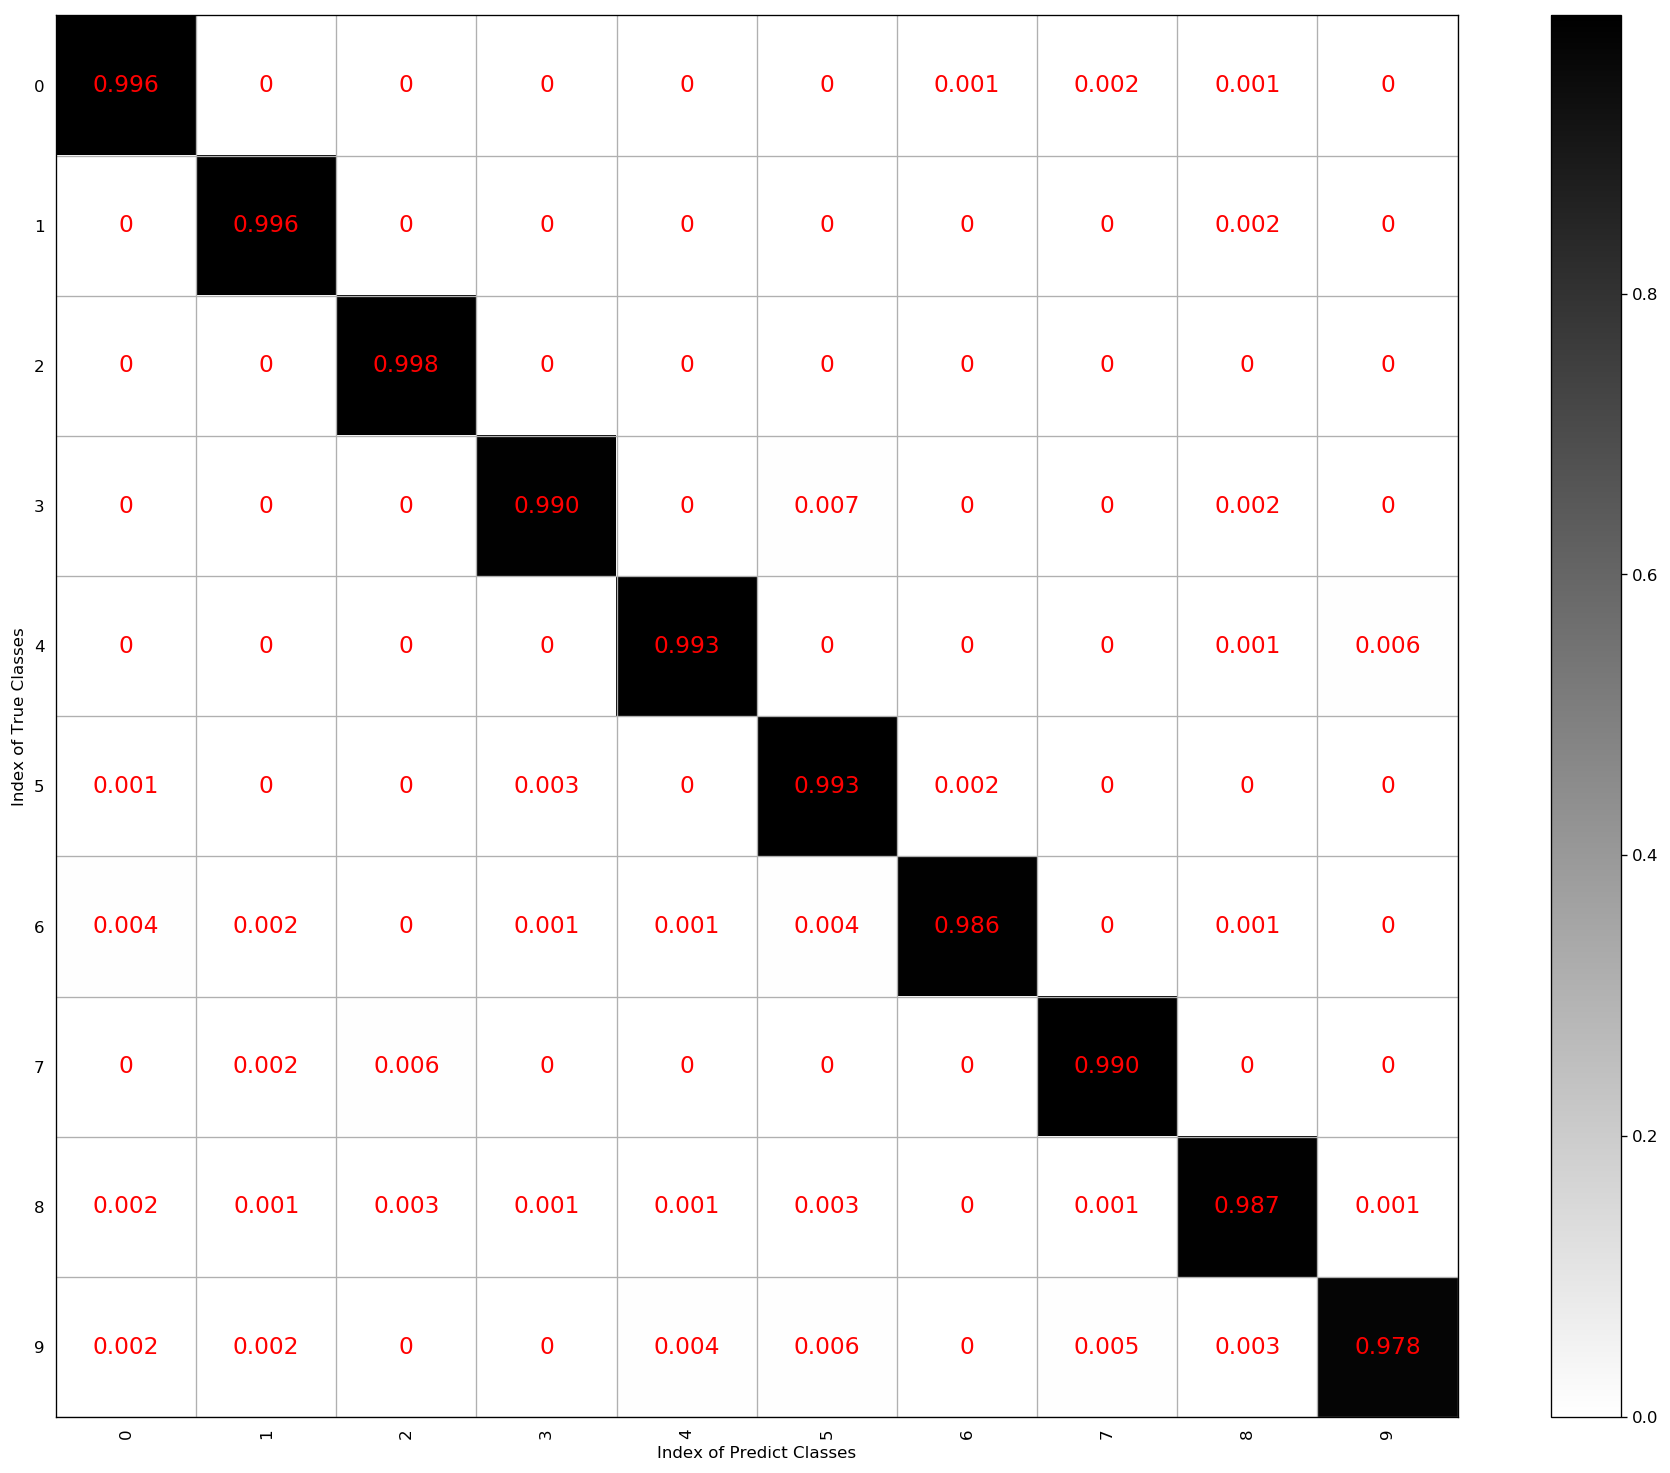

In [40]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_before_F3_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, True])
lenet5_model_with_distr.train()

2018-05-07 07:57:36,447 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
F1
F2
F3
2018-05-07 07:57:36,663 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 130]
	[None, 94]
	[None, 10]
2018-05-07 07:57:38,067 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-07 07:58:20,189 - EPOCH 1 --- Training: loss = 0.848, acc = 0.720; Validation: loss = 0.159, acc = 0.952; num_examples_used = 53760
2018-05-07 07:59:02,090 - EPOCH 2 --- Training: loss = 0.269, acc = 0.923; Validation: loss = 0.1

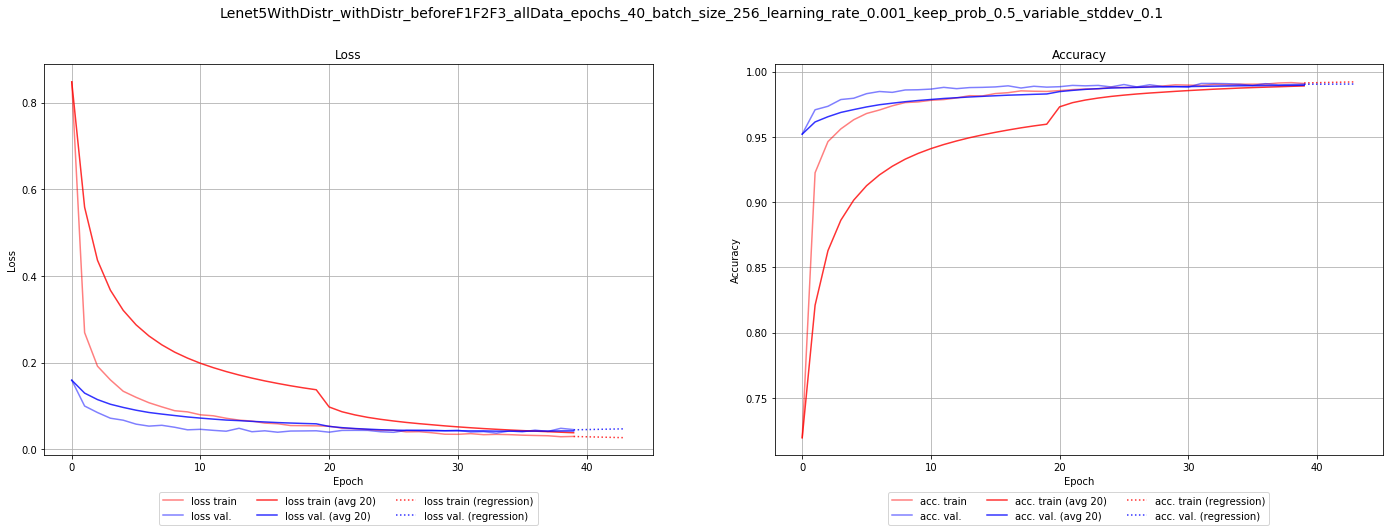

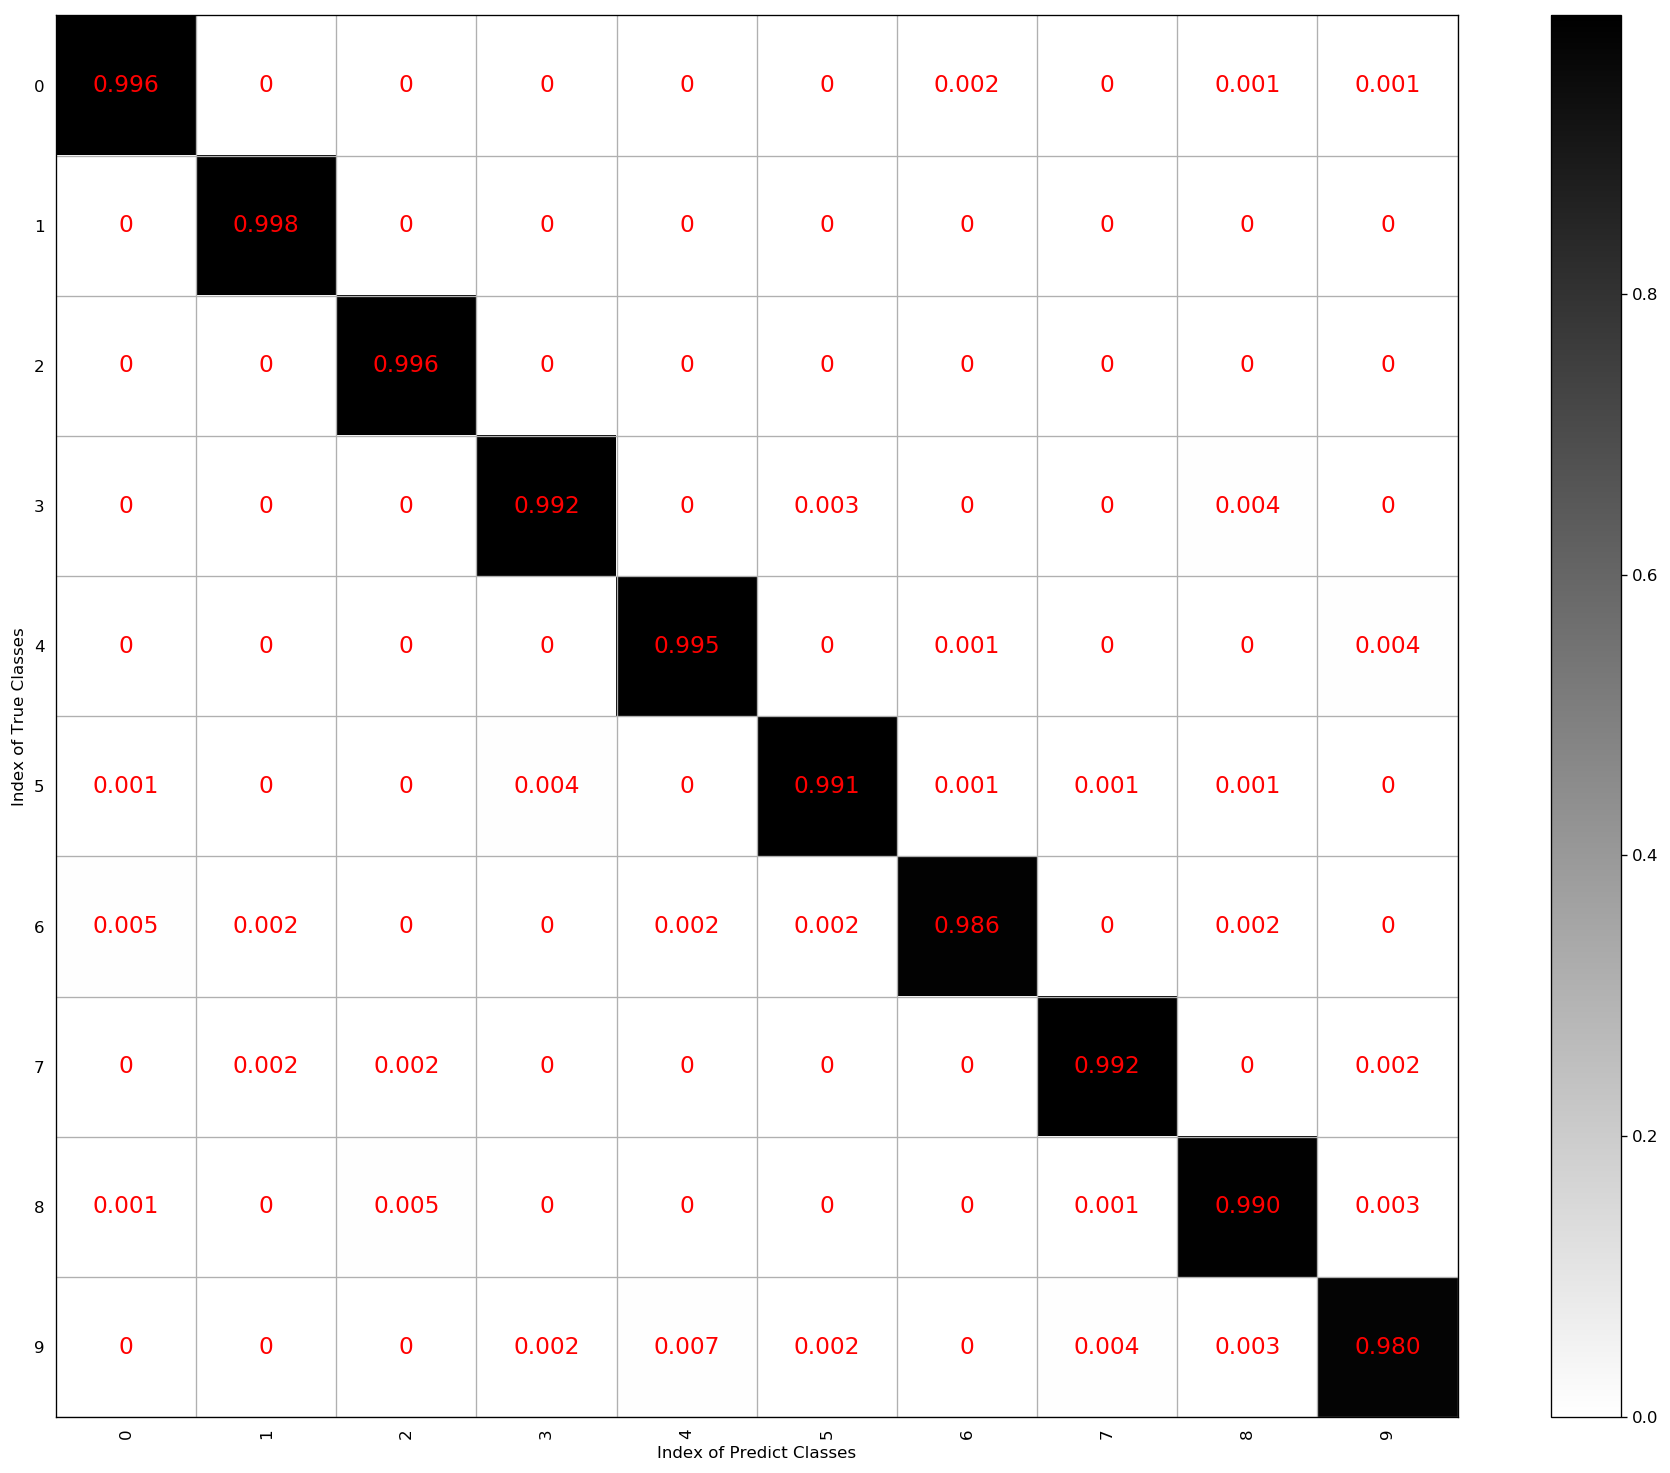

In [8]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeF1F2F3_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, True, True])
lenet5_model_with_distr.train()

2018-05-02 02:08:28,062 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
F1
2018-05-02 02:08:28,334 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-02 02:08:29,460 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 02:09:08,541 - EPOCH 1 --- Training: loss = 0.835, acc = 0.723; Validation: loss = 0.163, acc = 0.950; num_examples_used = 53760
2018-05-02 02:09:49,041 - EPOCH 2 --- Training: loss = 0.266, acc = 0.924; Validation: loss = 0.100, ac

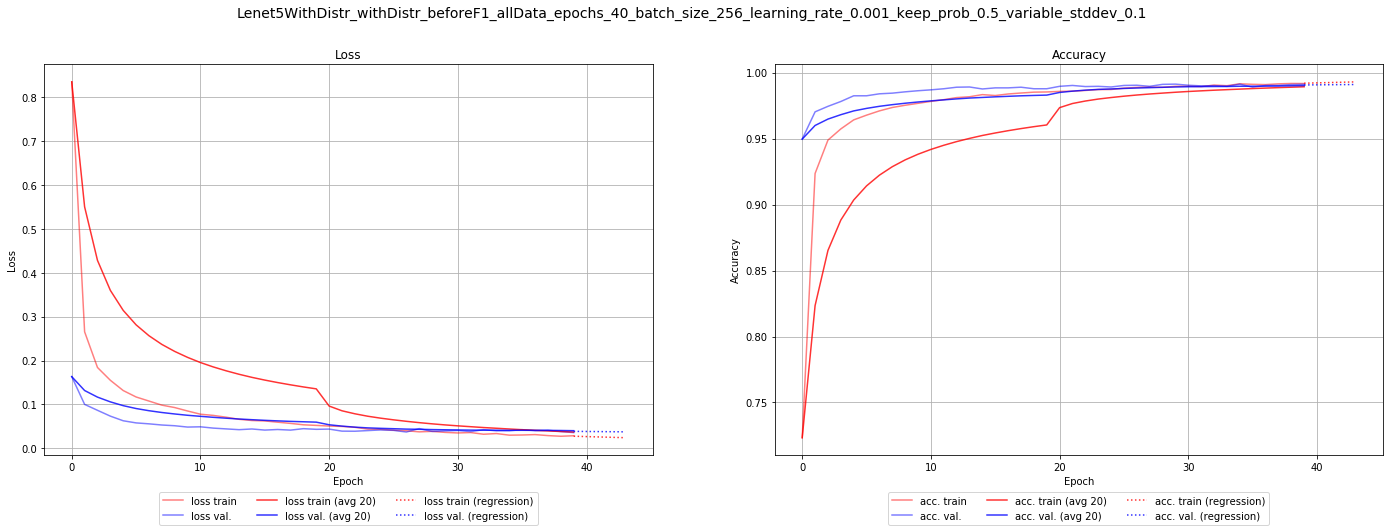

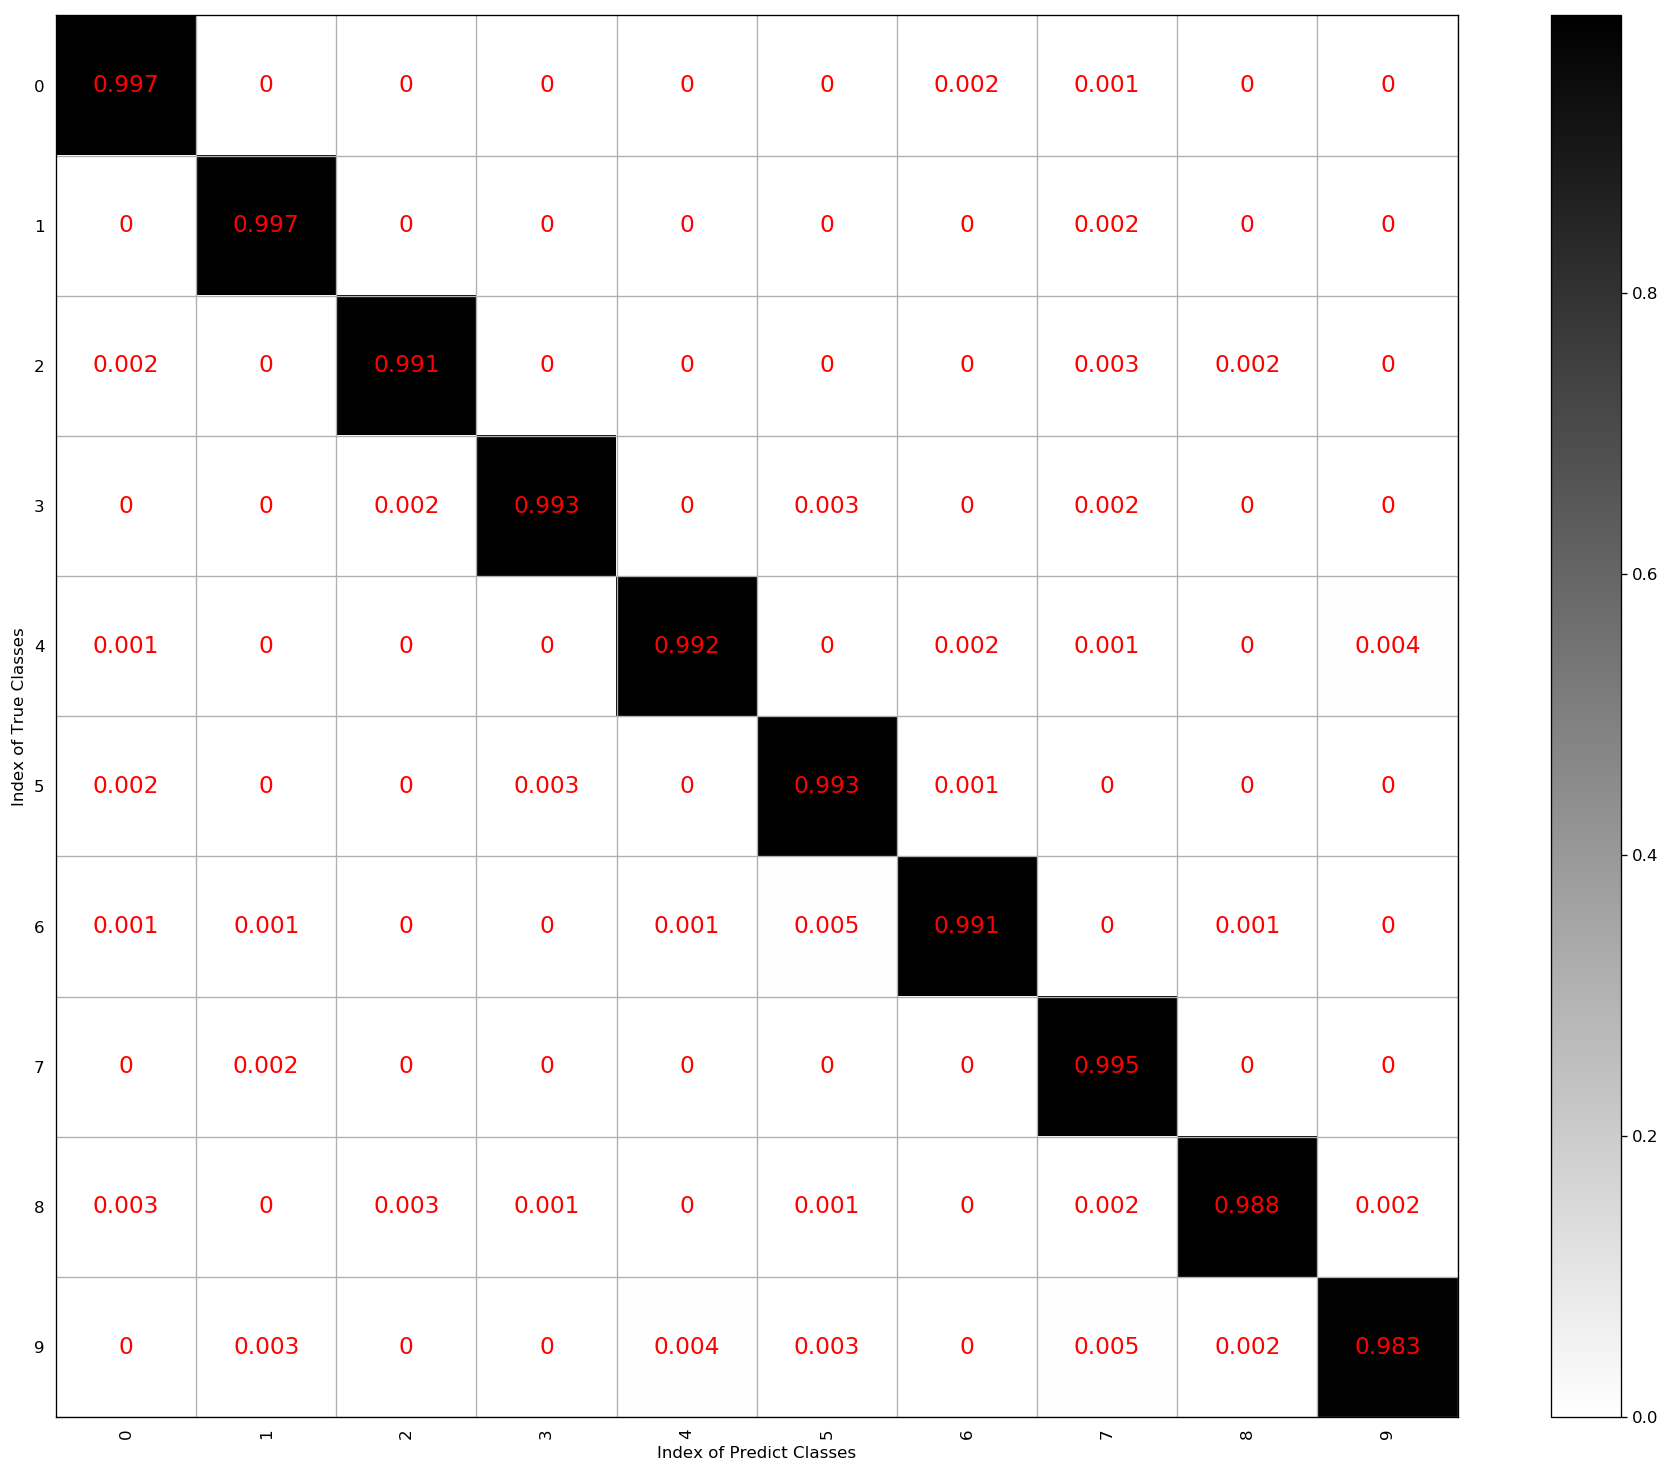

In [42]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeF1_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, False, False])
lenet5_model_with_distr.train()

---
### - train  the above models on only a subset of the original dataset
---

In [141]:
SUBSET_SIZE = 10000

2018-05-21 01:12:50,562 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
2018-05-21 01:12:50,827 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 01:12:53,031 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 01:13:02,491 - EPOCH 1 --- Training: loss = 2.070, acc = 0.269; Validation: loss = 1.245, acc = 0.710; num_examples_used = 9984
2018-05-21 01:13:12,886 - EPOCH 2 --- Training: loss = 1.129, acc = 0.619; Validation: loss = 0.475, acc = 0.877; num_examples_u

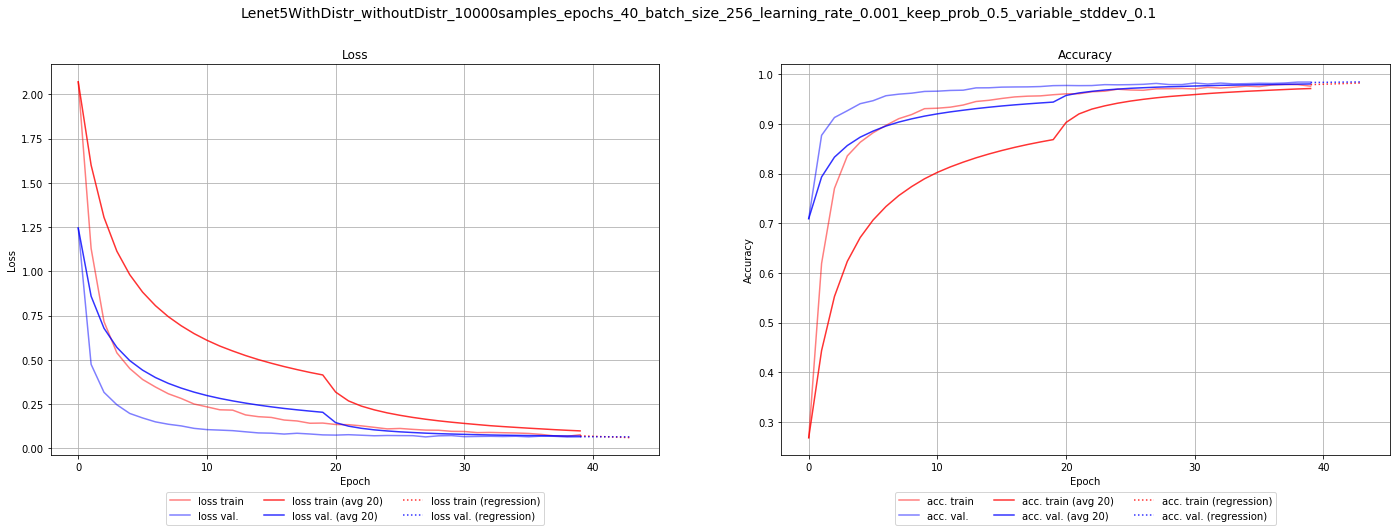

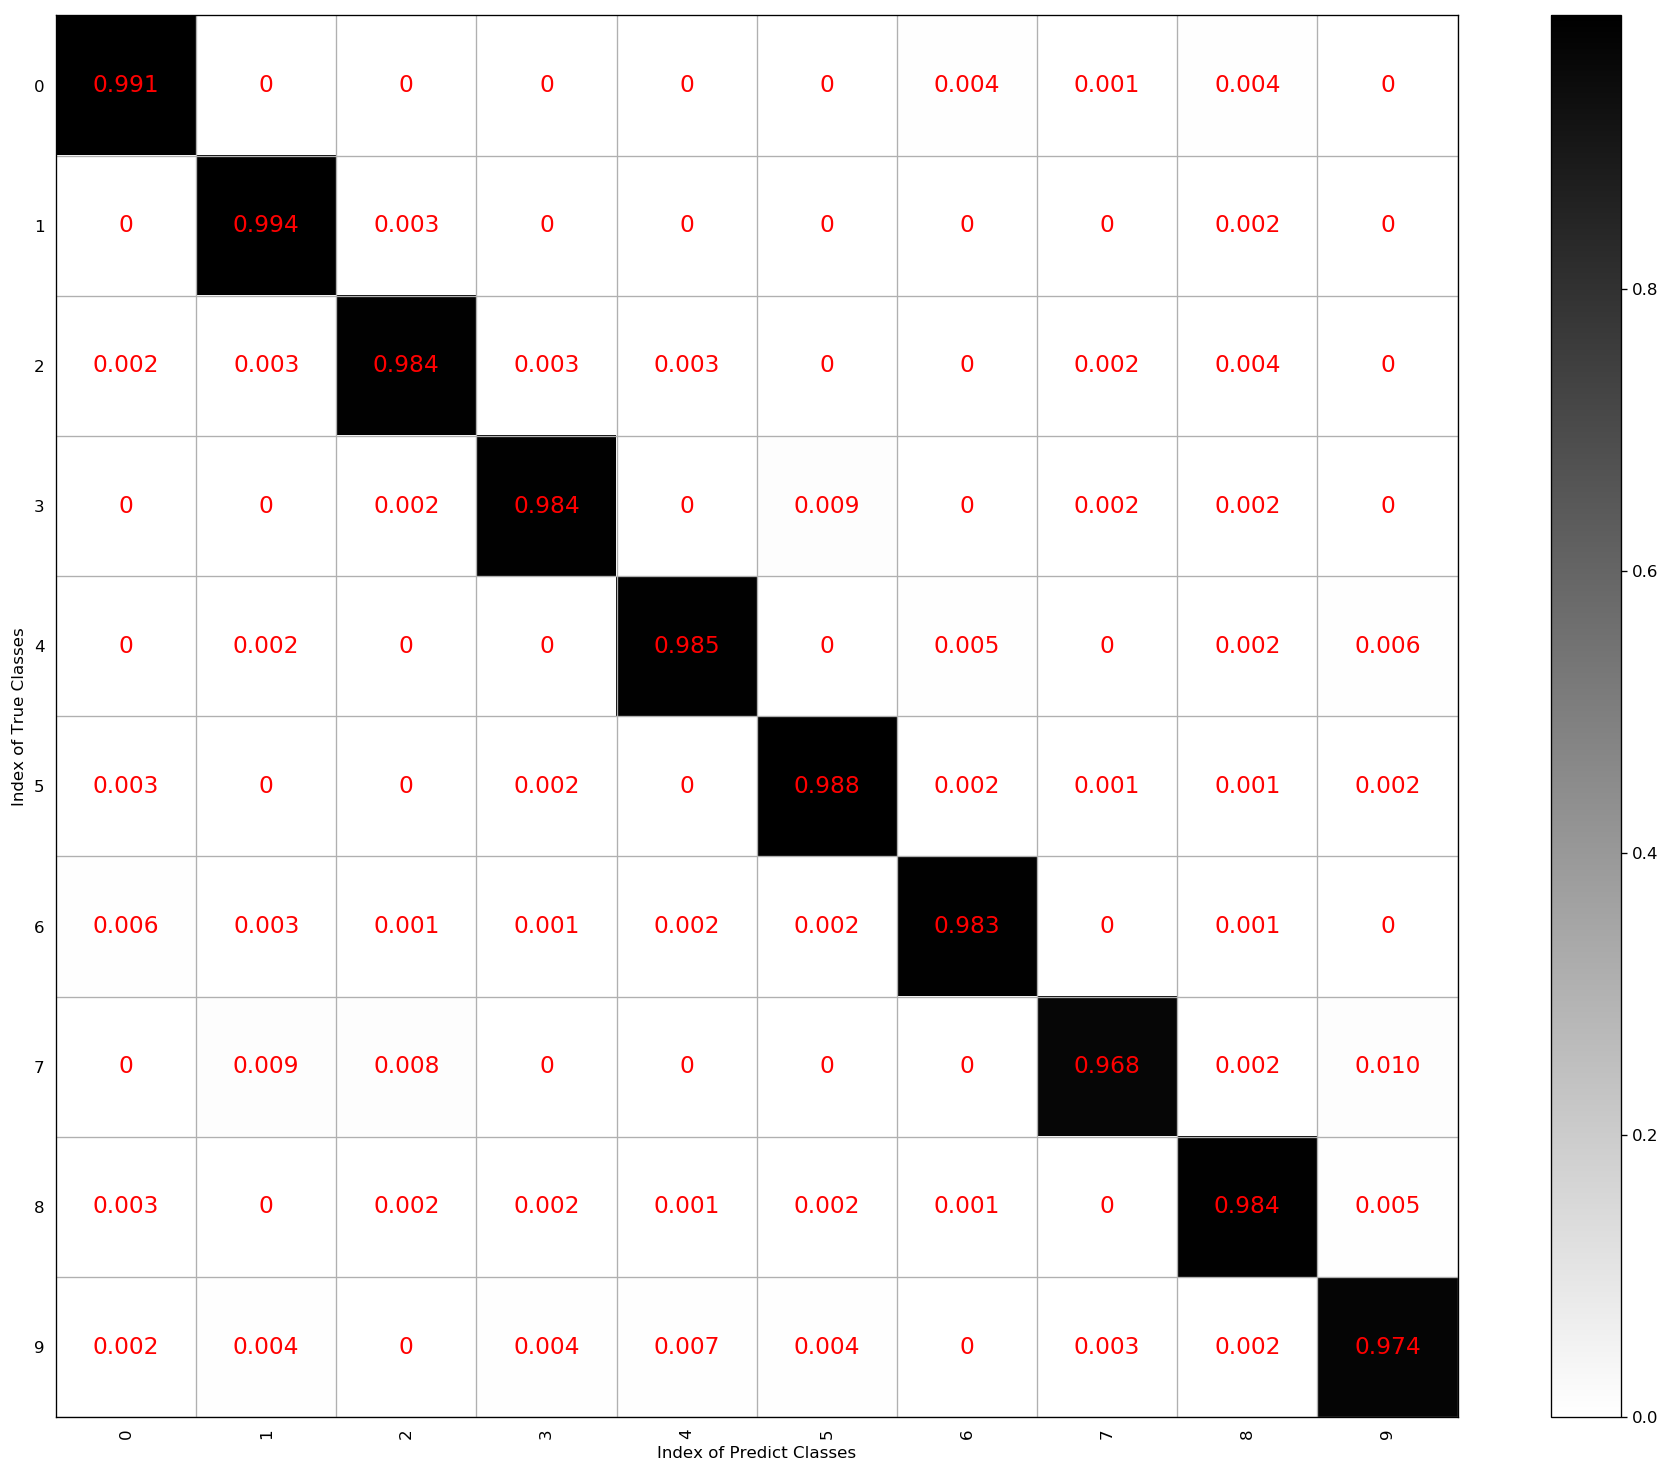

In [142]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withoutDistr_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, False])
lenet5_model_with_distr.train()

2018-05-21 07:04:54,790 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before F3
2018-05-21 07:04:55,022 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 94]
	[None, 10]
2018-05-21 07:04:56,348 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:05:06,341 - EPOCH 1 --- Training: loss = 1.955, acc = 0.308; Validation: loss = 0.981, acc = 0.786; num_examples_used = 9984
2018-05-21 07:05:16,969 - EPOCH 2 --- Training: loss = 1.000, acc = 0.665; Validation: loss = 0.421, a

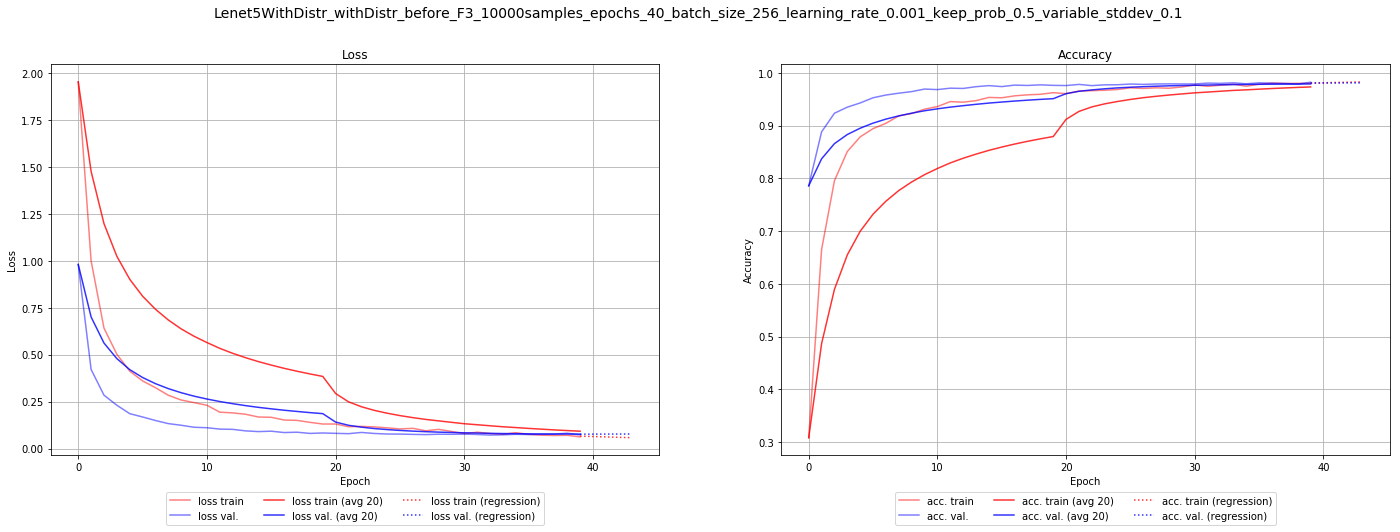

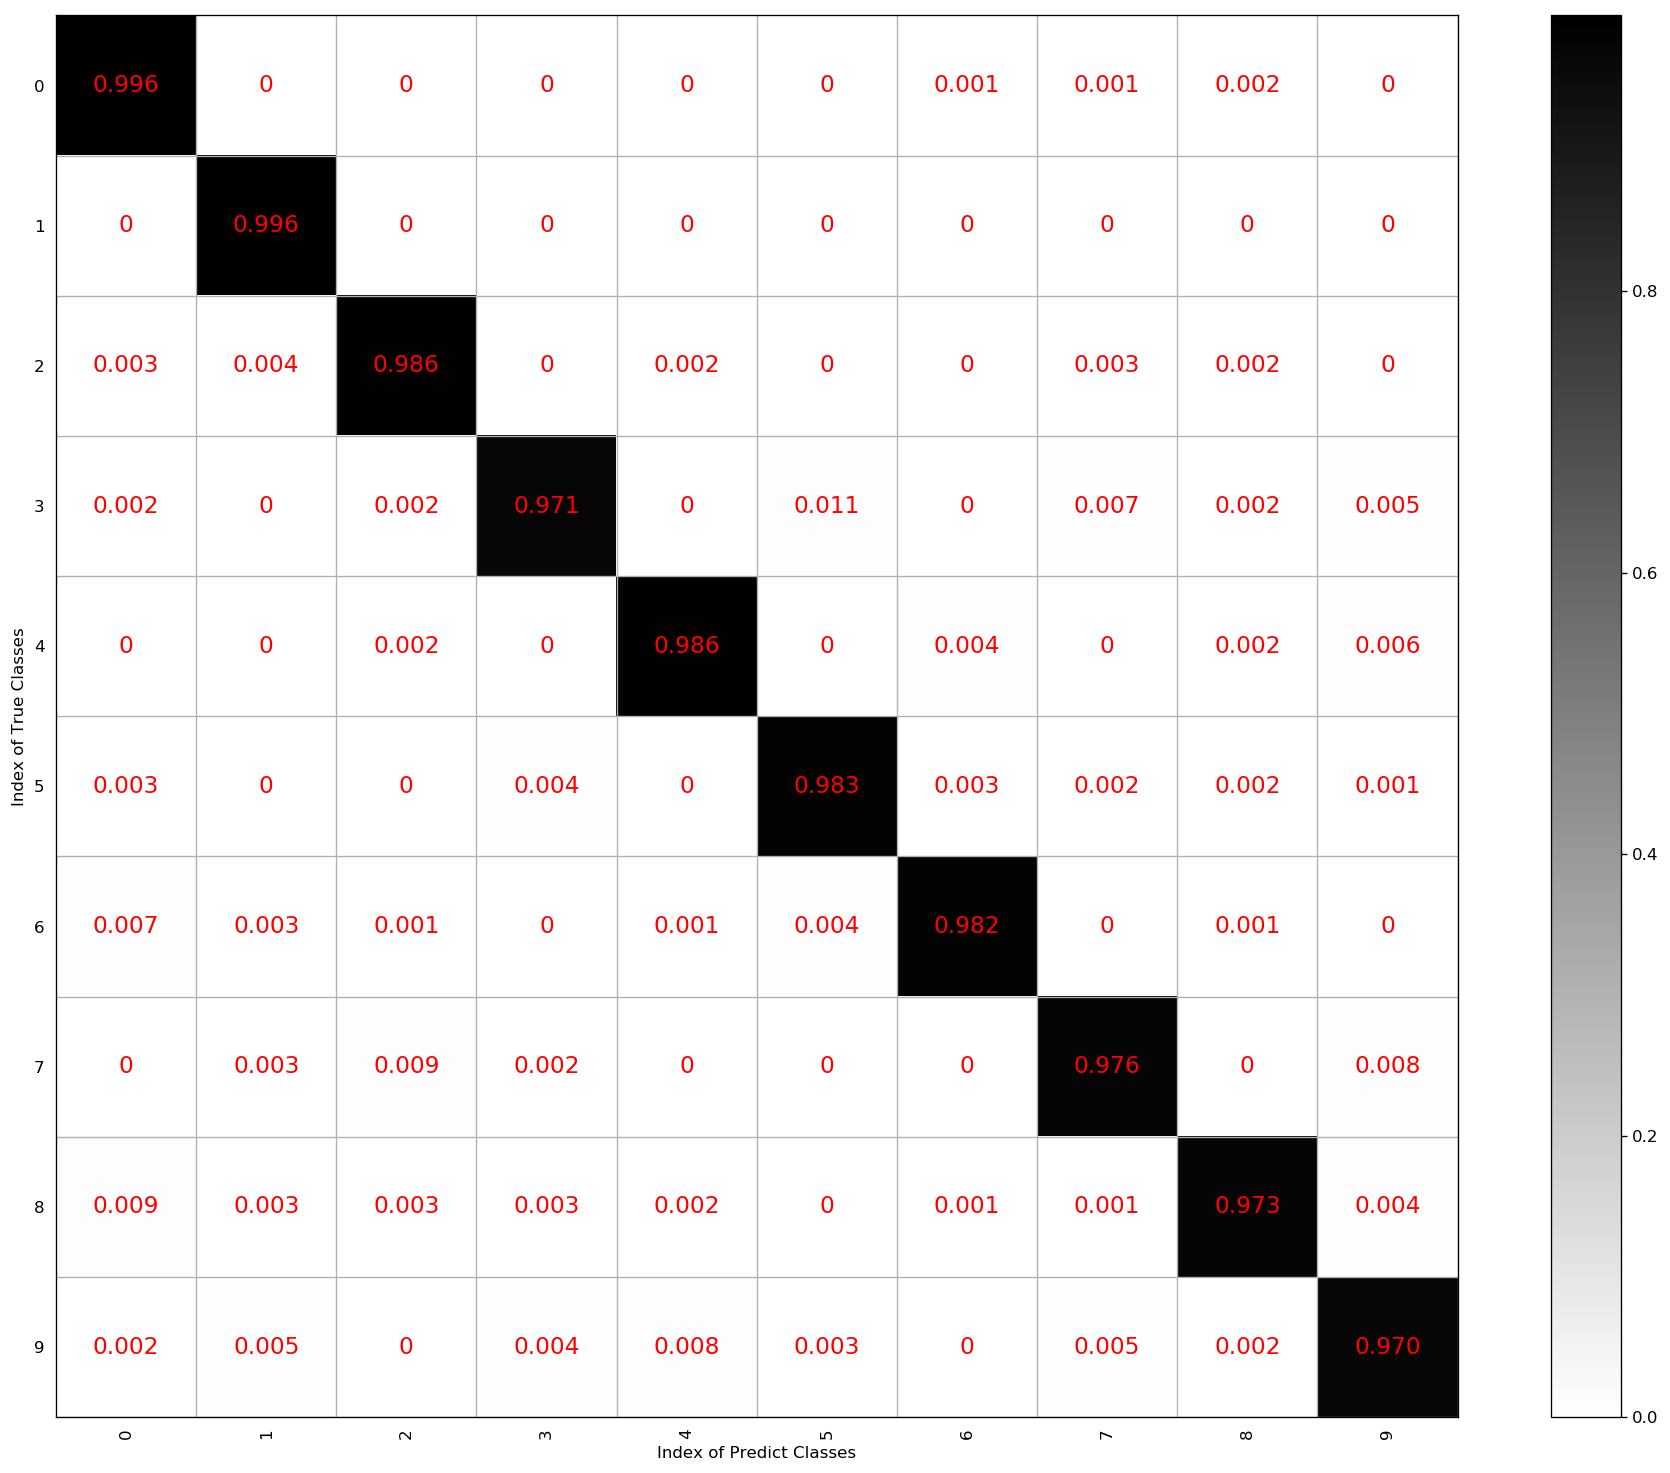

In [143]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_before_F3_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, True])
lenet5_model_with_distr.train()

2018-05-21 07:13:10,196 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before F1
Attached distr. before F2
Attached distr. before F3
2018-05-21 07:13:10,407 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 130]
	[None, 94]
	[None, 10]
2018-05-21 07:13:11,321 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:13:20,401 - EPOCH 1 --- Training: loss = 1.932, acc = 0.334; Validation: loss = 0.870, acc = 0.803; num_examples_used = 9984
2018-05-21 07:13:29,968 - EPOCH 2 --- Training: lo

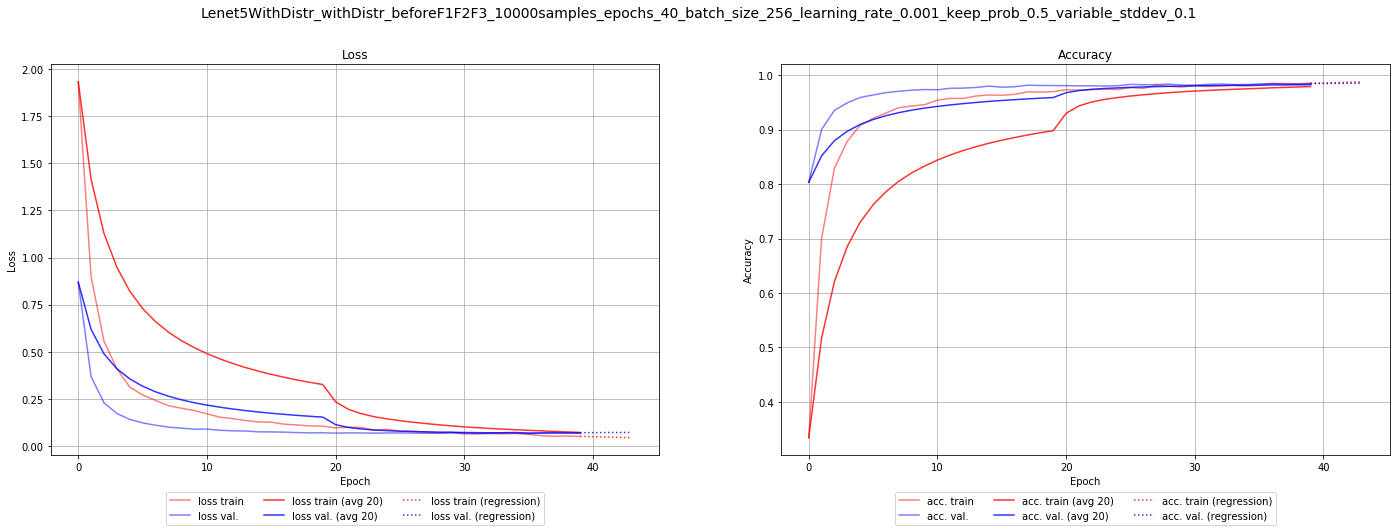

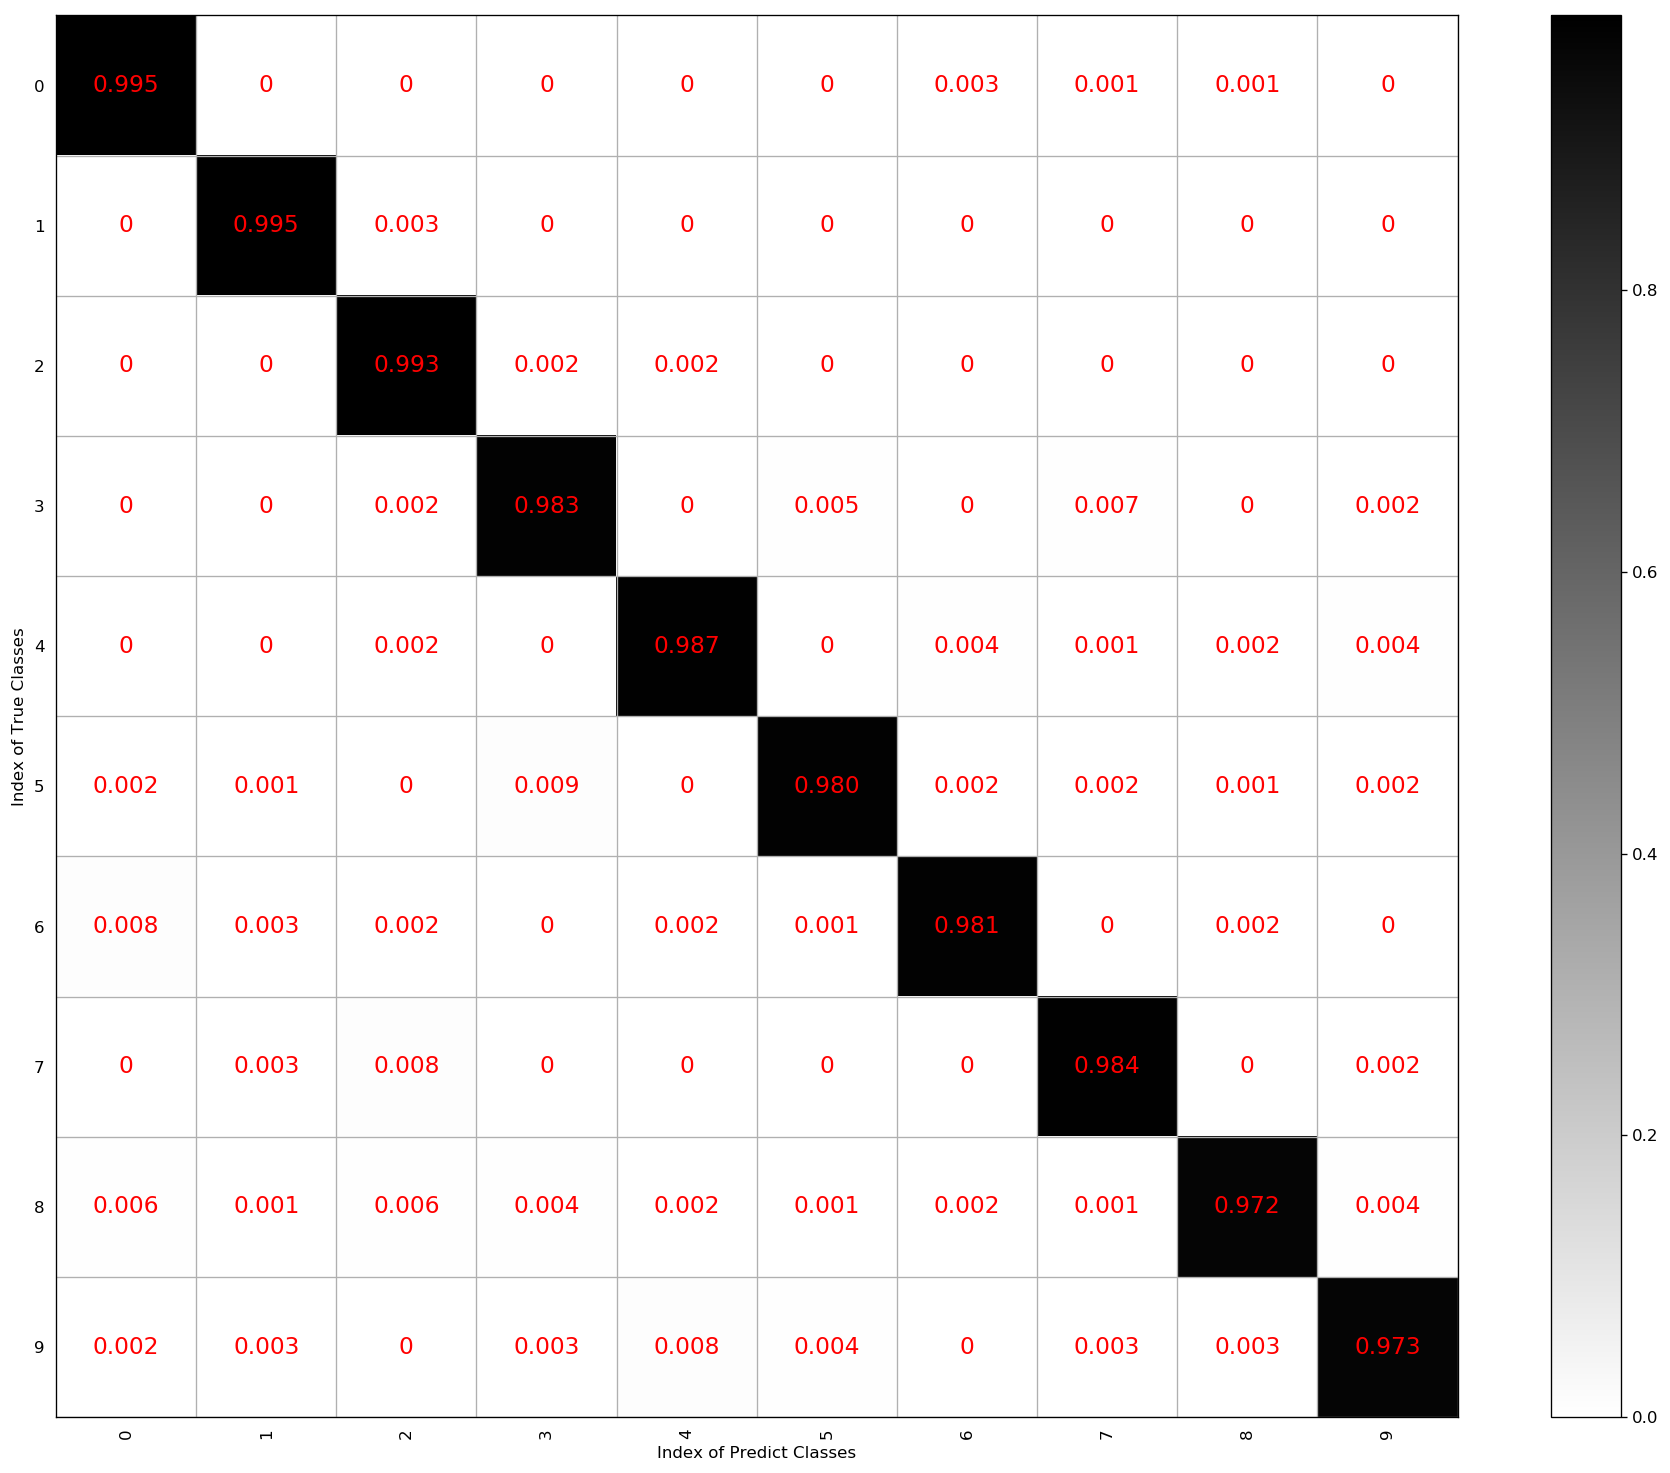

In [144]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeF1F2F3_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, True, True])
lenet5_model_with_distr.train()

2018-05-21 07:19:48,175 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before F1
2018-05-21 07:19:48,348 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 07:19:49,201 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:19:57,932 - EPOCH 1 --- Training: loss = 2.006, acc = 0.296; Validation: loss = 1.056, acc = 0.785; num_examples_used = 9984
2018-05-21 07:20:08,852 - EPOCH 2 --- Training: loss = 1.004, acc = 0.663; Validation: loss = 0.386, a

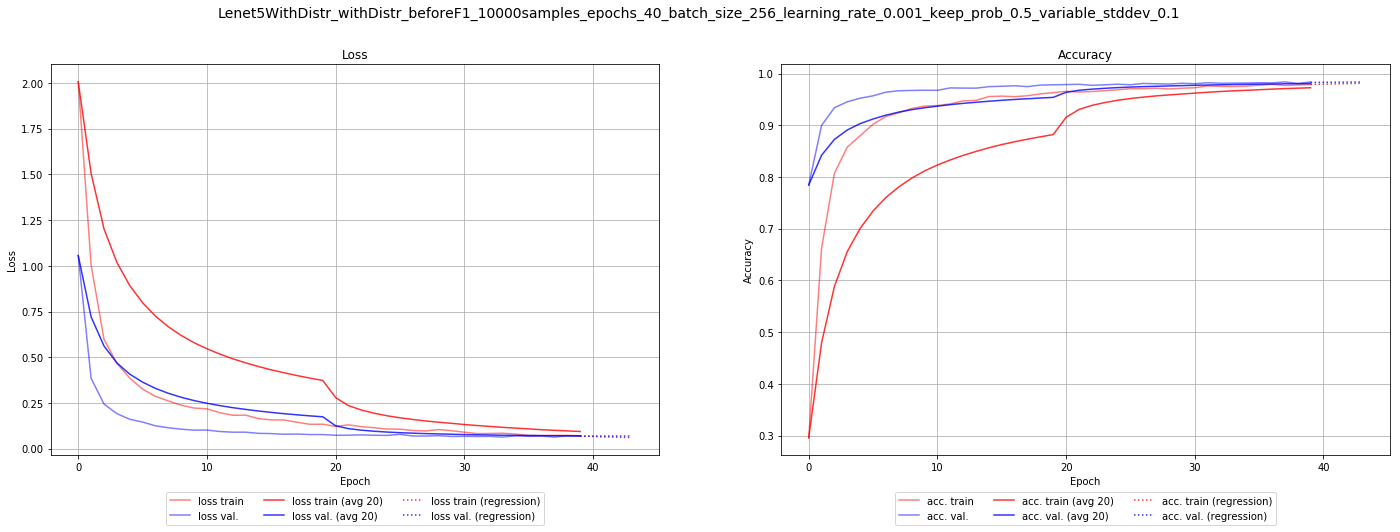

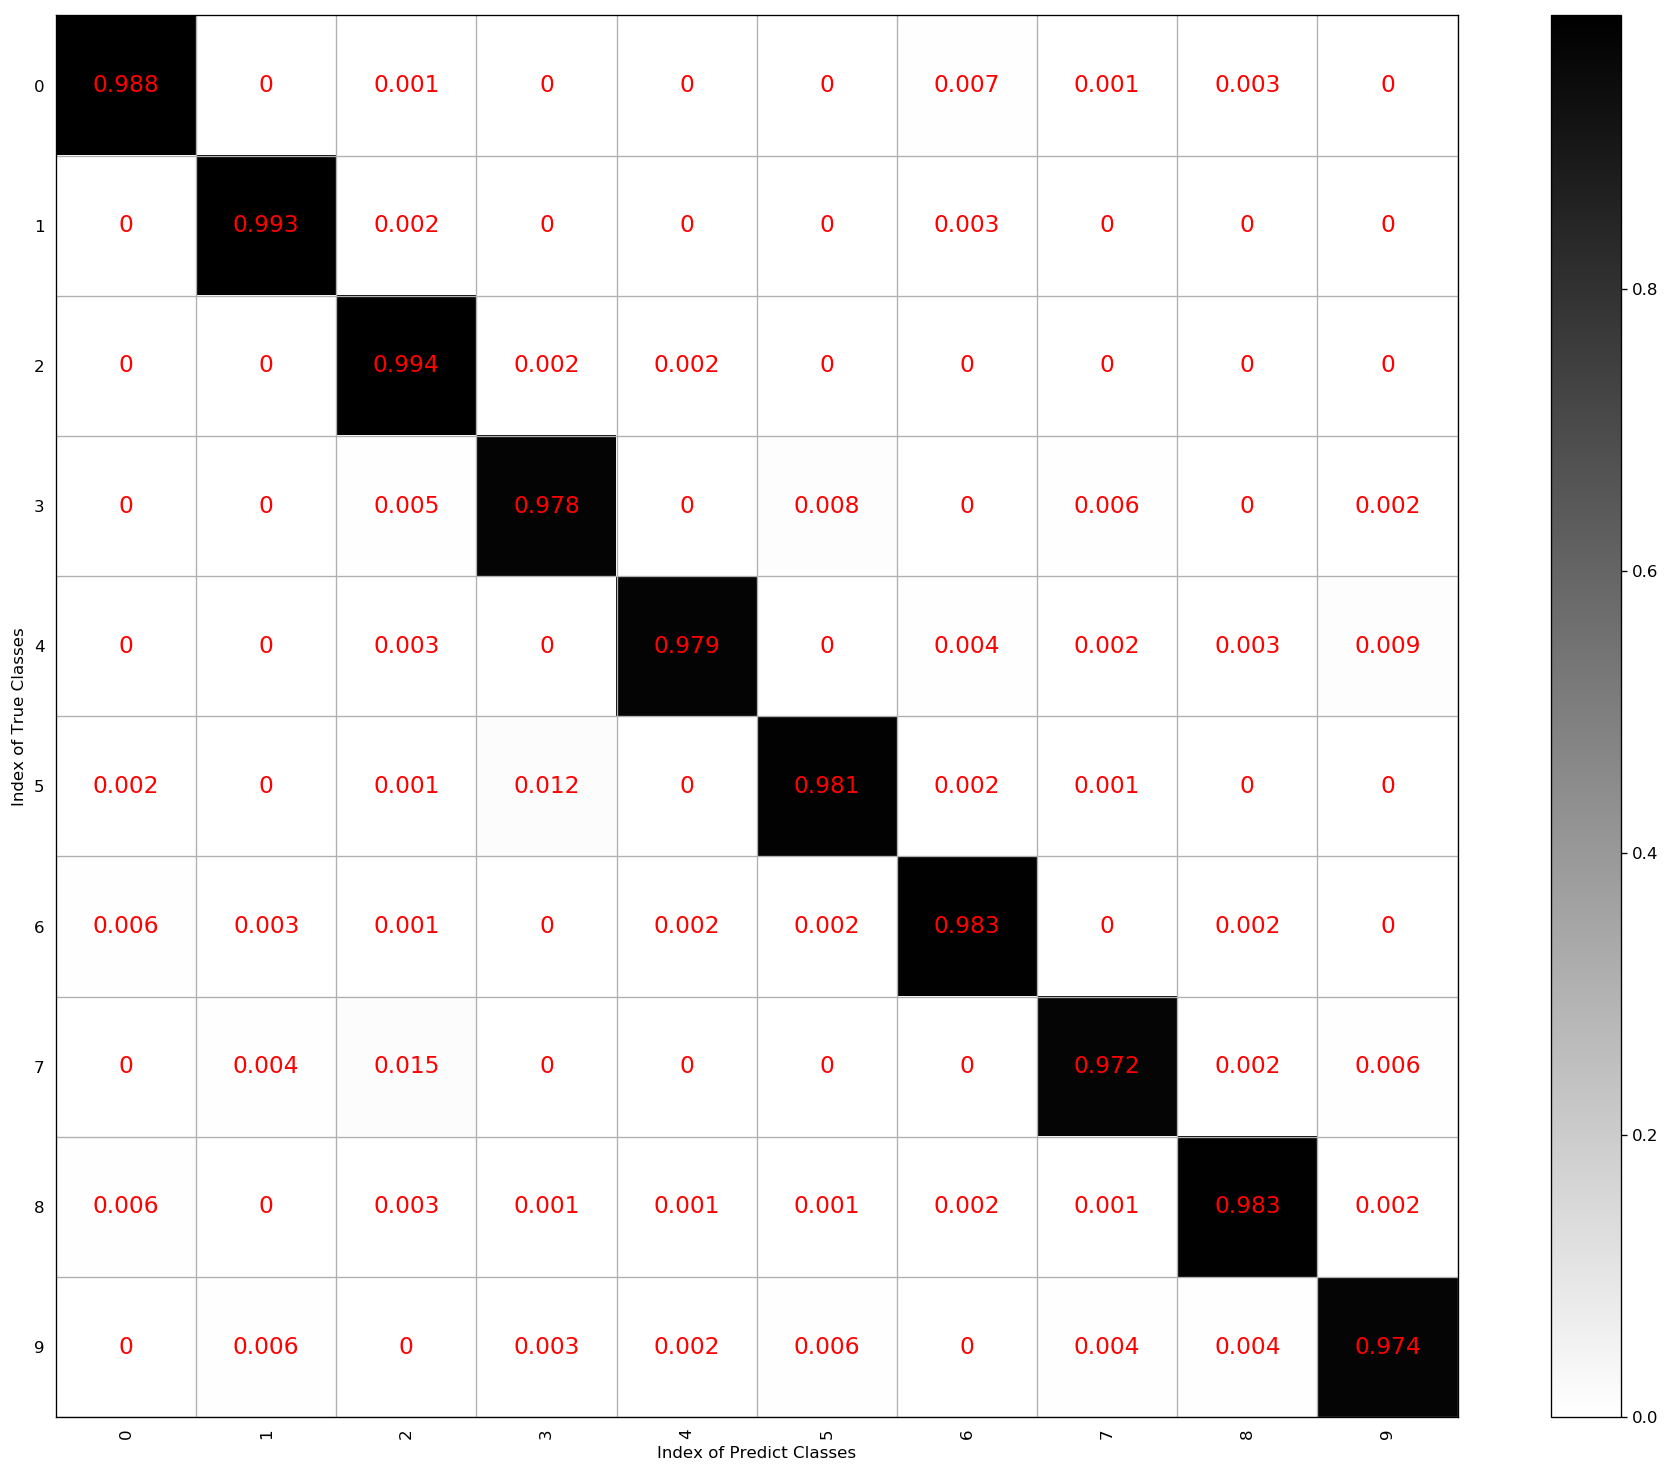

In [145]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeF1_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, False, False])
lenet5_model_with_distr.train()

2018-05-21 07:26:26,782 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C1 (at input)
2018-05-21 07:26:27,021 - Network layers size:
	[None, 29, 28, 1]
	[None, 29, 28, 6]
	[None, 15, 14, 6]
	[None, 11, 10, 16]
	[None, 480]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 07:26:28,675 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:26:37,752 - EPOCH 1 --- Training: loss = 1.988, acc = 0.306; Validation: loss = 1.085, acc = 0.757; num_examples_used = 9984
2018-05-21 07:26:47,803 - EPOCH 2 --- Training: loss = 1.071, acc = 0.641; Validation: loss

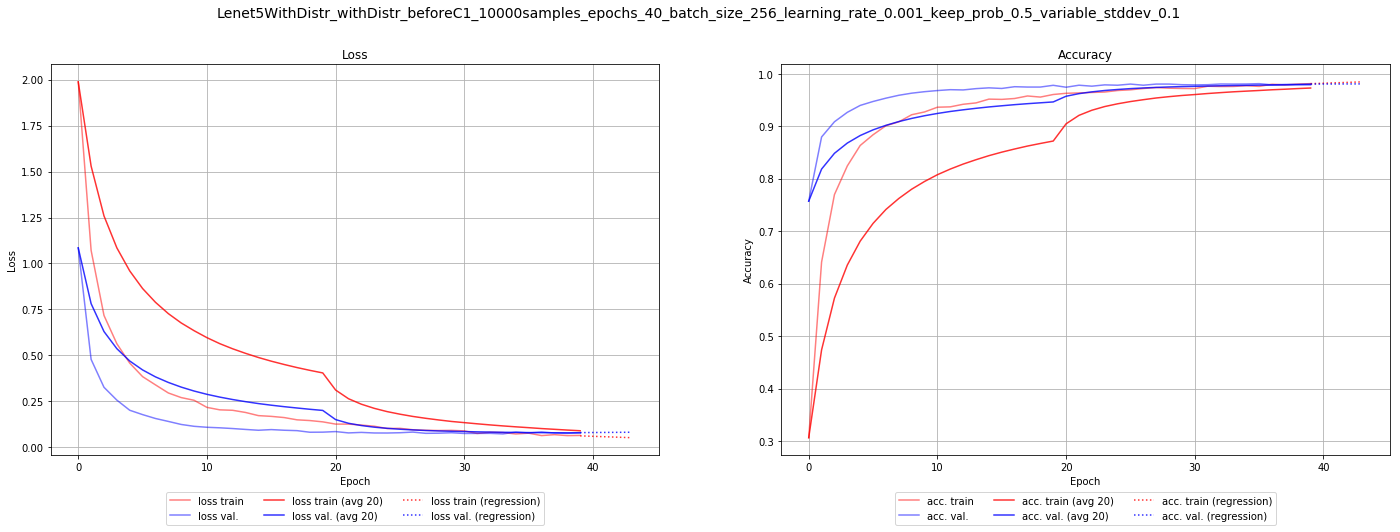

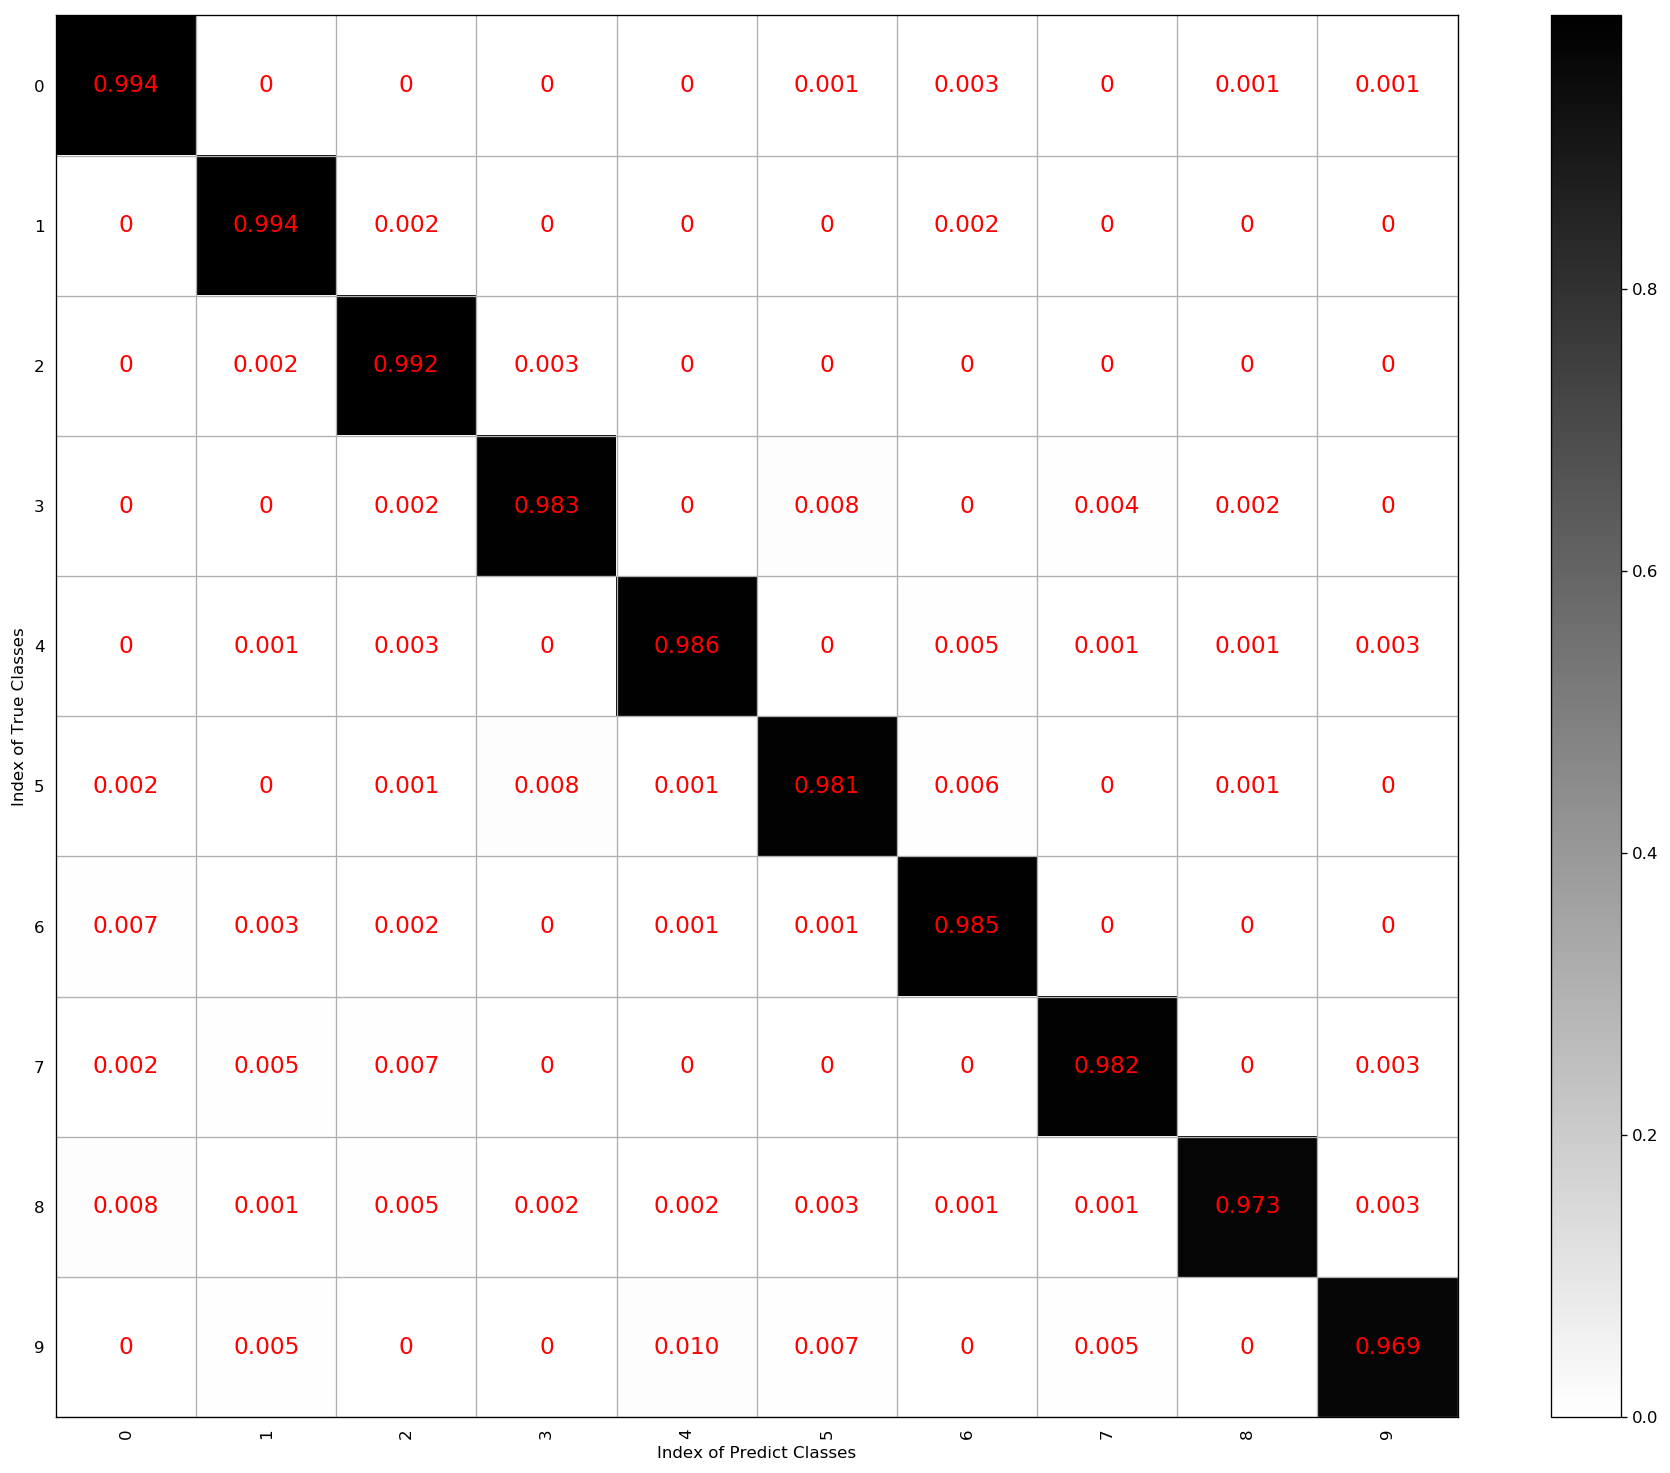

In [146]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeC1_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [True, False, False, False, False])
lenet5_model_with_distr.train()

2018-05-21 07:34:01,652 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C2
2018-05-21 07:34:01,922 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 15, 14, 6]
	[None, 11, 10, 16]
	[None, 480]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 07:34:02,974 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:34:12,924 - EPOCH 1 --- Training: loss = 2.016, acc = 0.282; Validation: loss = 1.182, acc = 0.722; num_examples_used = 9984
2018-05-21 07:34:23,521 - EPOCH 2 --- Training: loss = 1.083, acc = 0.629; Validation: loss = 0.449, a

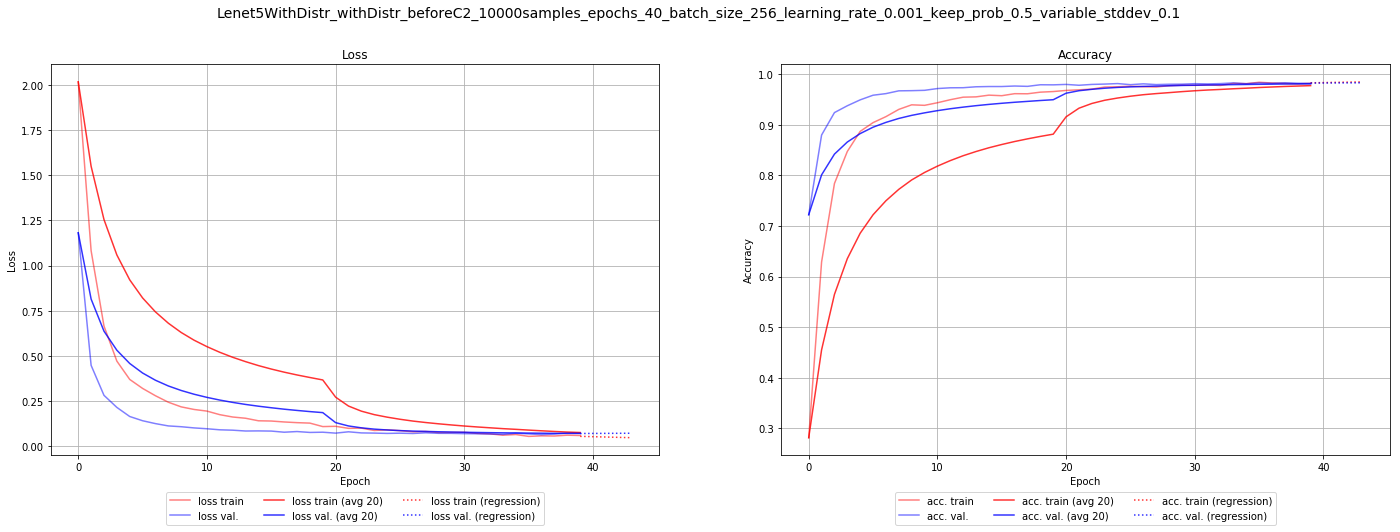

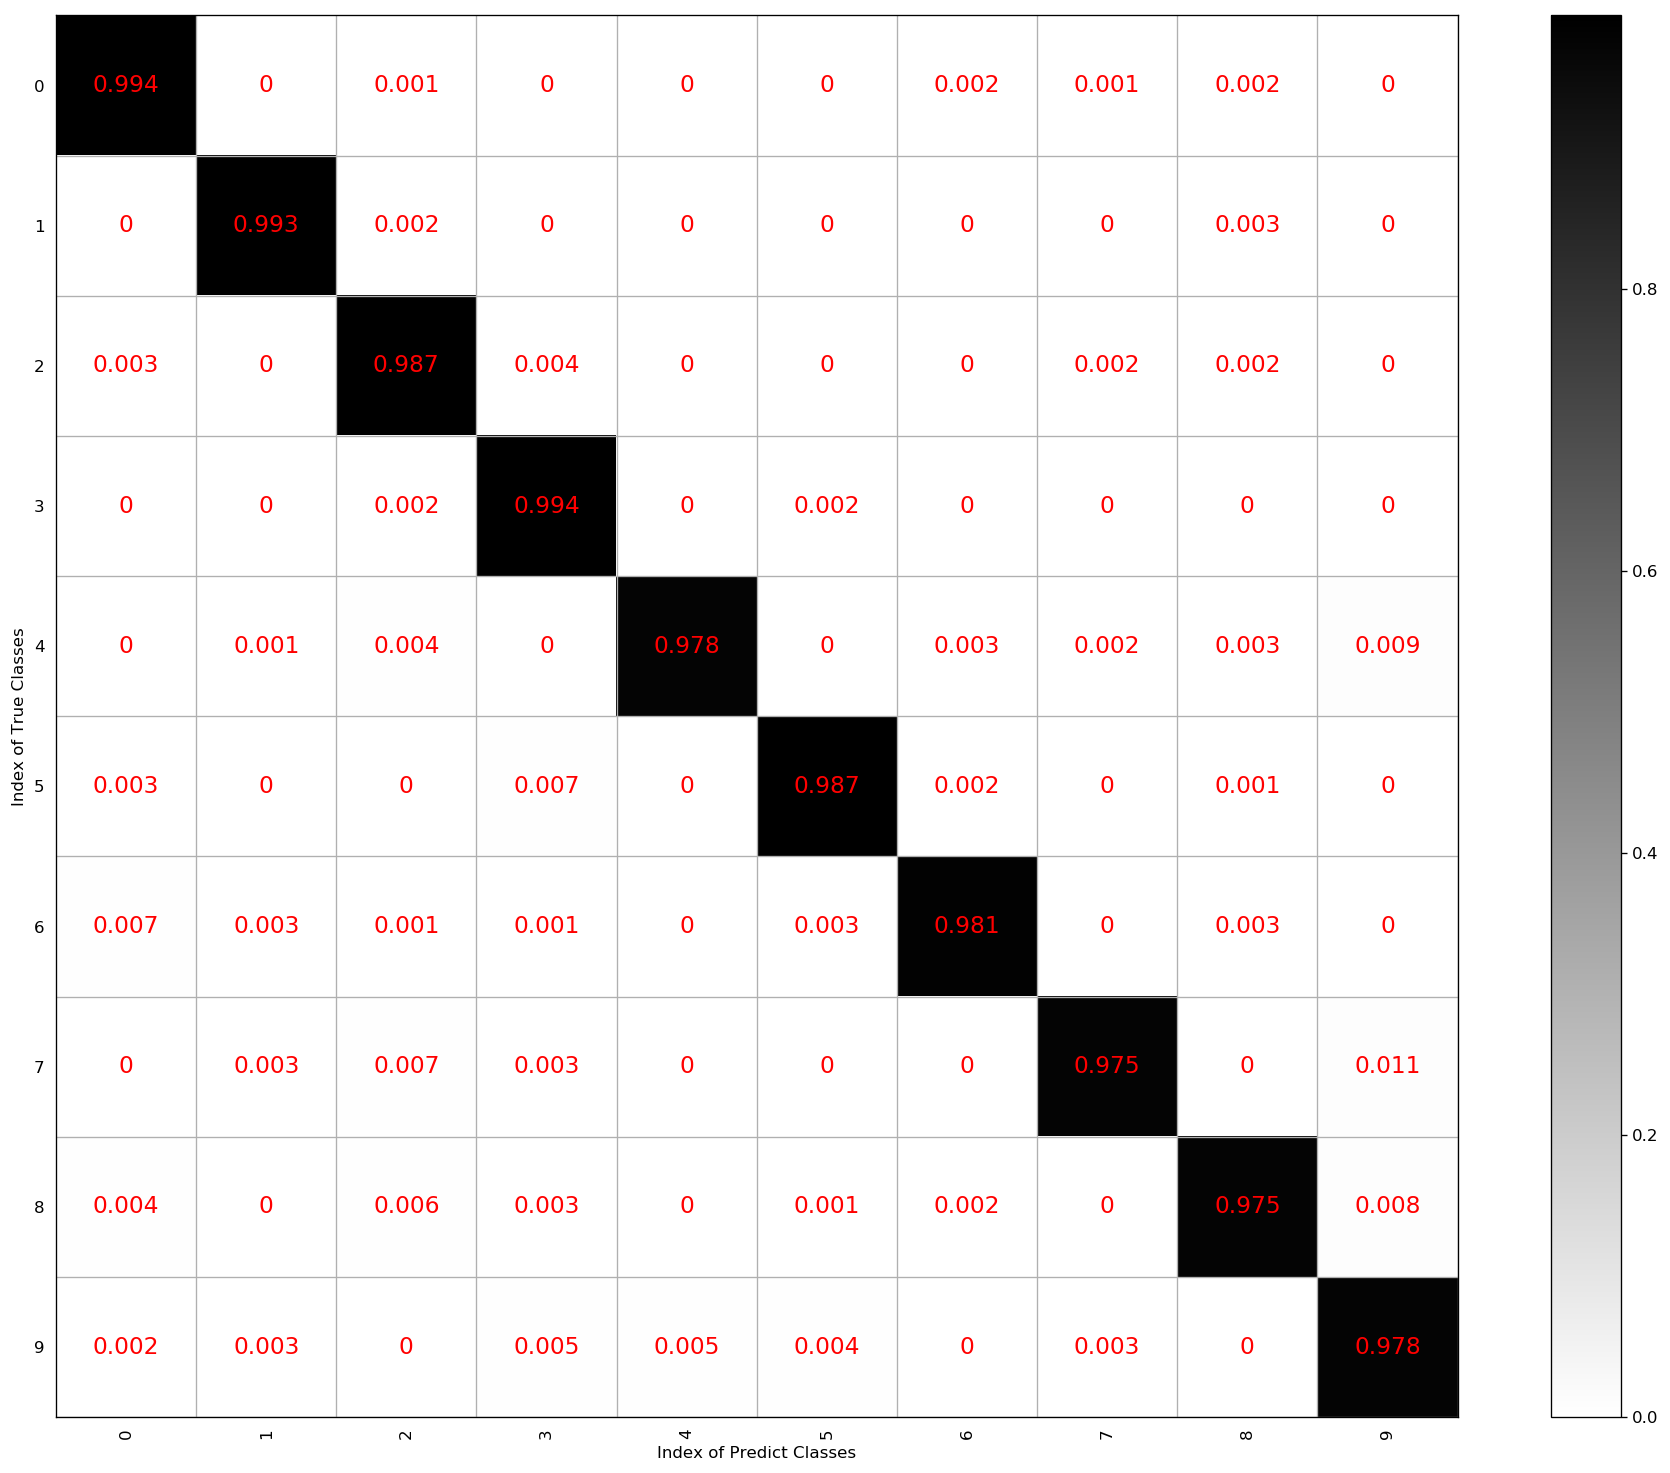

In [148]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeC2_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, True, False, False, False])
lenet5_model_with_distr.train()

2018-05-21 07:41:07,533 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C1 (at input)
Attached distr. before C2
2018-05-21 07:41:07,861 - Network layers size:
	[None, 29, 28, 1]
	[None, 29, 28, 6]
	[None, 16, 14, 6]
	[None, 12, 10, 16]
	[None, 480]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 07:41:09,355 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:41:19,656 - EPOCH 1 --- Training: loss = 1.955, acc = 0.304; Validation: loss = 1.089, acc = 0.716; num_examples_used = 9984
2018-05-21 07:41:31,149 - EPOCH 2 --- Training: loss = 1.049, acc

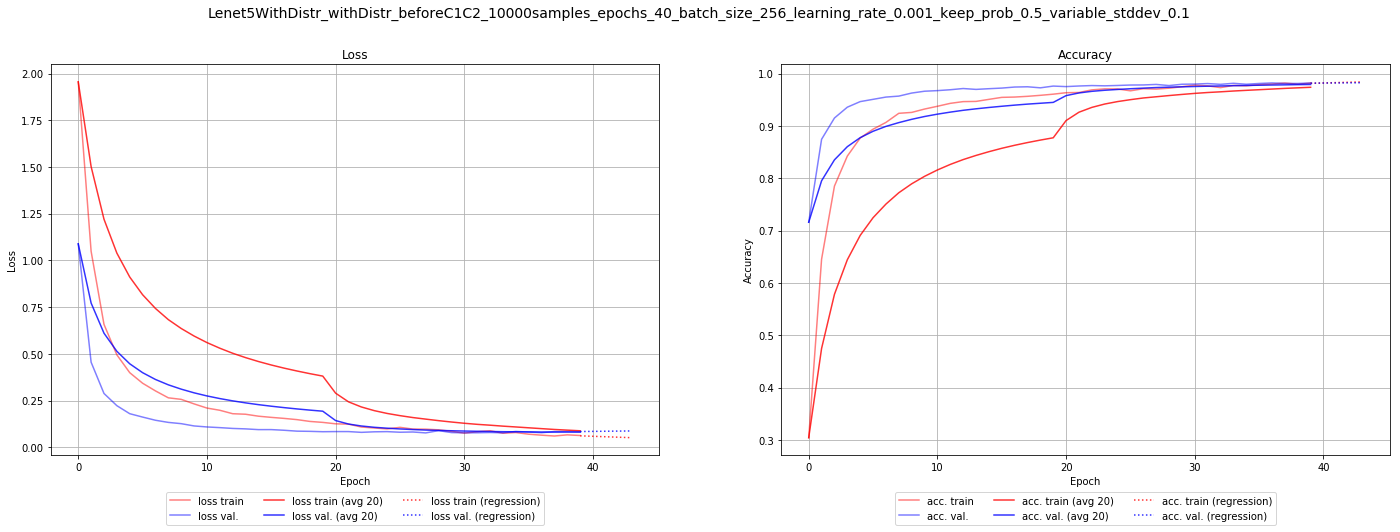

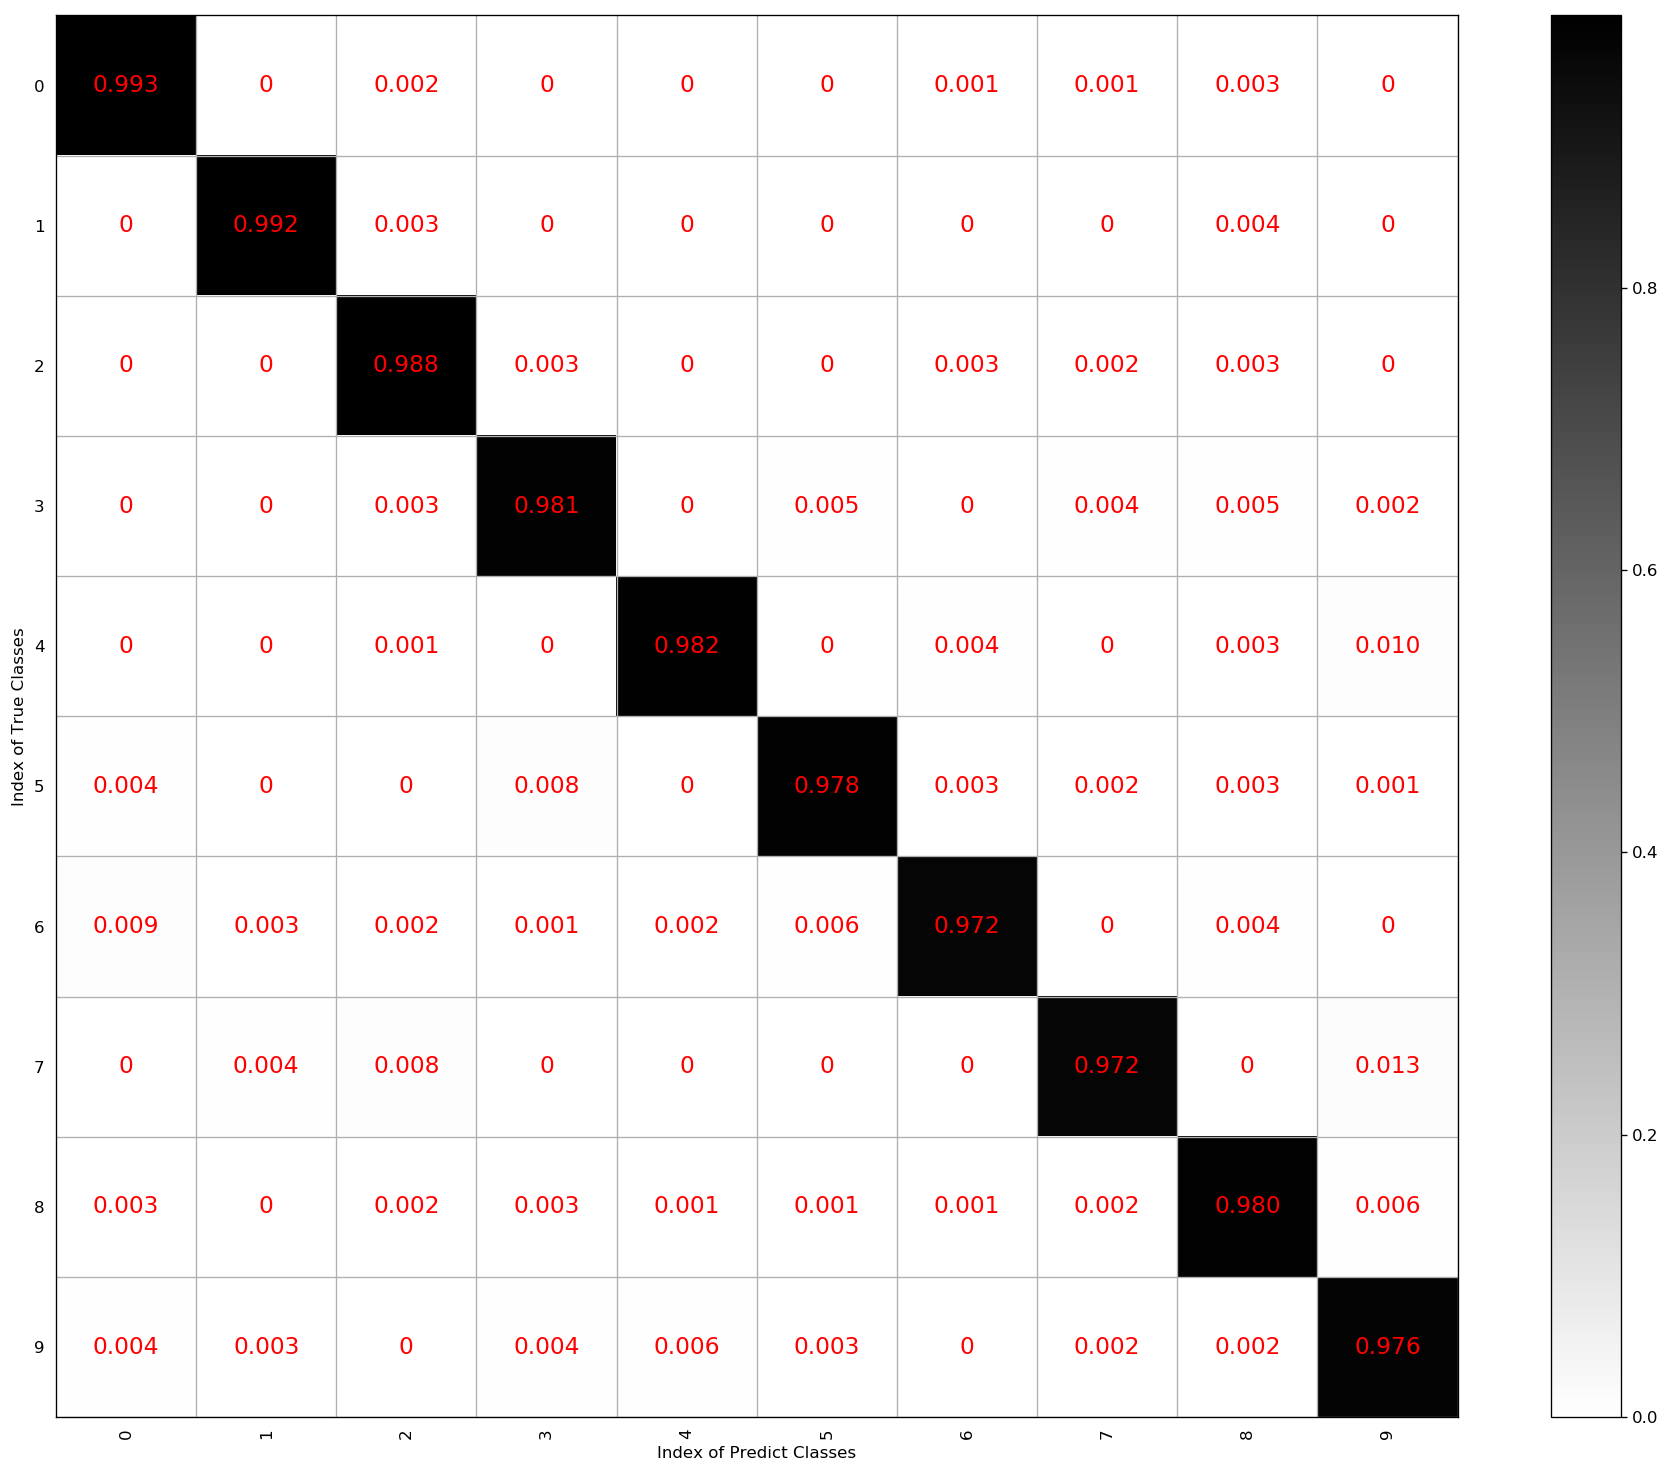

In [149]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeC1C2_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [True, True, False, False, False])
lenet5_model_with_distr.train()

2018-05-21 07:48:45,984 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C1 (at input)
Attached distr. before C2
Attached distr. before F1
Attached distr. before F2
Attached distr. before F3
2018-05-21 07:48:46,325 - Network layers size:
	[None, 29, 28, 1]
	[None, 29, 28, 6]
	[None, 16, 14, 6]
	[None, 12, 10, 16]
	[None, 490]
	[None, 130]
	[None, 94]
	[None, 10]
2018-05-21 07:48:47,547 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 07:48:58,273 - EPOCH 1 --- Training: loss = 2.030, acc = 0.295; Validation: loss = 1.059, acc = 0.809; num_examples

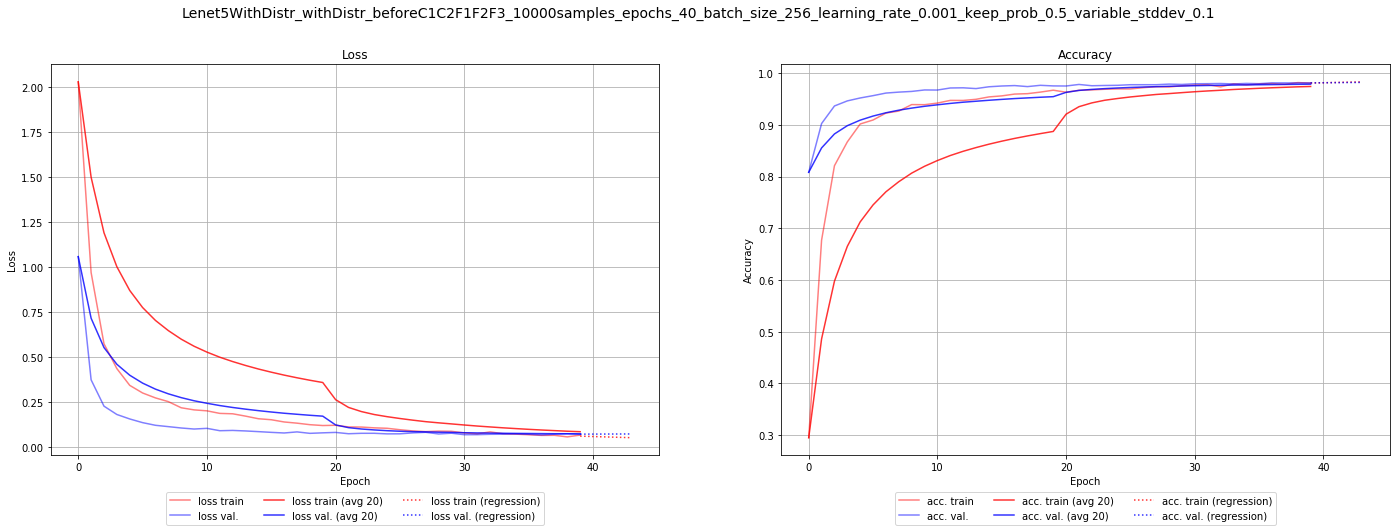

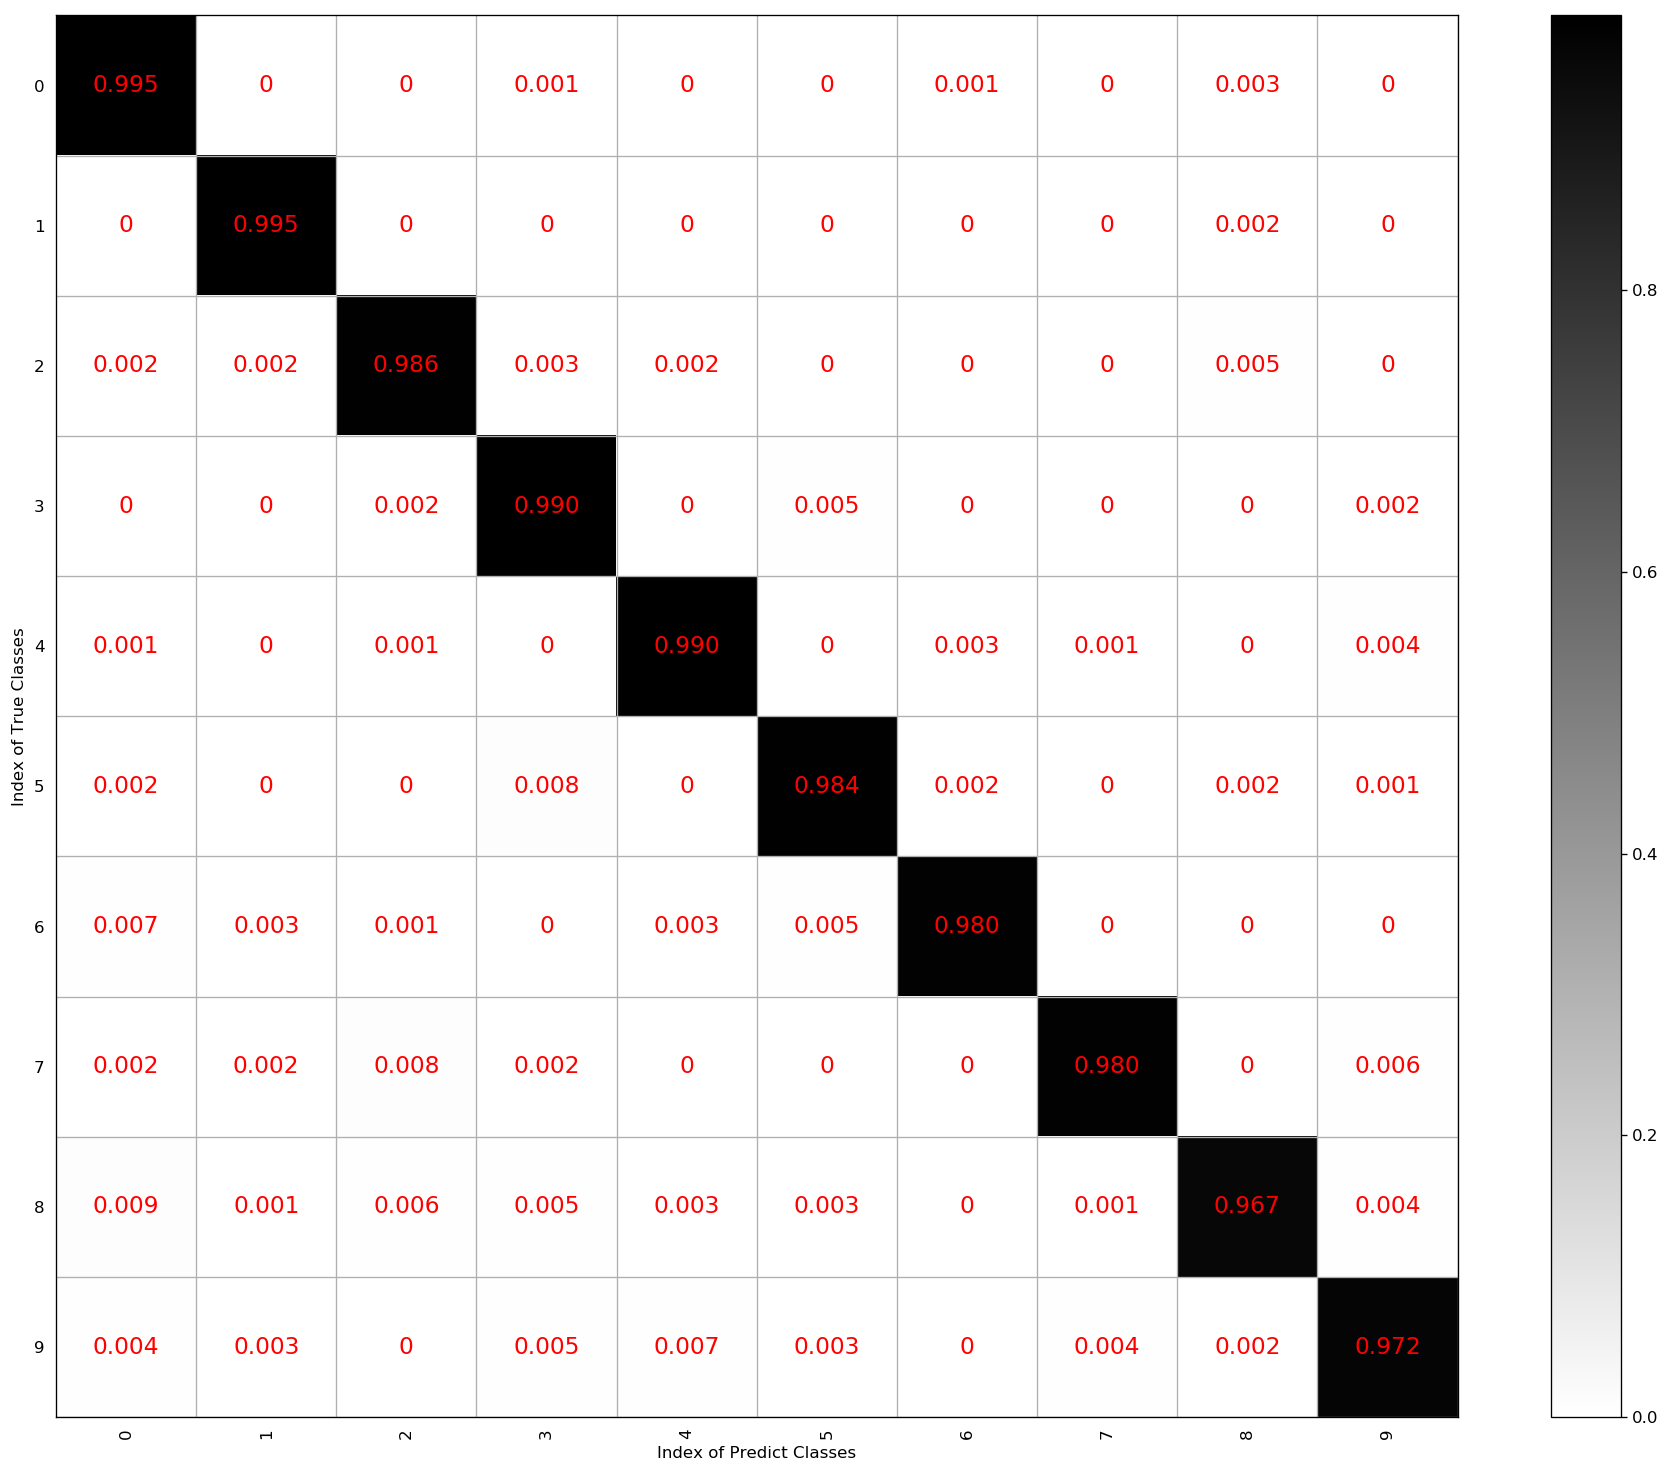

In [150]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "withDistr_beforeC1C2F1F2F3_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [True, True, True, True, True])
lenet5_model_with_distr.train()

***
### Section 2
Train a model by imposing only those eight distributions used in the first experiment. Use the same amount of data.  
Check its accuracy comparing to the models from the first emperiment (adjusting with real priors) and to the models trained with distributions appended as they are.
***

2018-05-02 02:34:56,687 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
2018-05-02 02:34:56,919 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-02 02:34:58,011 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 02:35:51,513 - EPOCH 1 --- Training: loss = 1.035, acc = 0.652; Validation: loss = 0.209, acc = 0.942; num_examples_used = 44544
2018-05-02 02:36:44,788 - EPOCH 2 --- Training: loss = 0.321, acc = 0.906; Validation: loss = 0.126, acc =

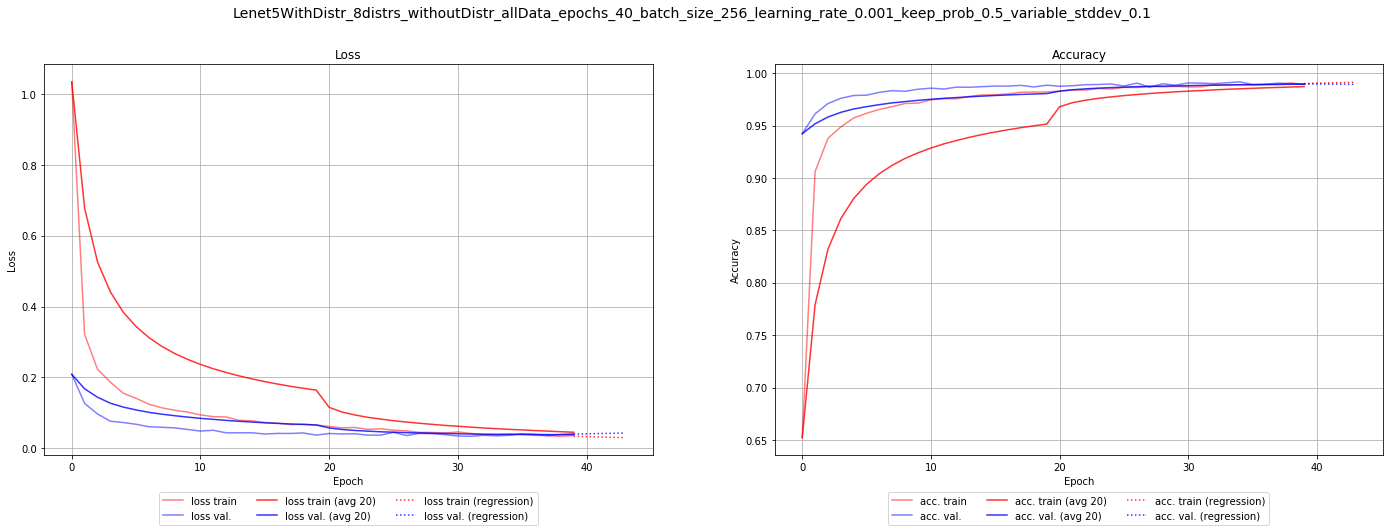

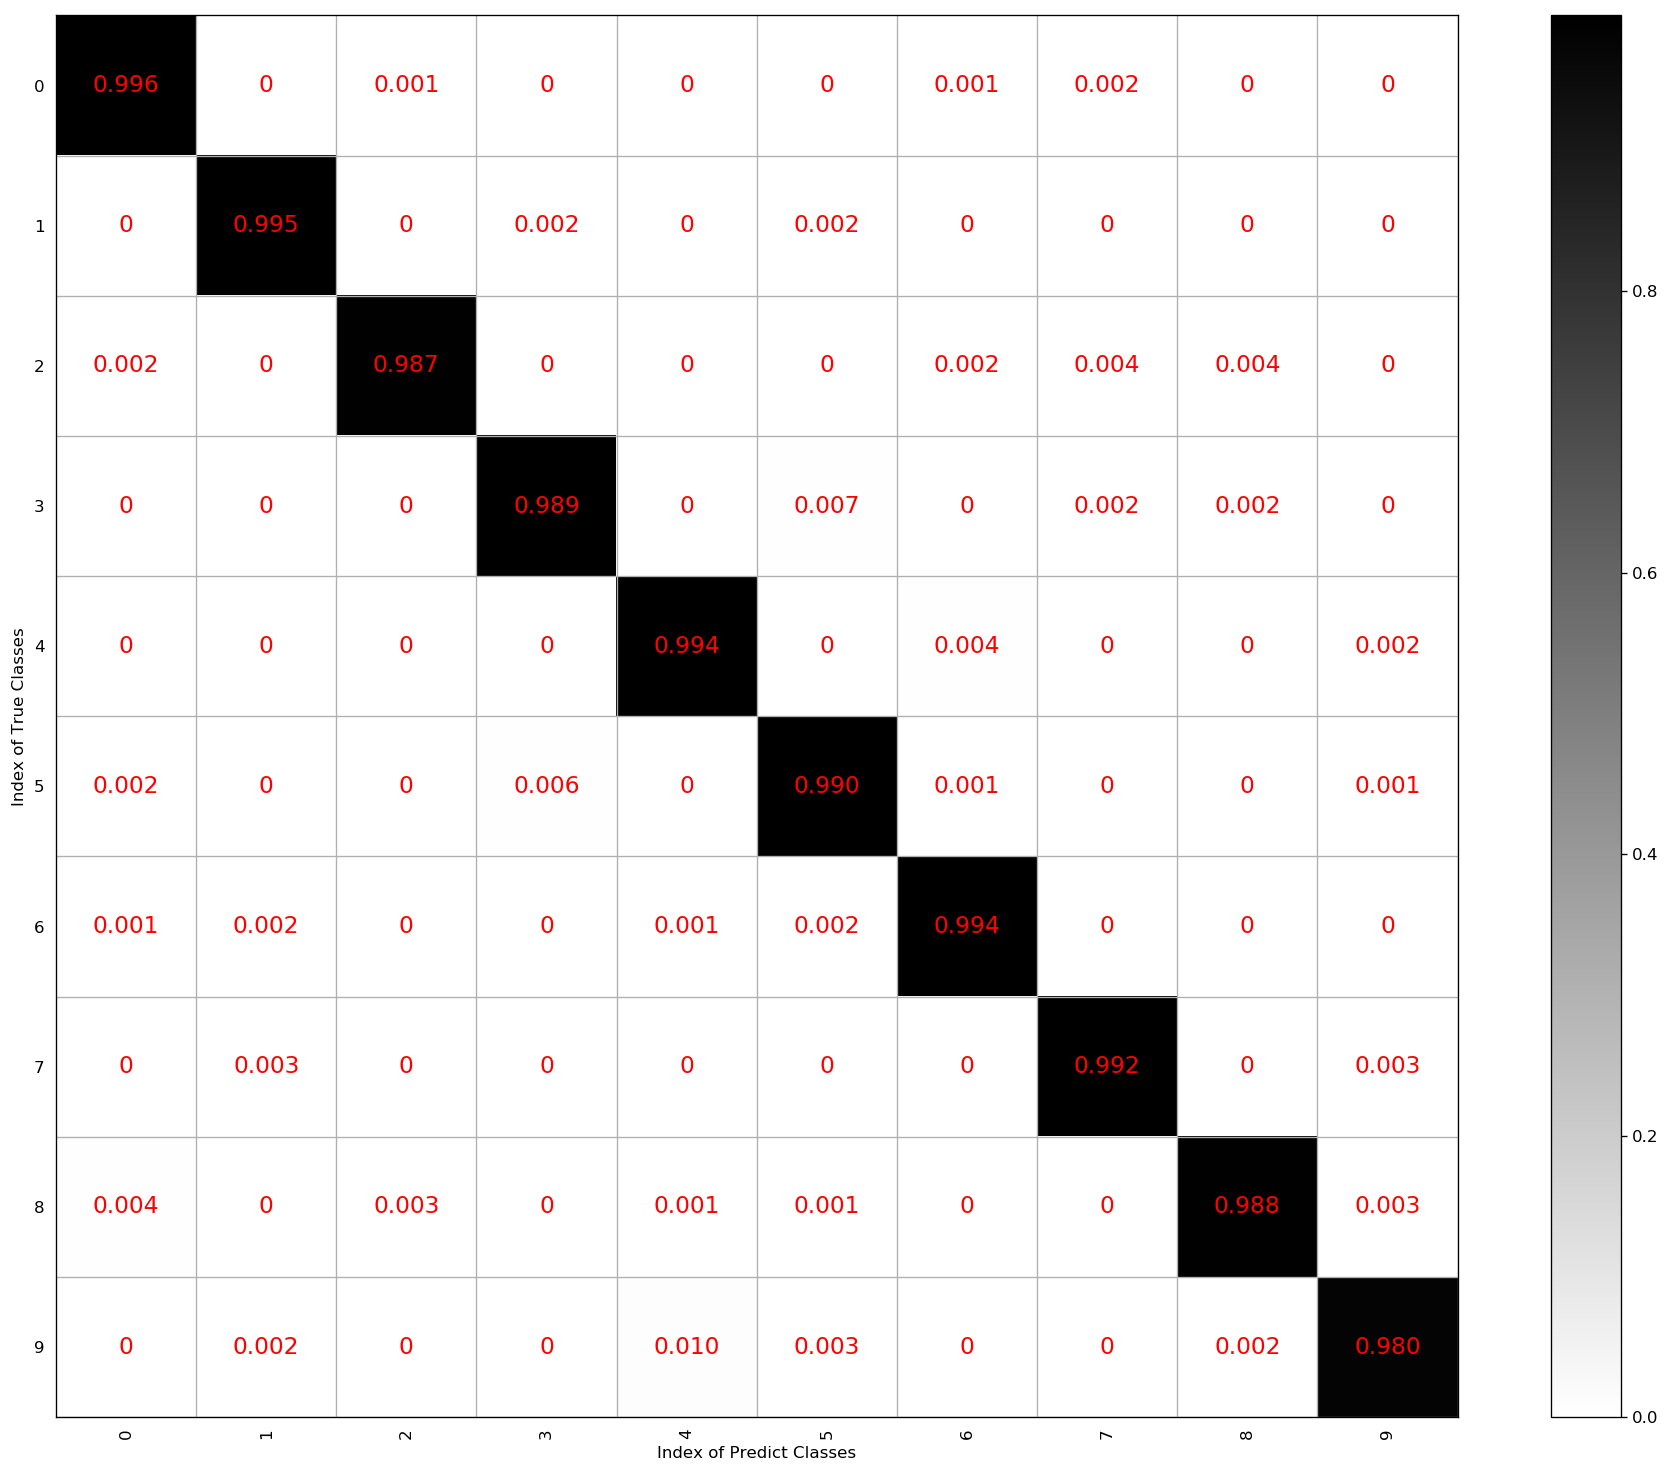

In [43]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withoutDistr_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, False])
lenet5_model_with_distr.train(distrs_list = distrs_used_for_training)

2018-05-02 03:10:43,647 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
F3
2018-05-02 03:10:44,040 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 94]
	[None, 10]
2018-05-02 03:10:45,241 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 03:11:37,928 - EPOCH 1 --- Training: loss = 1.082, acc = 0.635; Validation: loss = 0.221, acc = 0.938; num_examples_used = 44544
2018-05-02 03:12:31,783 - EPOCH 2 --- Training: loss = 0.347, acc = 0.898; Validation: loss = 0.130, ac

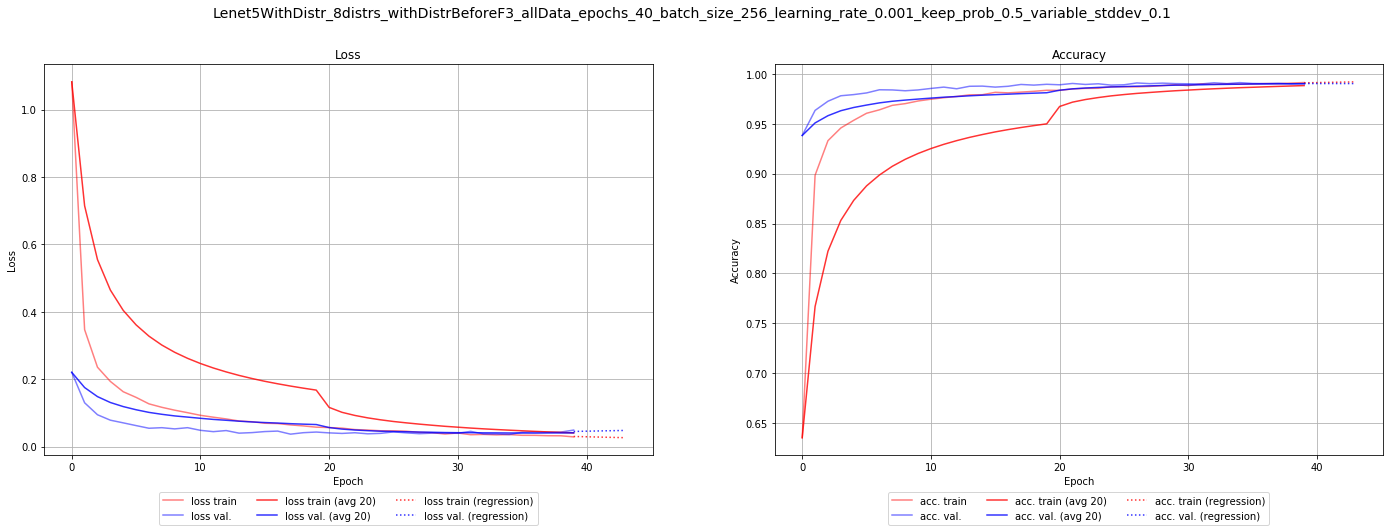

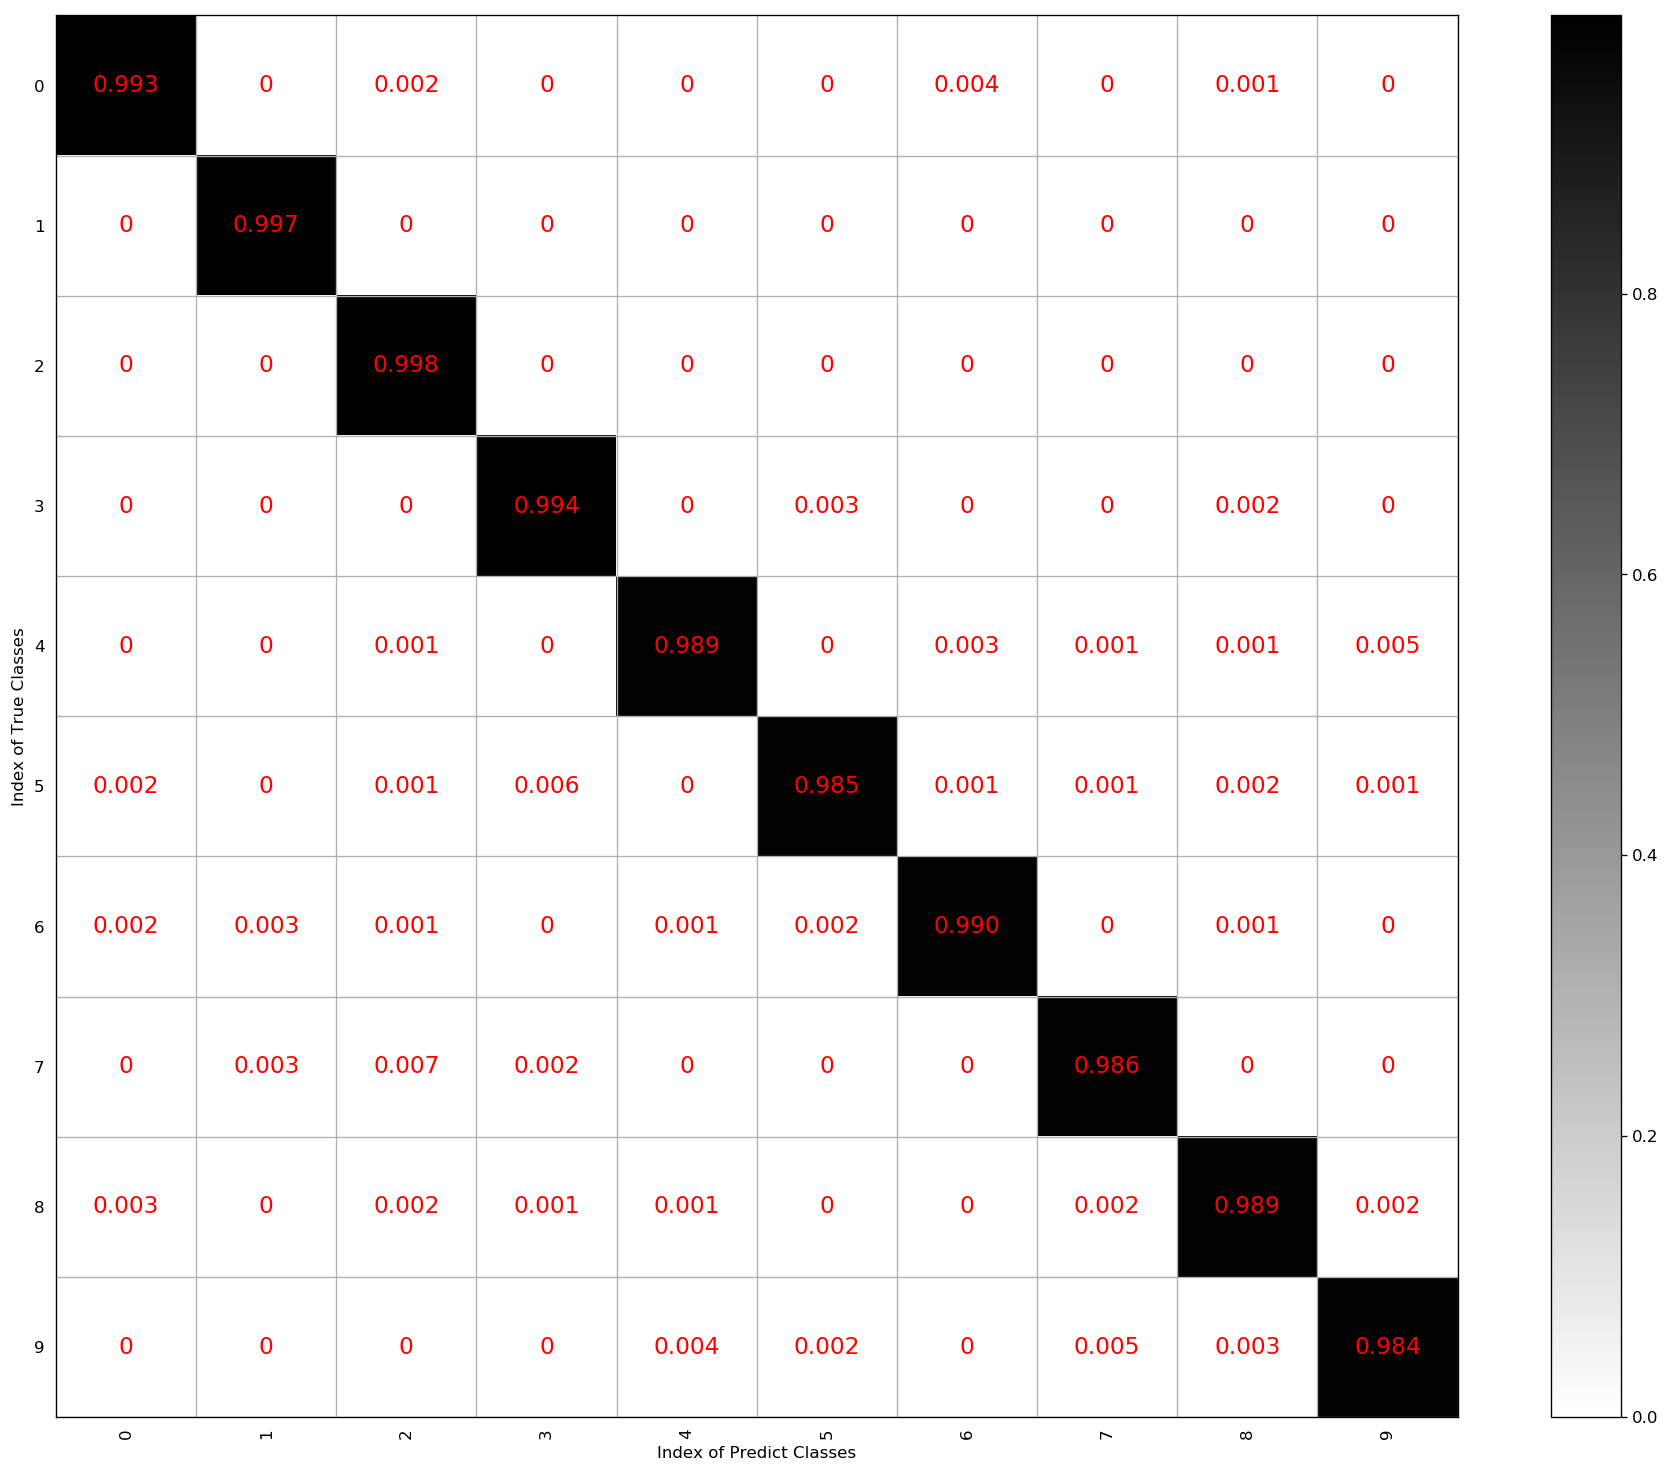

In [44]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeF3_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, True])
lenet5_model_with_distr.train(distrs_list = distrs_used_for_training)

2018-05-02 03:46:20,838 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
F1
2018-05-02 03:46:21,279 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-02 03:46:22,224 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 03:47:15,315 - EPOCH 1 --- Training: loss = 1.094, acc = 0.628; Validation: loss = 0.226, acc = 0.933; num_examples_used = 44544
2018-05-02 03:48:08,833 - EPOCH 2 --- Training: loss = 0.345, acc = 0.898; Validation: loss = 0.123, ac

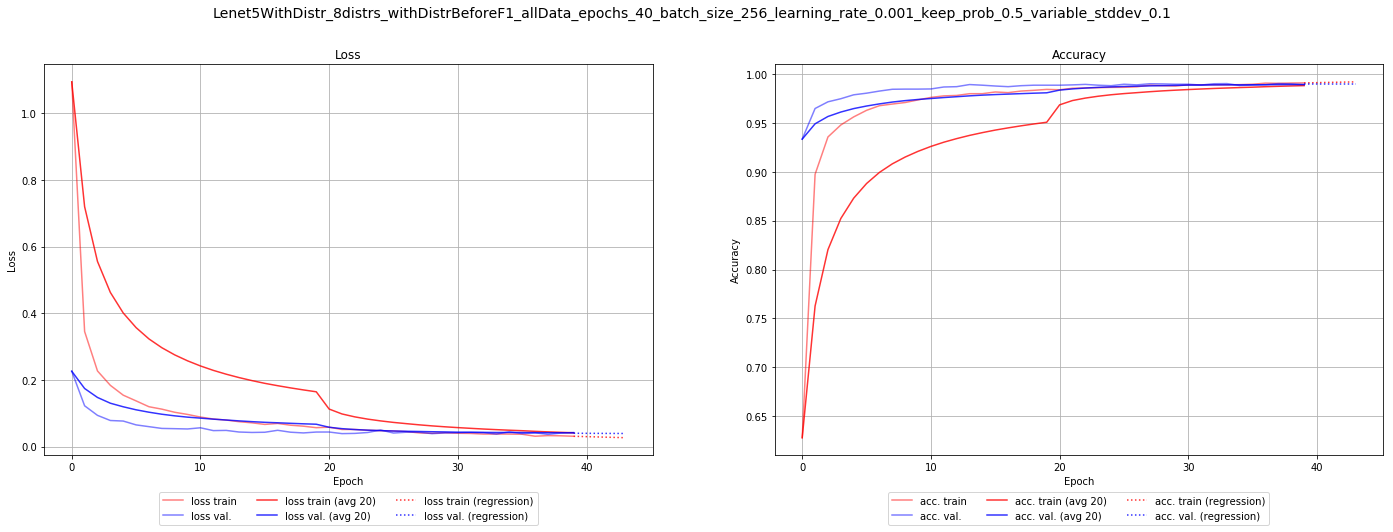

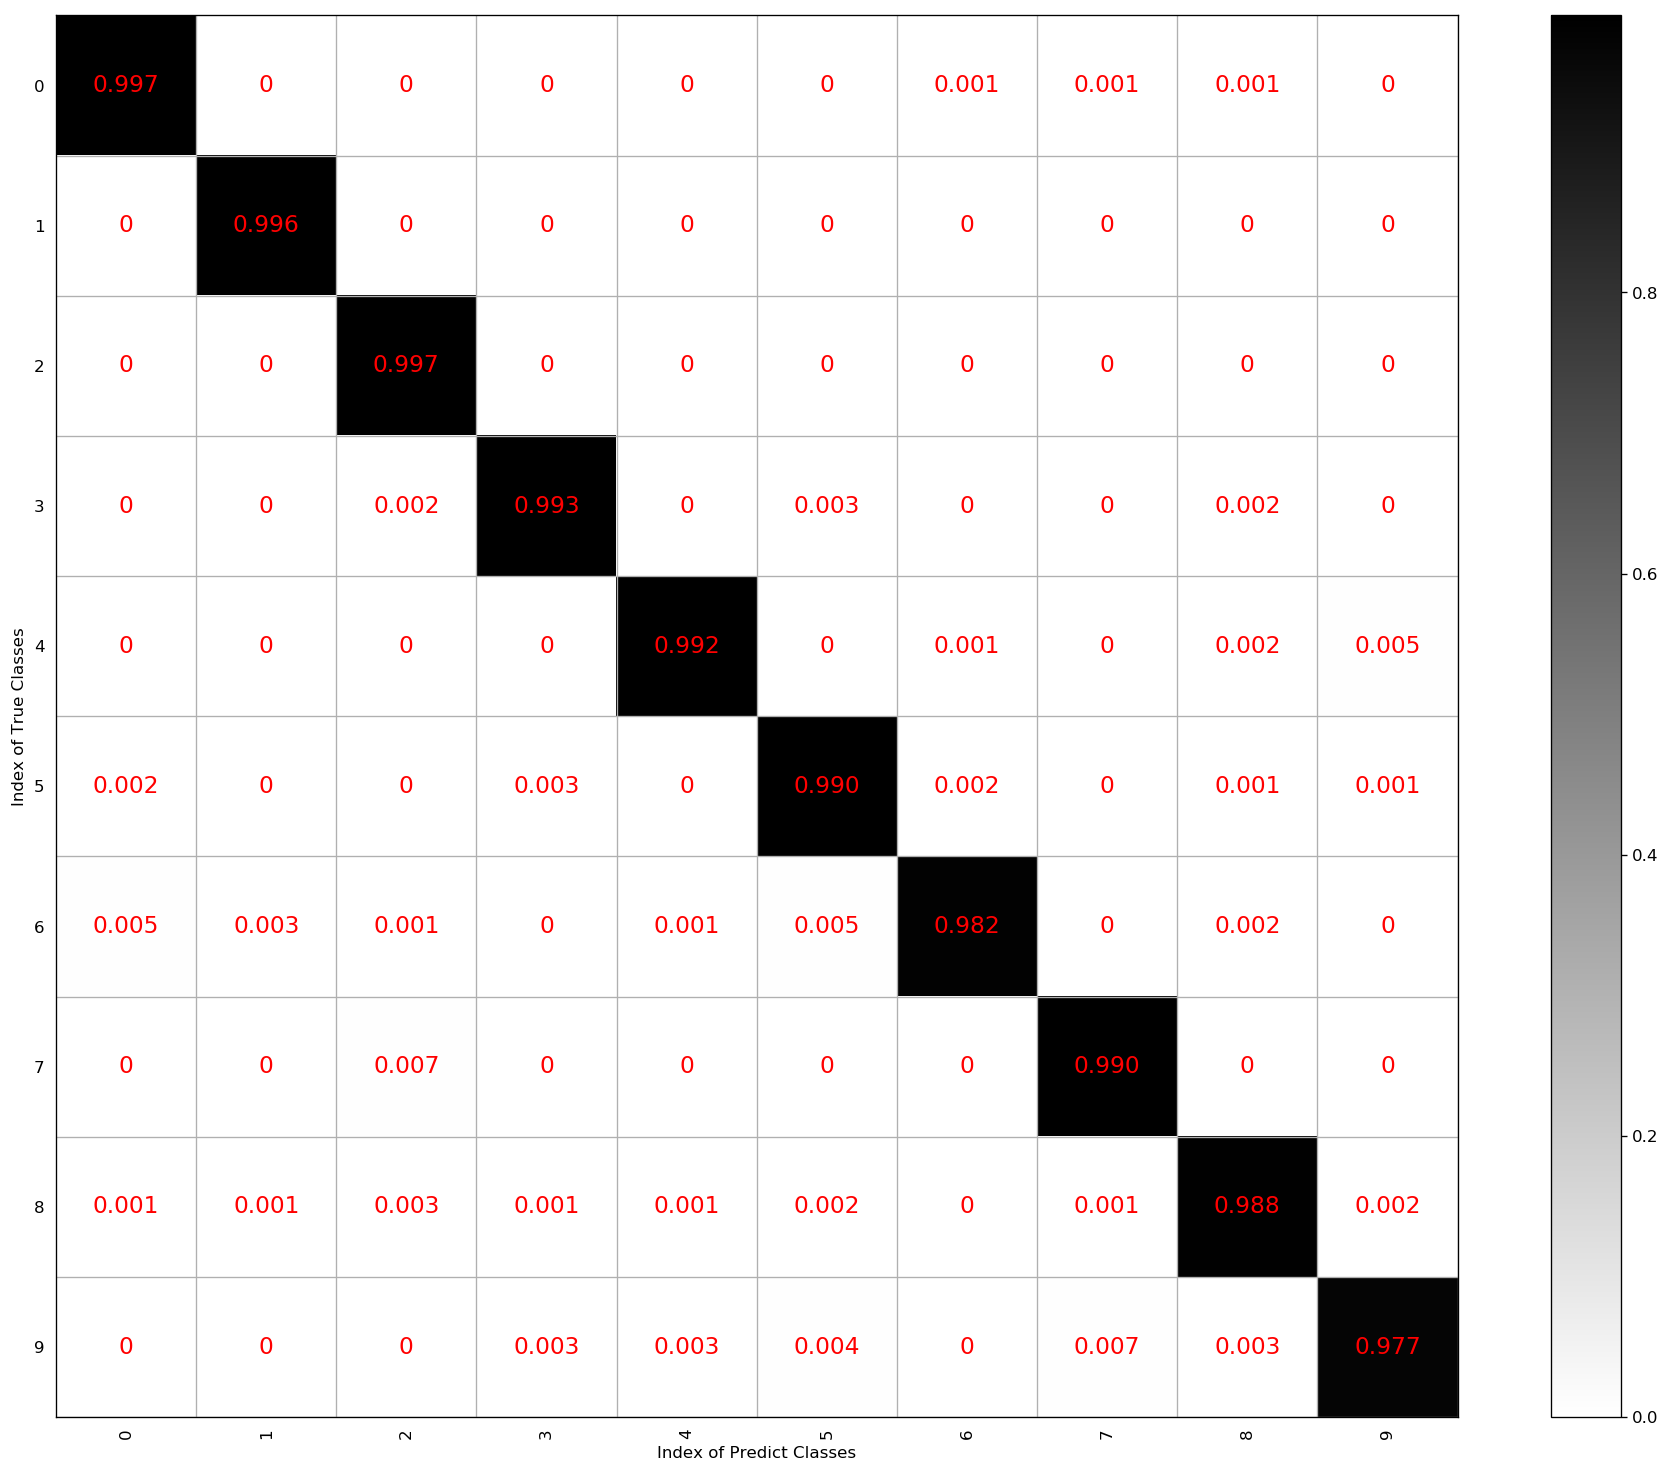

In [45]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeF1_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, False, False])
lenet5_model_with_distr.train(distrs_list = distrs_used_for_training)

2018-05-02 04:23:03,374 - 
        training data set: images = (54000, 28, 28, 1), labels = (54000, 10), distr = [0.098 0.113 0.1   0.103 0.097 0.09  0.099 0.104 0.098 0.098]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
F1
F2
F3
2018-05-02 04:23:03,638 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 130]
	[None, 94]
	[None, 10]
2018-05-02 04:23:04,973 - Training will use max. num_examples = 53760 from training set size = 54000
2018-05-02 04:23:58,648 - EPOCH 1 --- Training: loss = 1.127, acc = 0.618; Validation: loss = 0.249, acc = 0.930; num_examples_used = 44544
2018-05-02 04:24:51,884 - EPOCH 2 --- Training: loss = 0.358, acc = 0.894; Validation: loss = 0.1

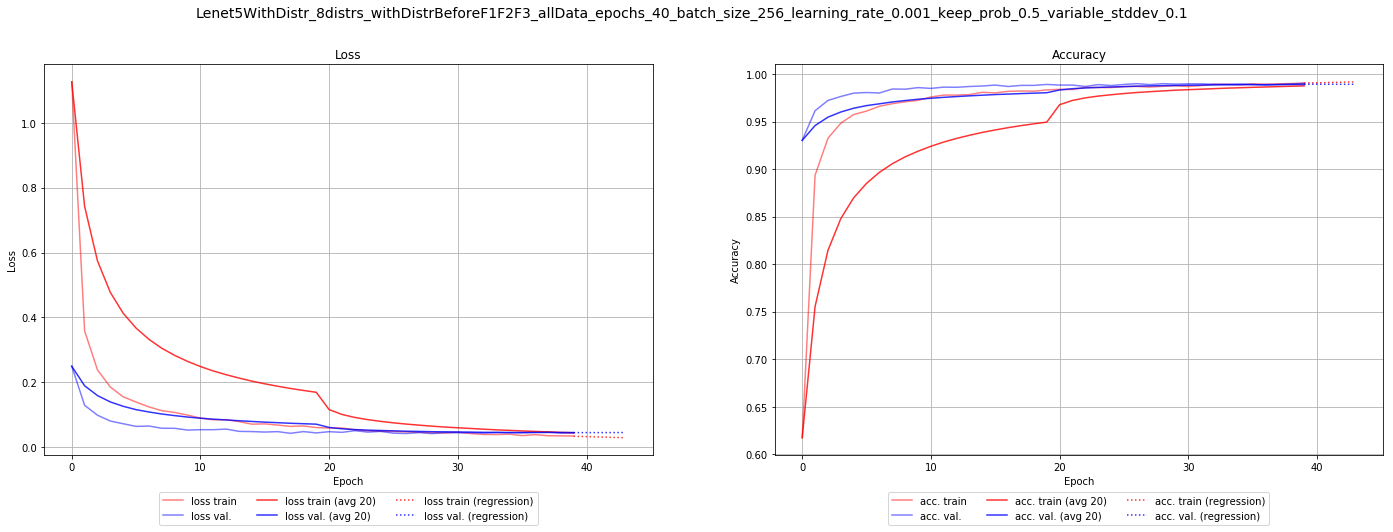

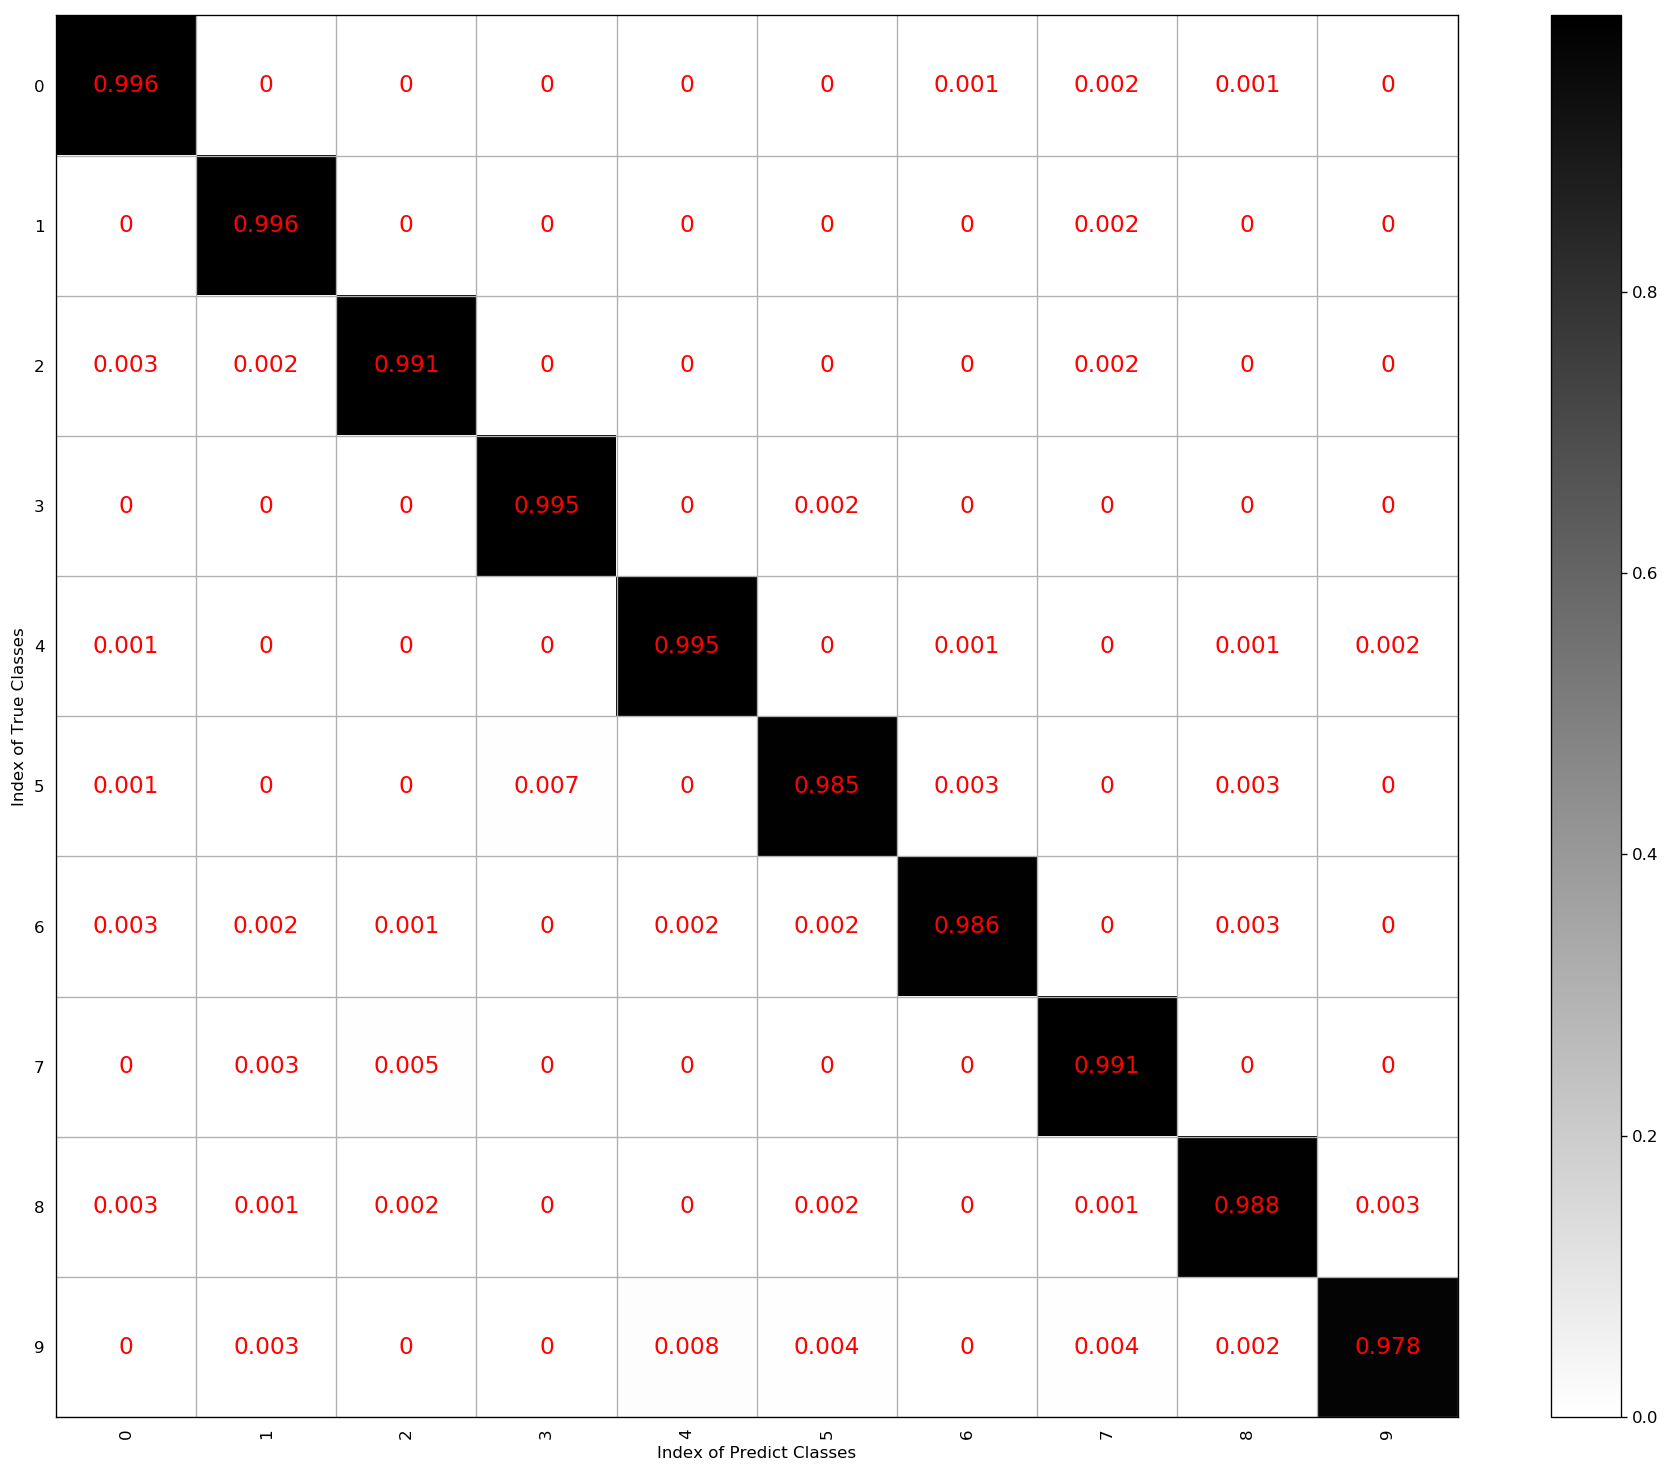

In [46]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeF1F2F3_allData",
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, True, True])
lenet5_model_with_distr.train(distrs_list = distrs_used_for_training)

---
### - train  the above models on only a subset of the original dataset
---

In [157]:
SUBSET_SIZE = 10000

2018-05-21 08:24:22,871 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
2018-05-21 08:24:23,036 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 08:24:24,616 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 08:24:33,304 - EPOCH 1 --- Training: loss = 1.952, acc = 0.317; Validation: loss = 0.970, acc = 0.792; num_examples_used = 9984
2018-05-21 08:24:42,716 - EPOCH 2 --- Training: loss = 0.981, acc = 0.681; Validation: loss = 0.404, acc = 0.894; num_examples_u

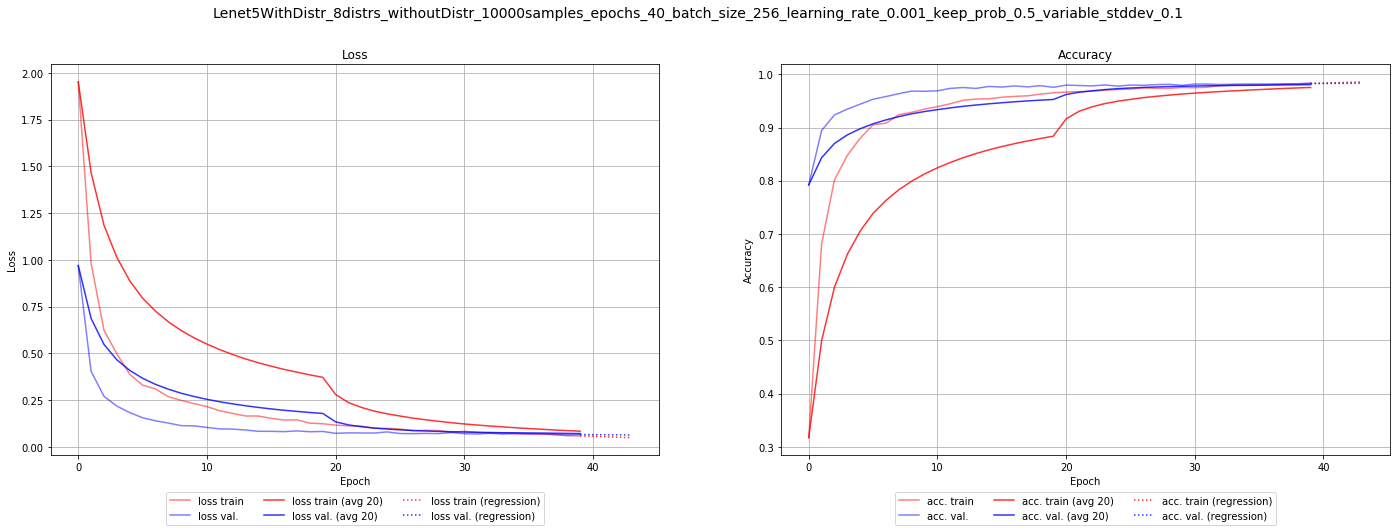

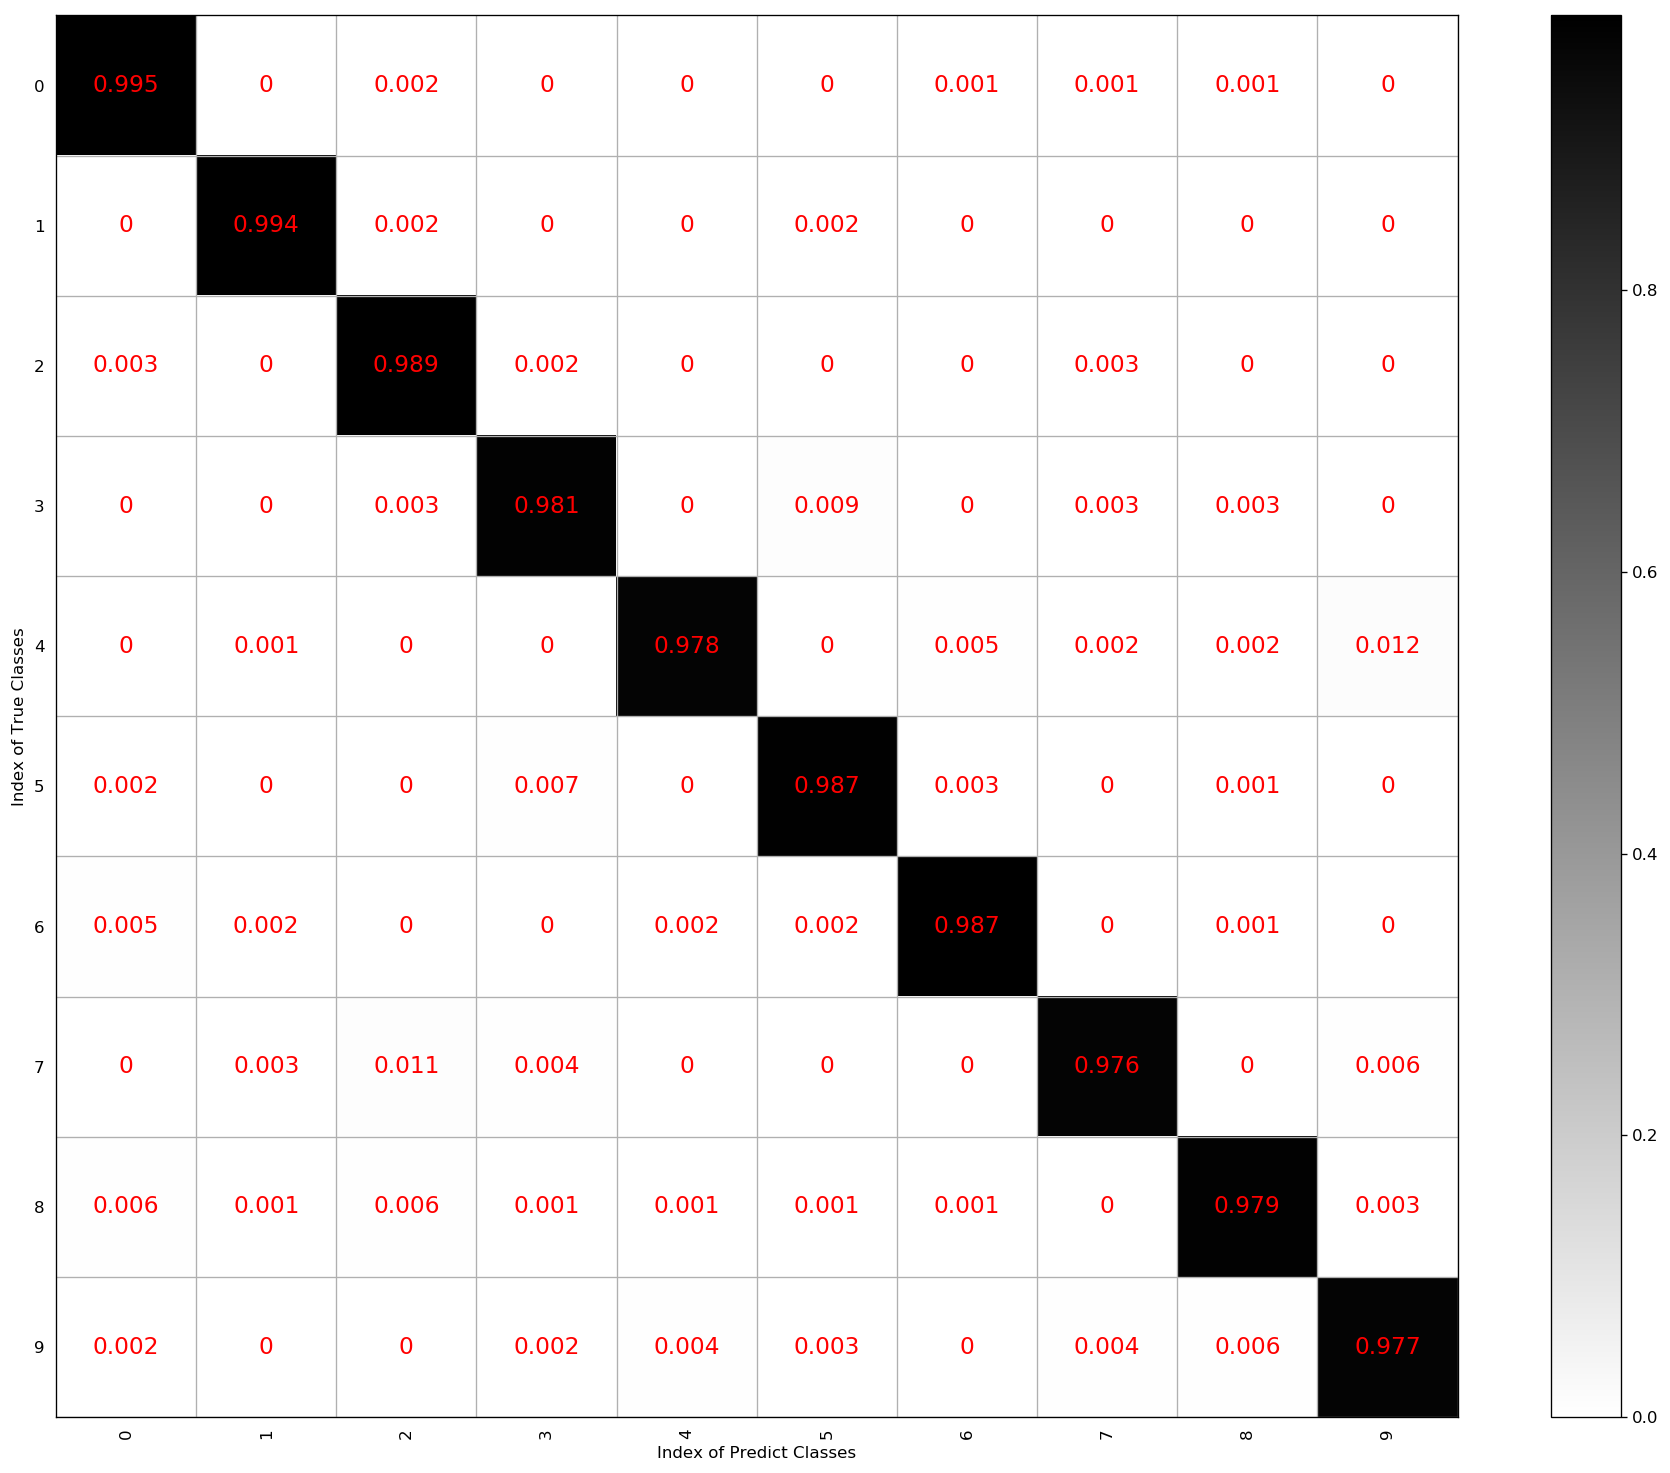

In [158]:
# the following model is trained for reference, without appending the distribution
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withoutDistr_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, False])
lenet5_model_with_distr.train(distrs_list=None)

2018-05-21 08:30:38,797 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before F3
2018-05-21 08:30:38,984 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 400]
	[None, 120]
	[None, 94]
	[None, 10]
2018-05-21 08:30:39,849 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 08:30:48,723 - EPOCH 1 --- Training: loss = 2.196, acc = 0.221; Validation: loss = 1.846, acc = 0.579; num_examples_used = 8704
2018-05-21 08:30:57,599 - EPOCH 2 --- Training: loss = 1.534, acc = 0.501; Validation: loss = 0.720, a

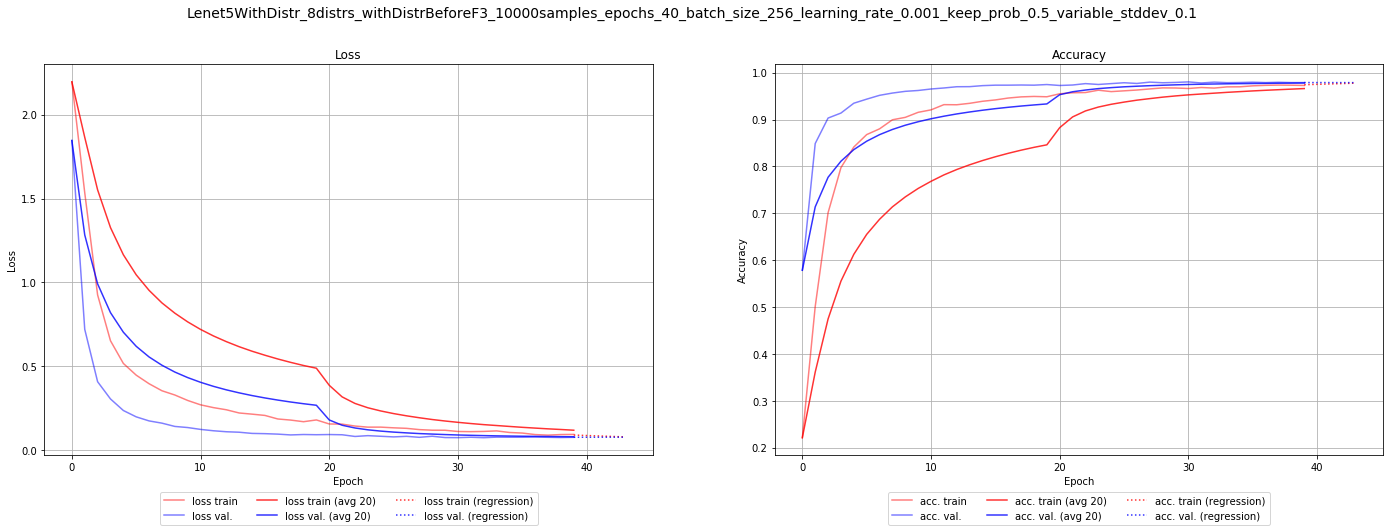

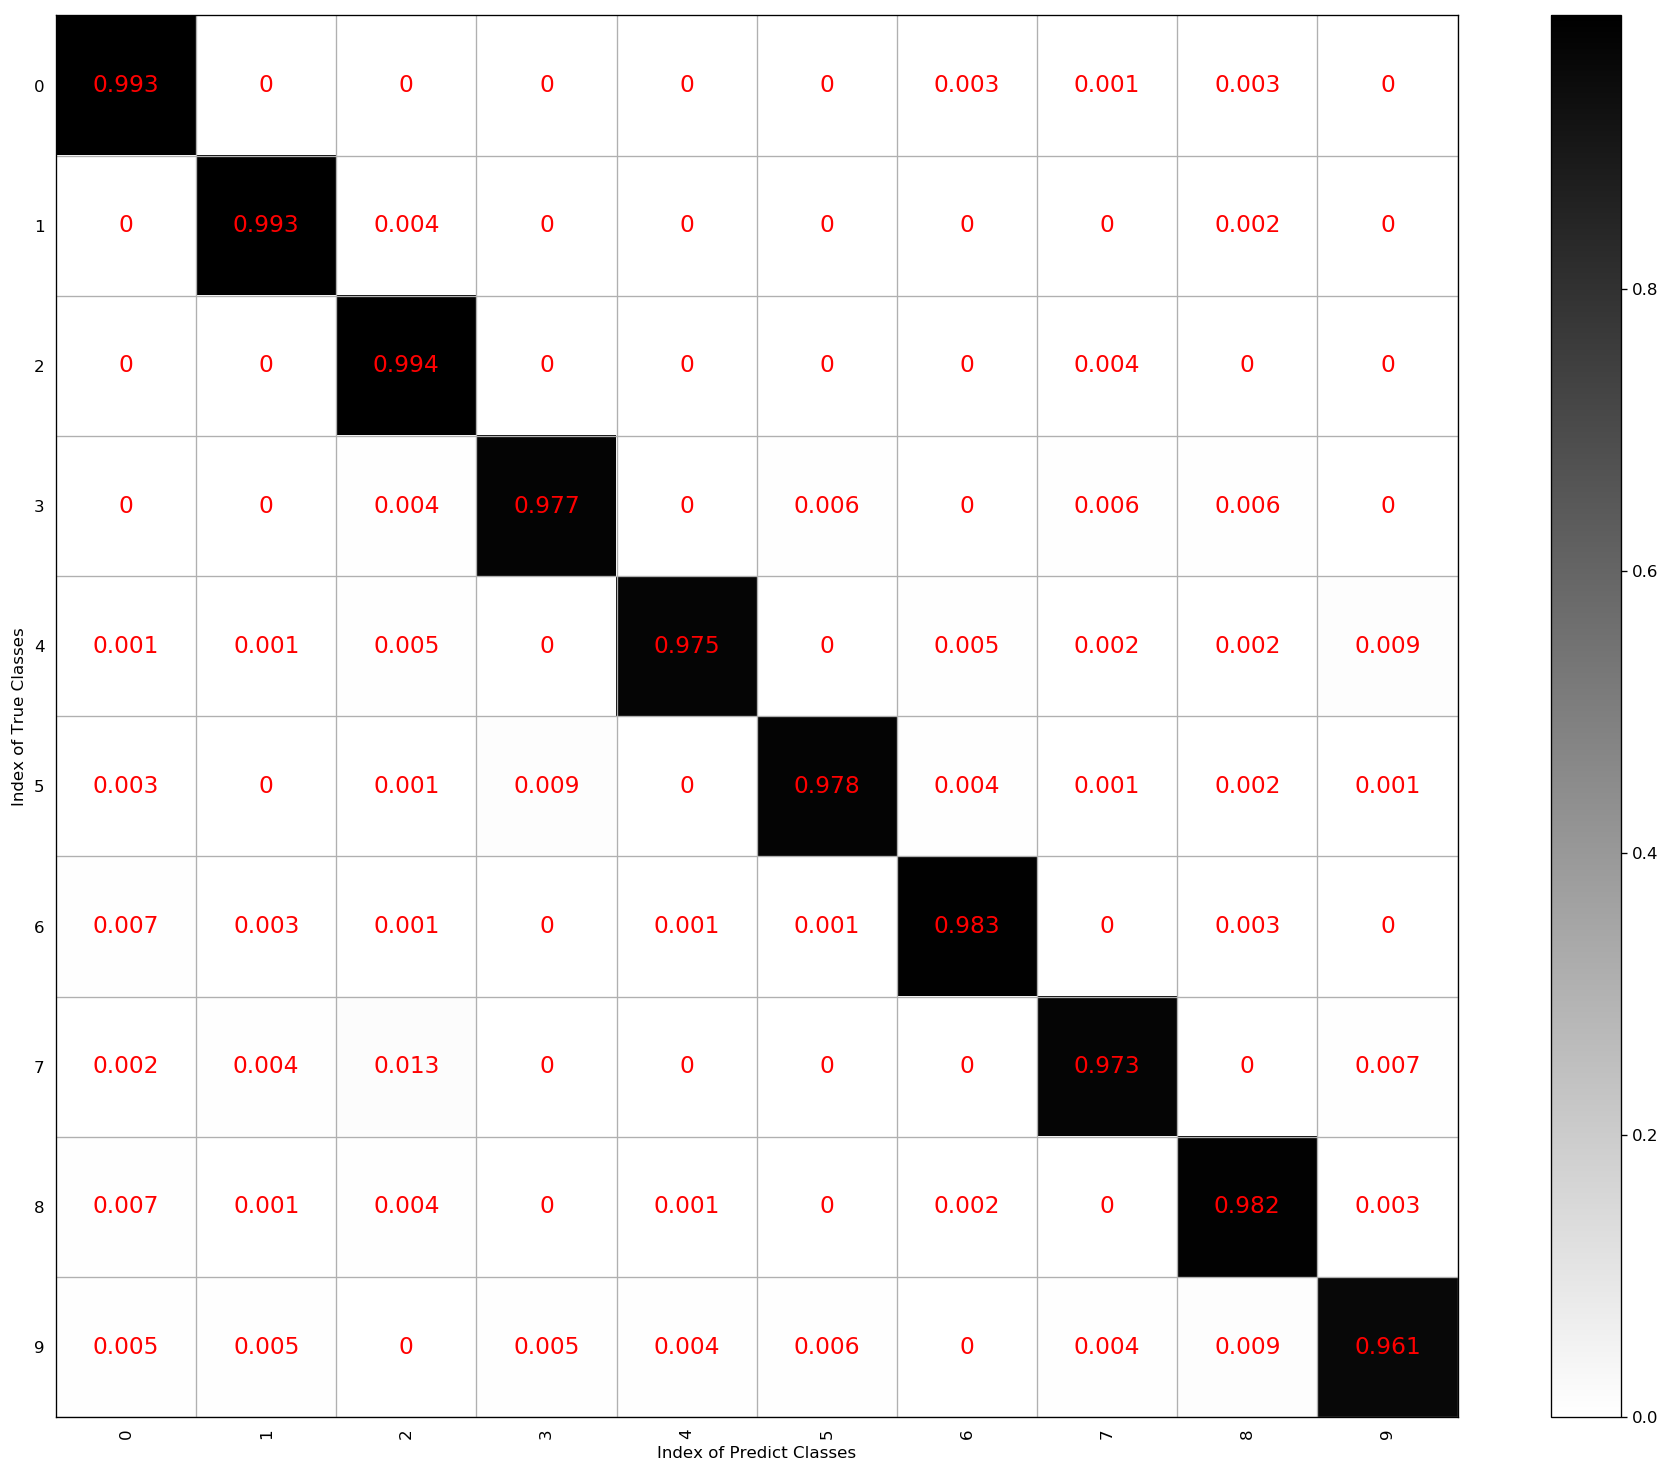

In [159]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeF3_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, False, False, True])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

2018-05-21 08:36:47,270 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before F1
2018-05-21 08:36:47,444 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 08:36:48,281 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 08:36:57,068 - EPOCH 1 --- Training: loss = 2.180, acc = 0.238; Validation: loss = 1.766, acc = 0.675; num_examples_used = 8704
2018-05-21 08:37:05,856 - EPOCH 2 --- Training: loss = 1.456, acc = 0.532; Validation: loss = 0.649, a

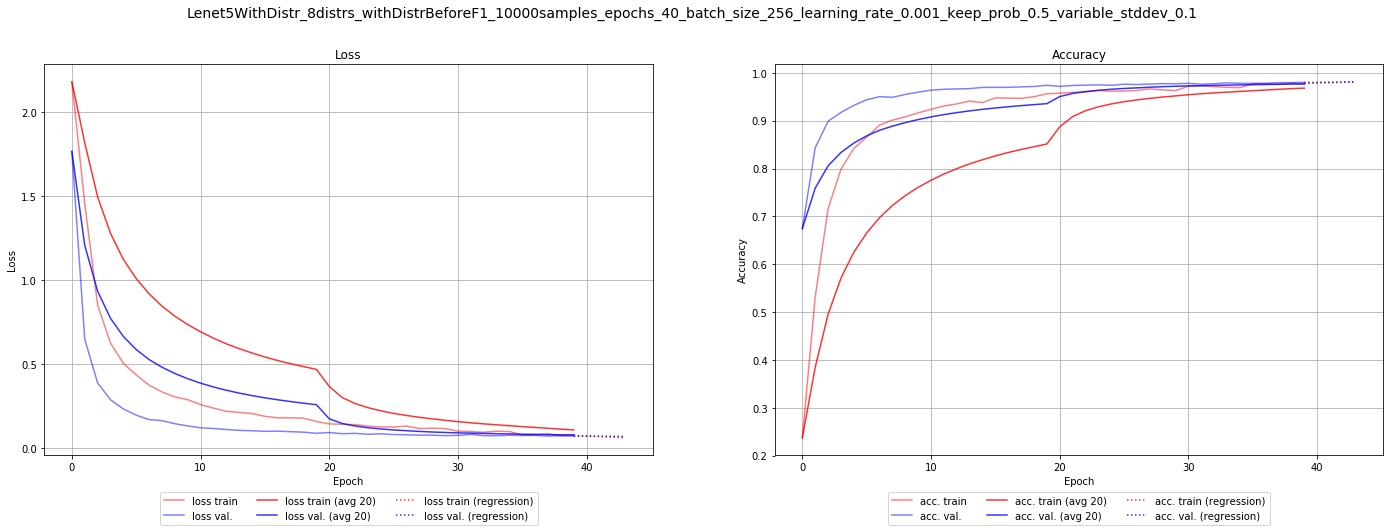

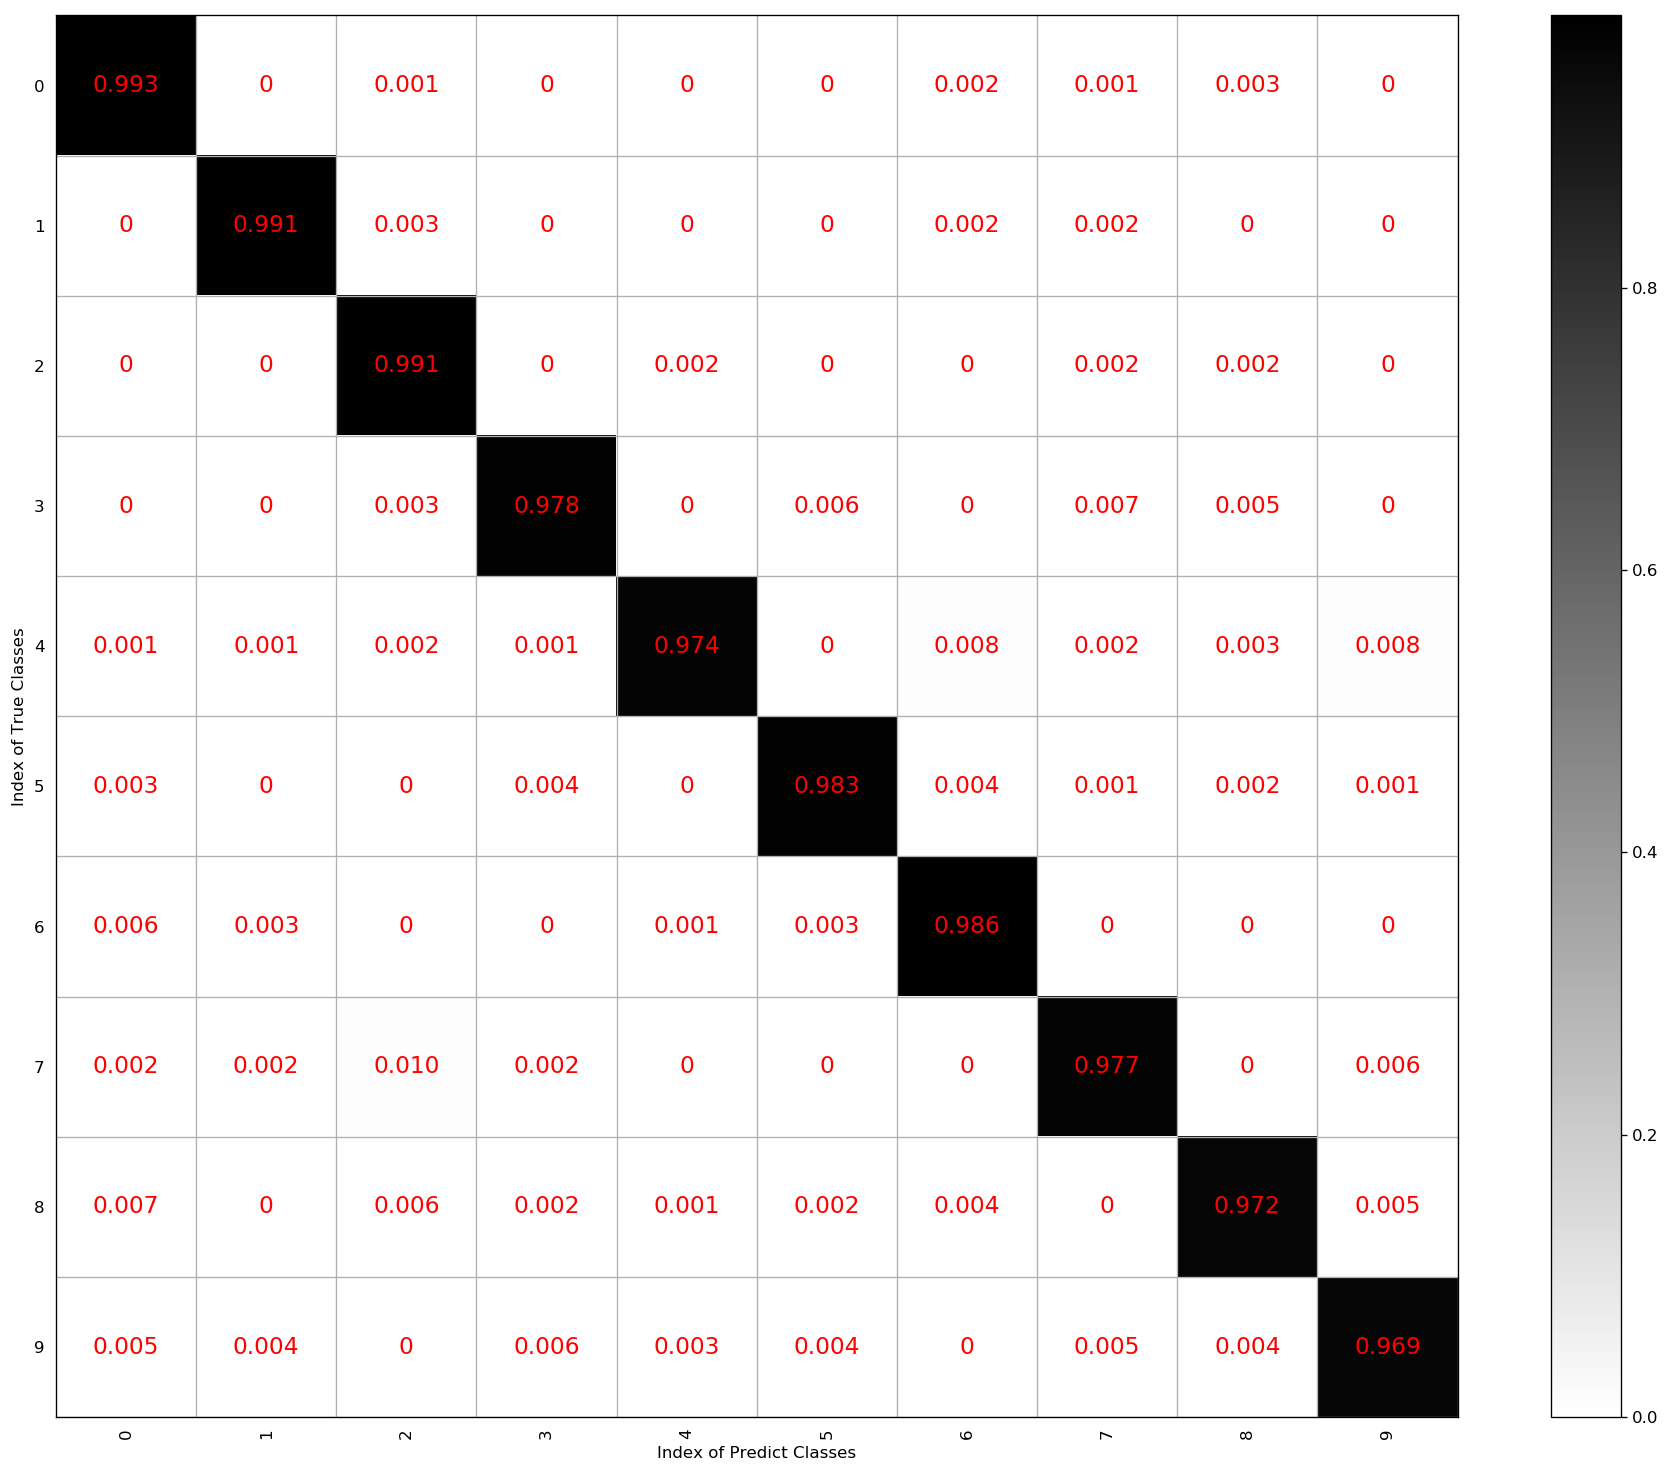

In [160]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeF1_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, False, False])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

2018-05-21 08:42:55,072 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before F1
Attached distr. before F2
Attached distr. before F3
2018-05-21 08:42:55,268 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 14, 14, 6]
	[None, 10, 10, 16]
	[None, 410]
	[None, 130]
	[None, 94]
	[None, 10]
2018-05-21 08:42:56,145 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 08:43:04,982 - EPOCH 1 --- Training: loss = 2.197, acc = 0.210; Validation: loss = 1.769, acc = 0.729; num_examples_used = 8704
2018-05-21 08:43:13,742 - EPOCH 2 --- Training: lo

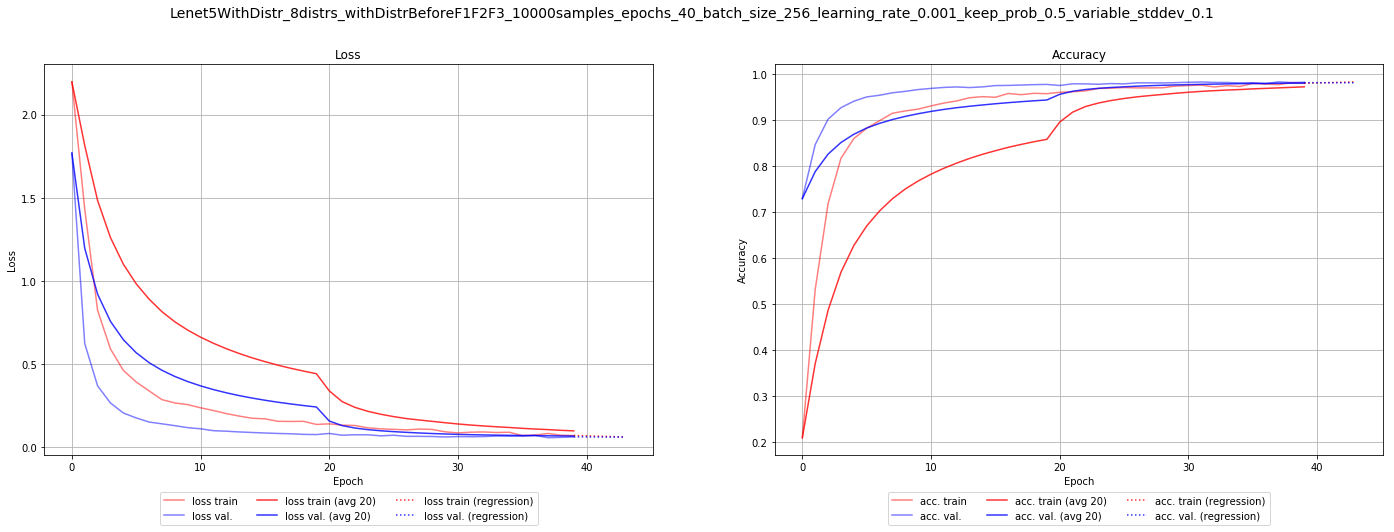

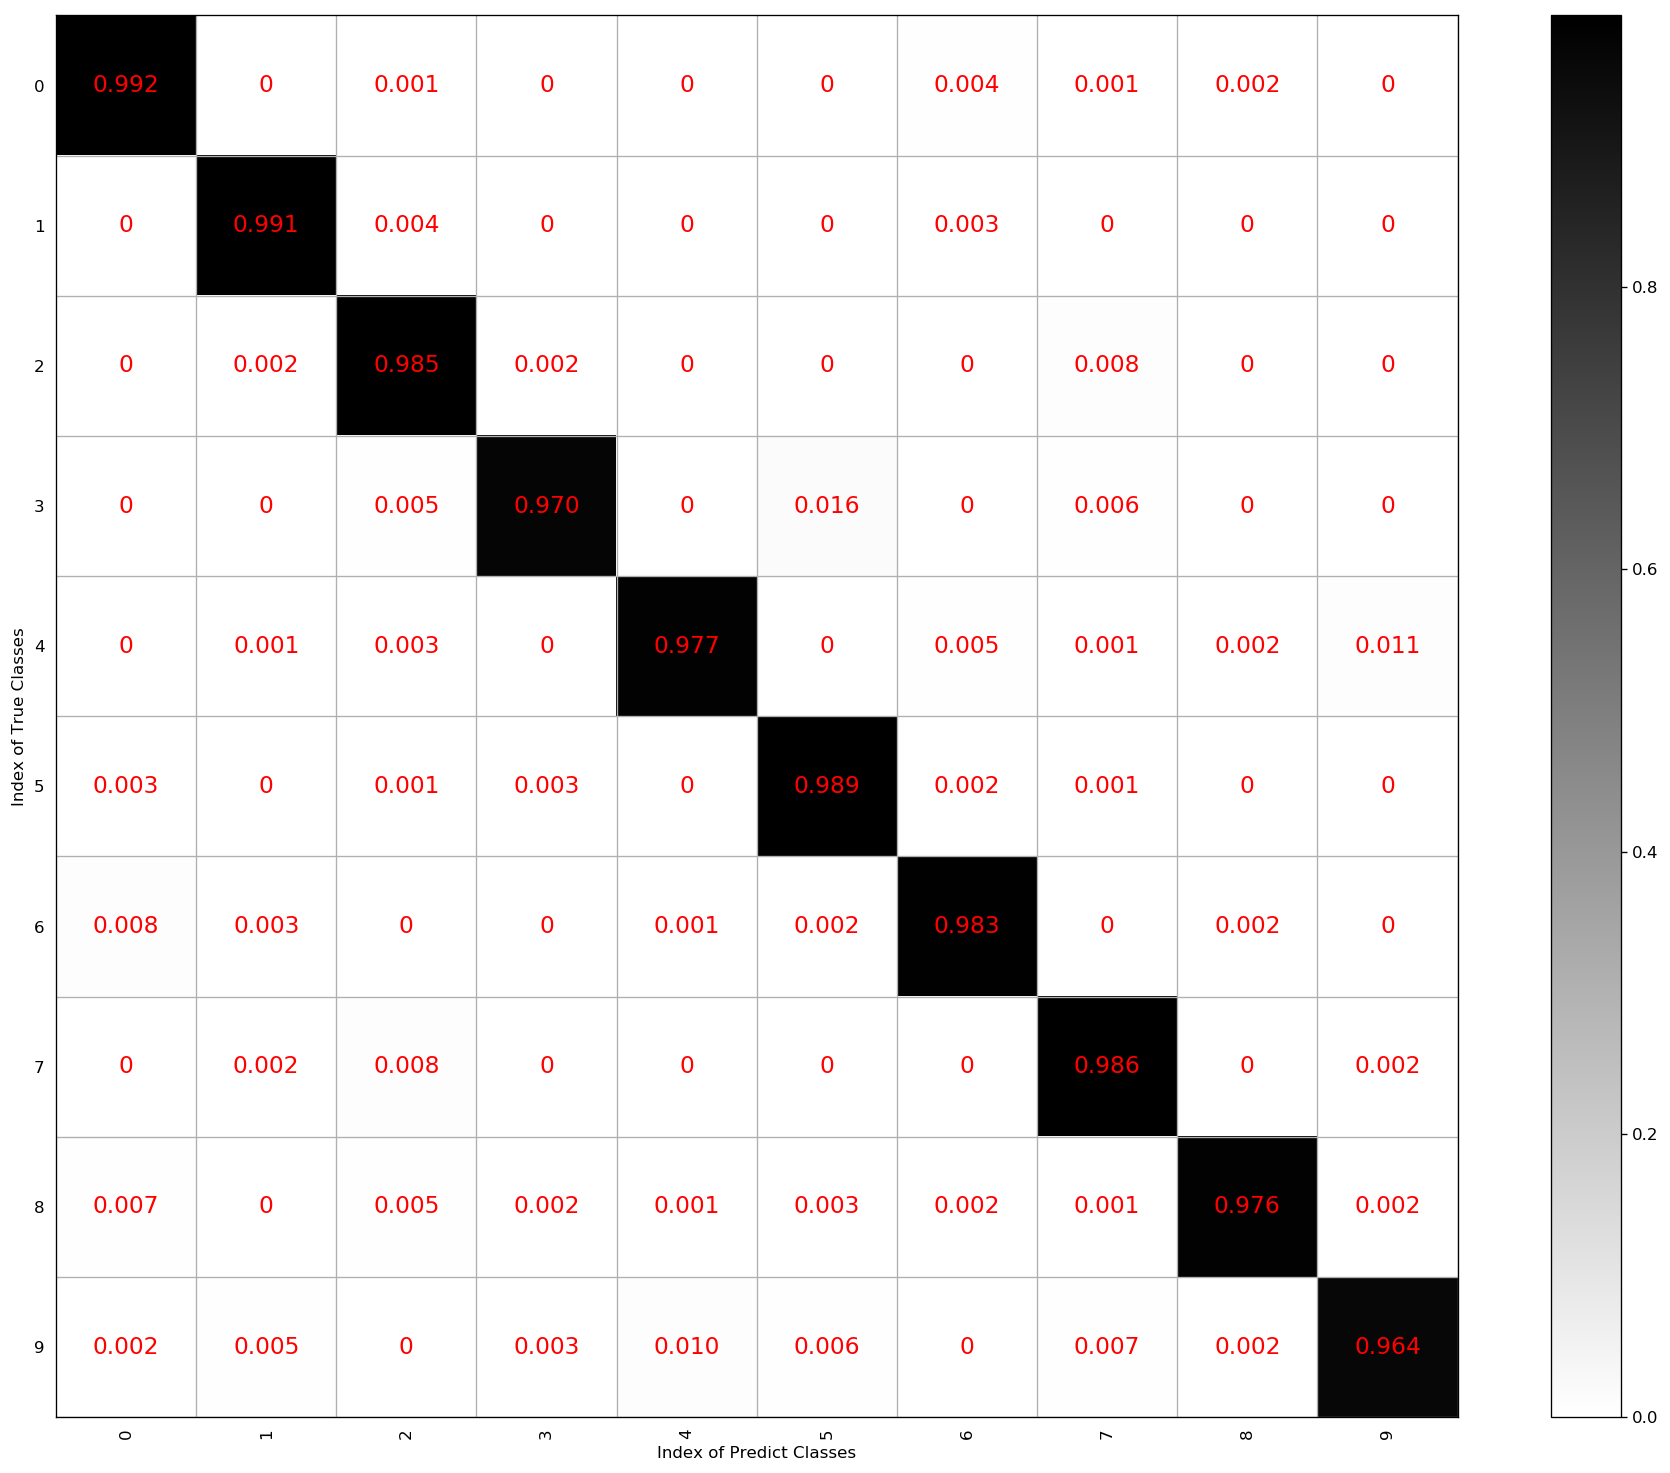

In [161]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeF1F2F3_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, False, True, True, True])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

2018-05-21 08:49:09,534 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C1 (at input)
2018-05-21 08:49:10,128 - Network layers size:
	[None, 29, 28, 1]
	[None, 29, 28, 6]
	[None, 15, 14, 6]
	[None, 11, 10, 16]
	[None, 480]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 08:49:10,965 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 08:49:20,783 - EPOCH 1 --- Training: loss = 2.135, acc = 0.237; Validation: loss = 1.533, acc = 0.649; num_examples_used = 8704
2018-05-21 08:49:30,037 - EPOCH 2 --- Training: loss = 1.351, acc = 0.553; Validation: loss

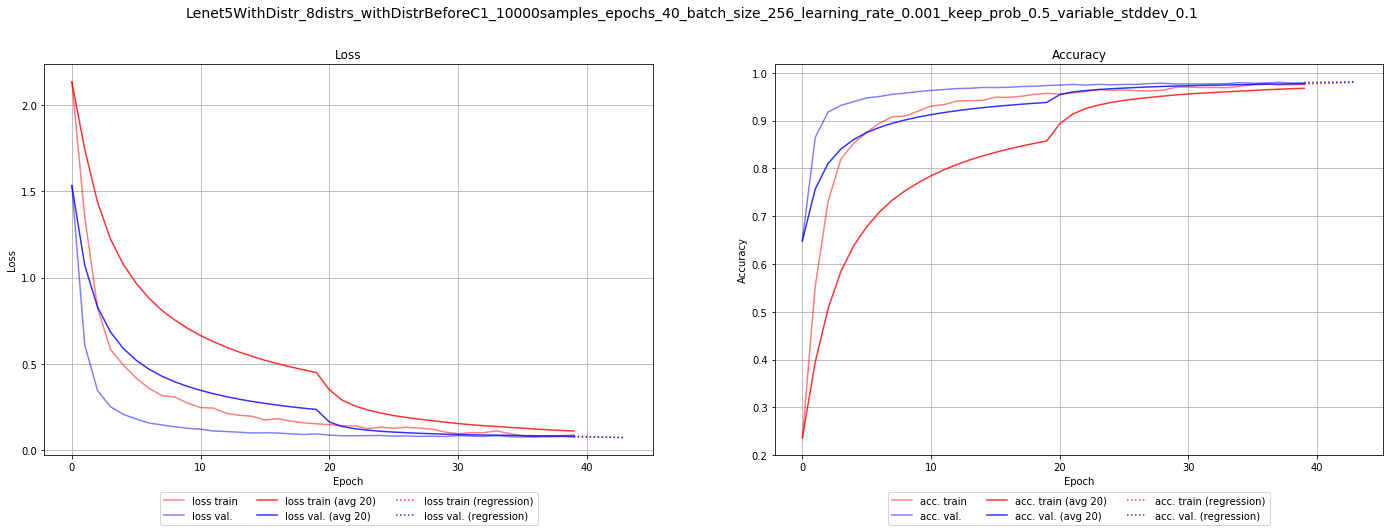

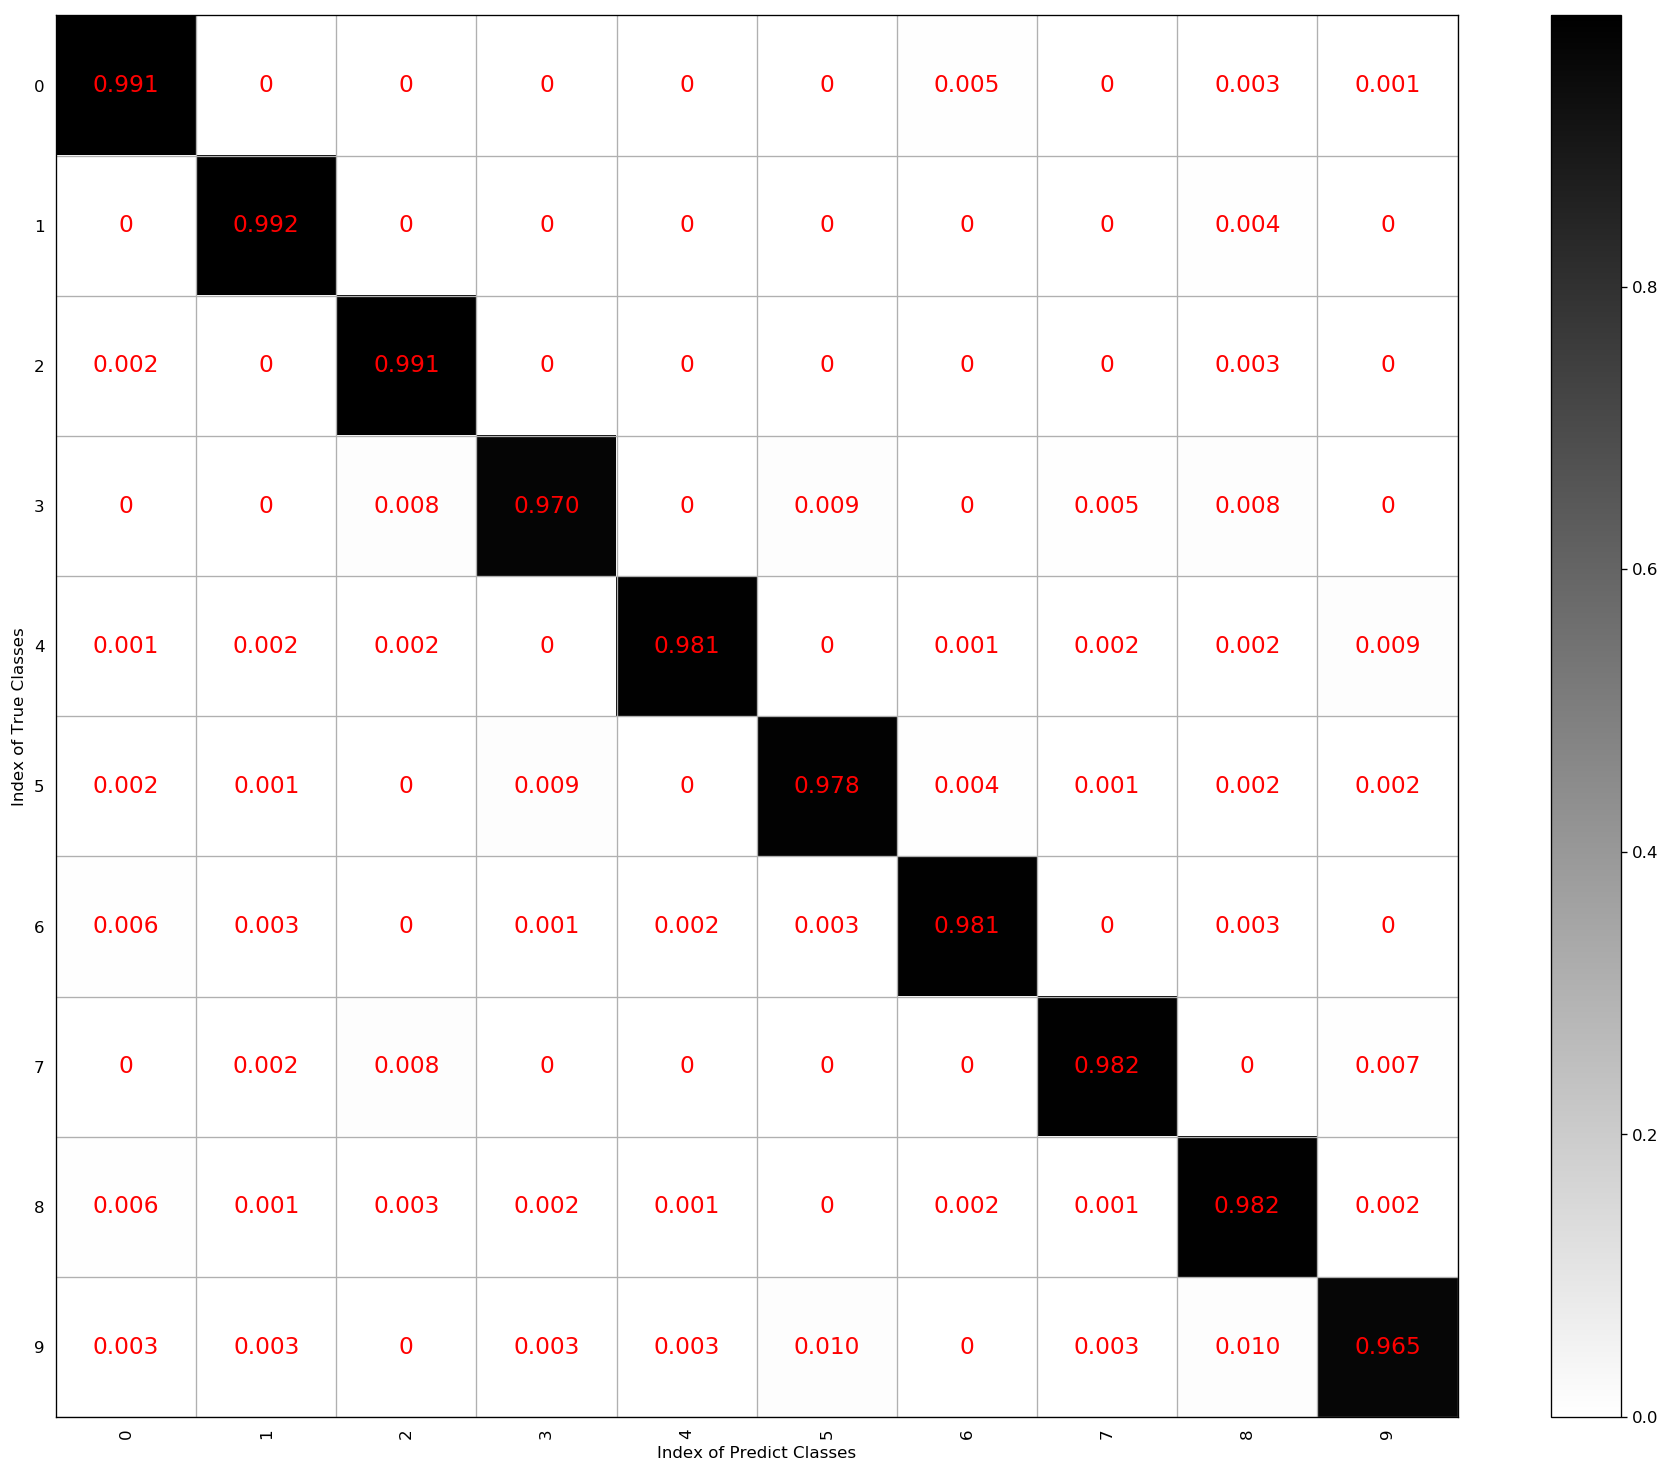

In [162]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeC1_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [True, False, False, False, False])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

2018-05-21 08:55:46,377 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C2
2018-05-21 08:55:46,649 - Network layers size:
	[None, 28, 28, 1]
	[None, 28, 28, 6]
	[None, 15, 14, 6]
	[None, 11, 10, 16]
	[None, 480]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 08:55:47,671 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 08:55:57,917 - EPOCH 1 --- Training: loss = 2.148, acc = 0.234; Validation: loss = 1.617, acc = 0.622; num_examples_used = 8704
2018-05-21 08:56:07,531 - EPOCH 2 --- Training: loss = 1.433, acc = 0.516; Validation: loss = 0.723, a

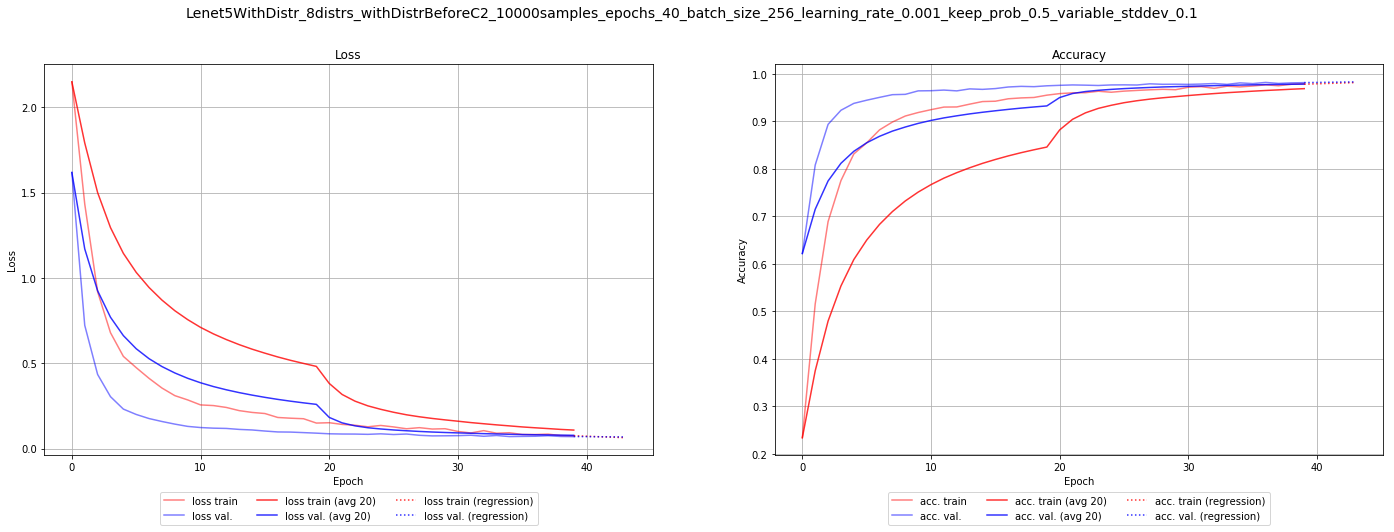

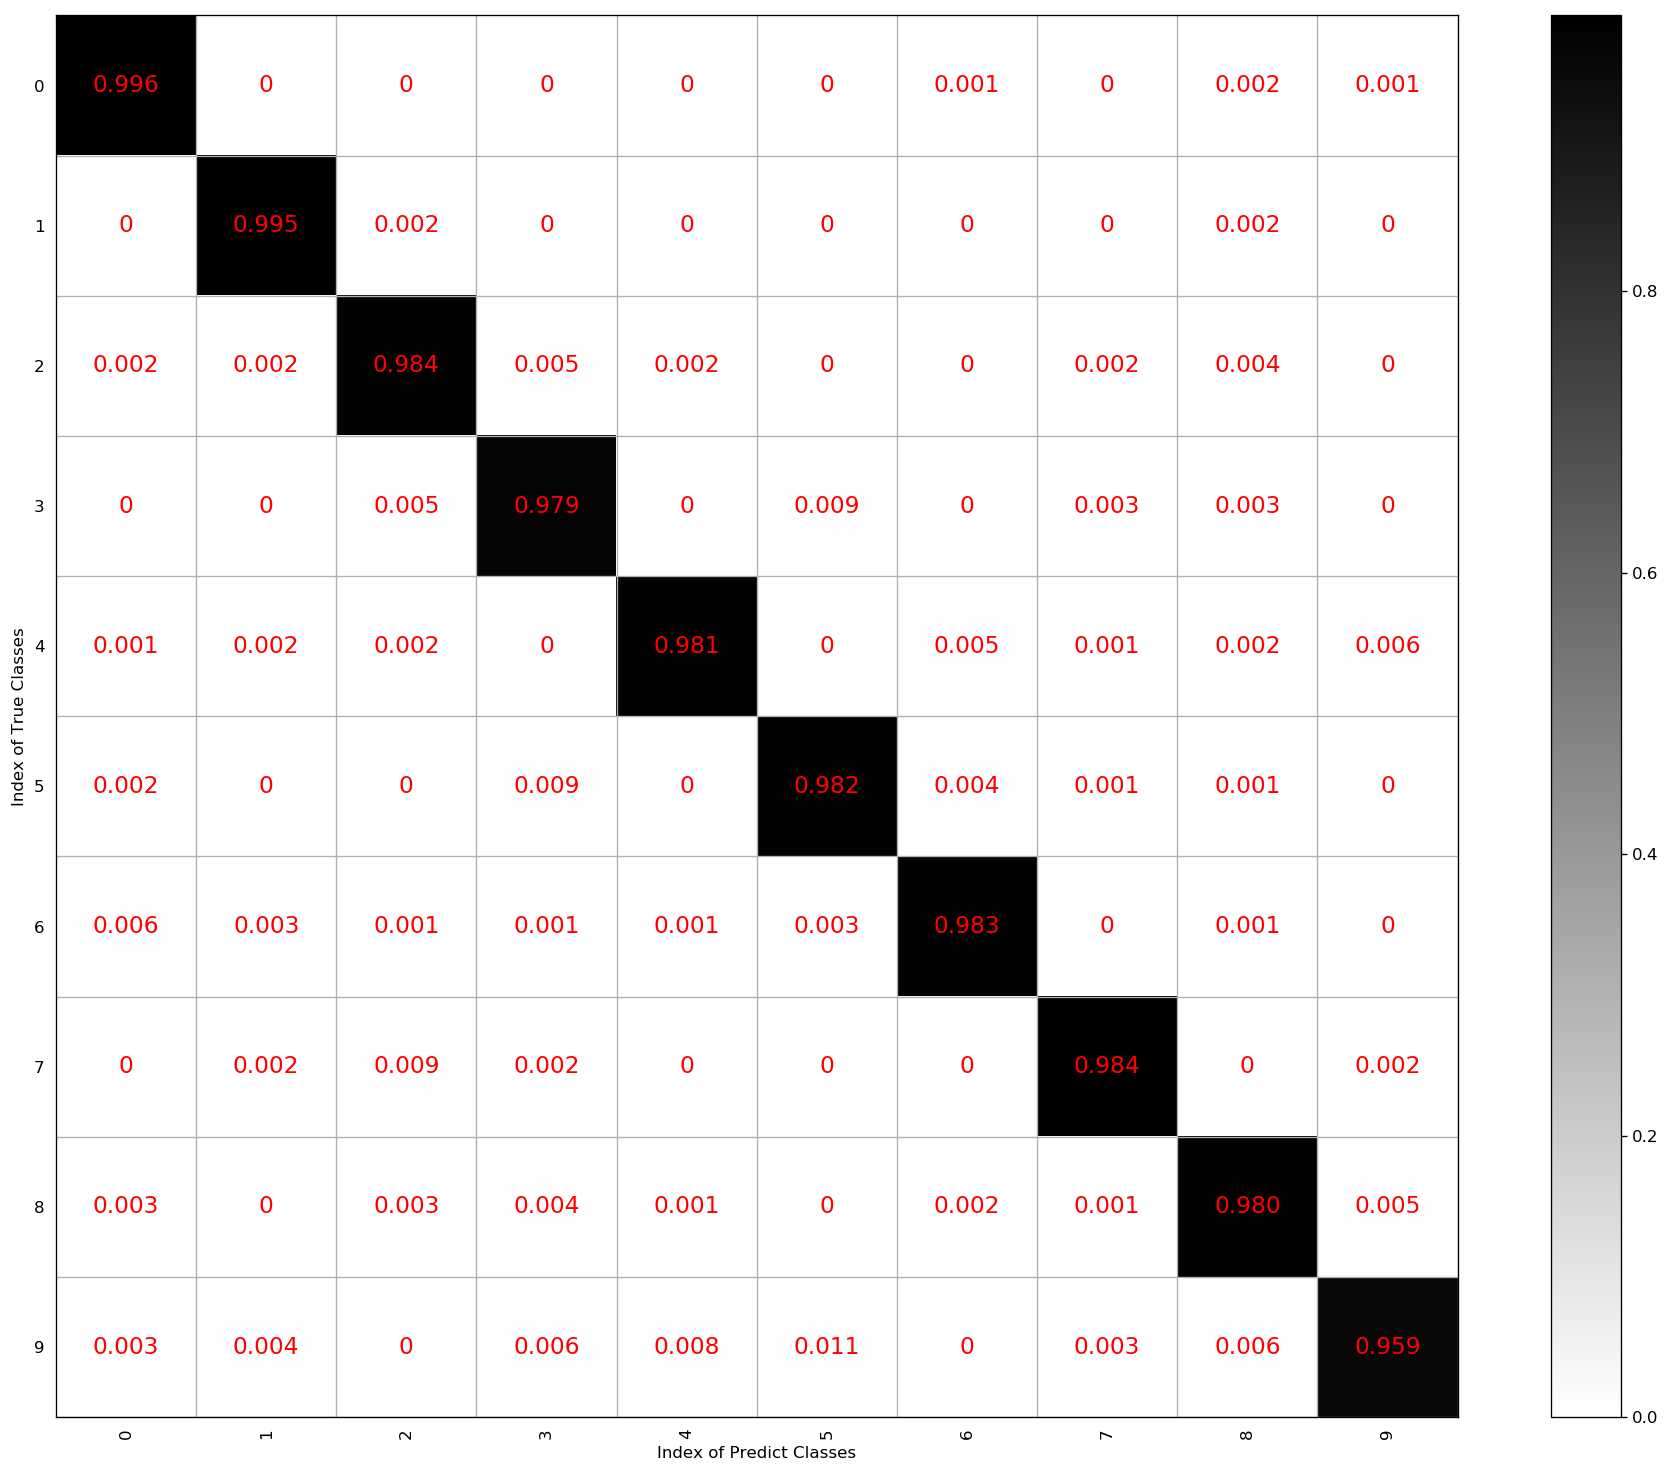

In [163]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeC2_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [False, True, False, False, False])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

2018-05-21 09:02:29,665 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C1 (at input)
Attached distr. before C2
2018-05-21 09:02:29,962 - Network layers size:
	[None, 29, 28, 1]
	[None, 29, 28, 6]
	[None, 16, 14, 6]
	[None, 12, 10, 16]
	[None, 480]
	[None, 120]
	[None, 84]
	[None, 10]
2018-05-21 09:02:31,384 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 09:02:42,165 - EPOCH 1 --- Training: loss = 2.116, acc = 0.246; Validation: loss = 1.520, acc = 0.678; num_examples_used = 8704
2018-05-21 09:02:52,679 - EPOCH 2 --- Training: loss = 1.418, acc

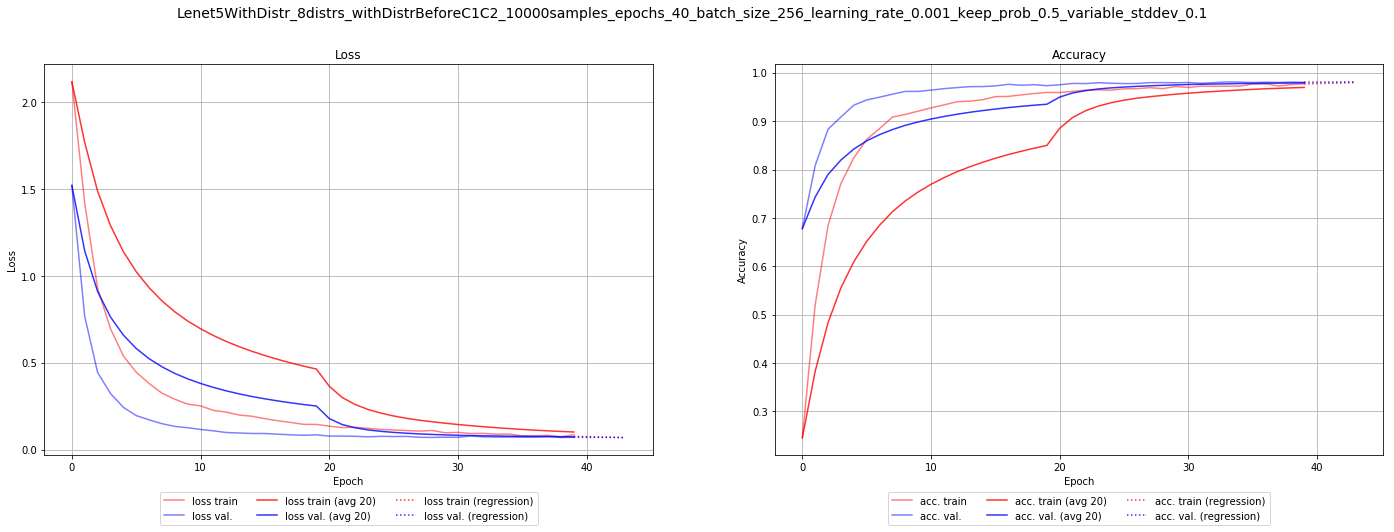

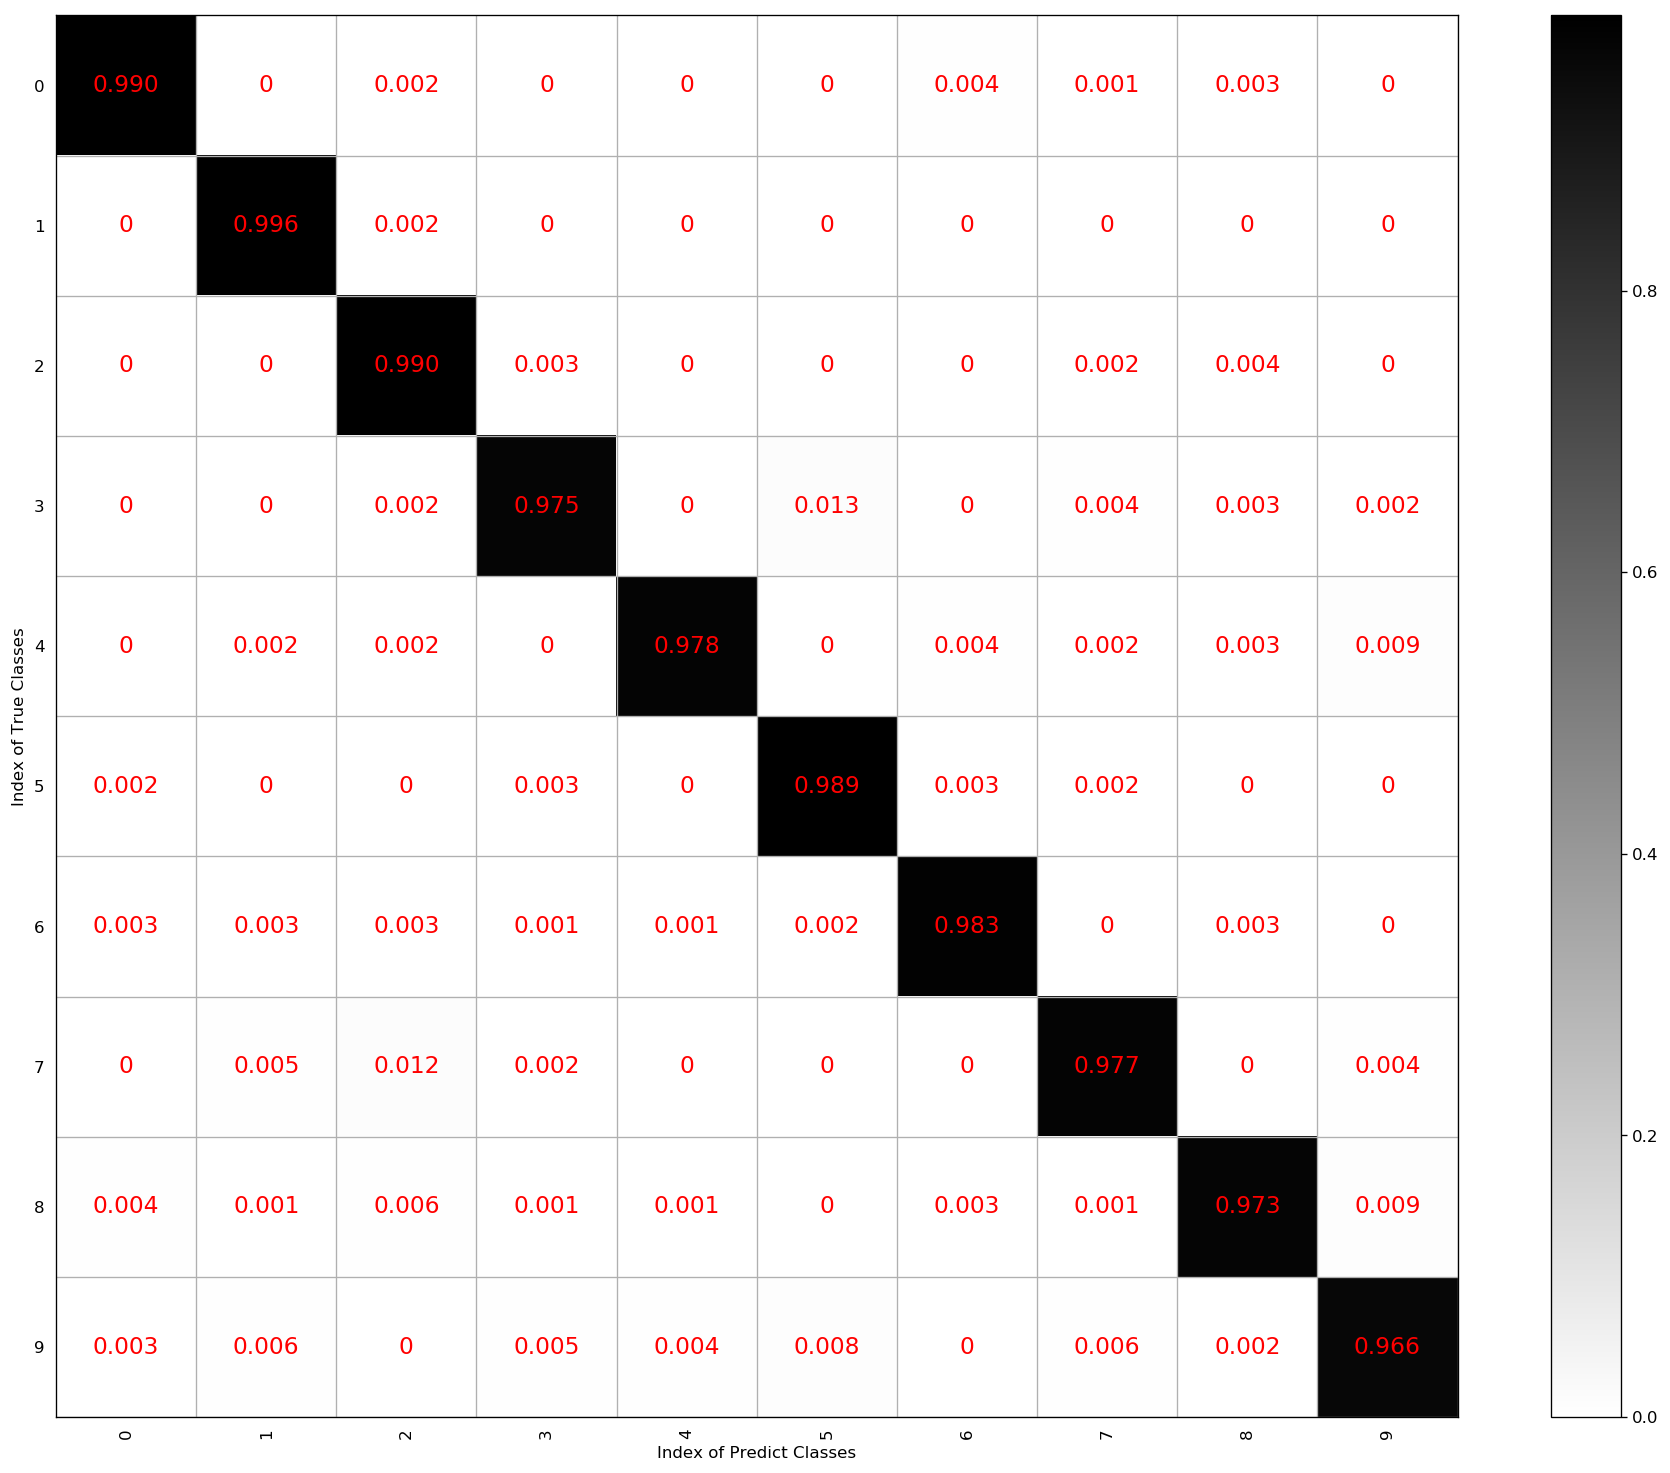

In [164]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeC1C2_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [True, True, False, False, False])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

2018-05-21 09:09:54,491 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        
Attached distr. before C1 (at input)
Attached distr. before C2
Attached distr. before F1
Attached distr. before F2
Attached distr. before F3
2018-05-21 09:09:54,813 - Network layers size:
	[None, 29, 28, 1]
	[None, 29, 28, 6]
	[None, 16, 14, 6]
	[None, 12, 10, 16]
	[None, 490]
	[None, 130]
	[None, 94]
	[None, 10]
2018-05-21 09:09:55,935 - Training will use max. num_examples = 9984 from training set size = 10000
2018-05-21 09:10:06,483 - EPOCH 1 --- Training: loss = 2.192, acc = 0.211; Validation: loss = 1.795, acc = 0.692; num_examples

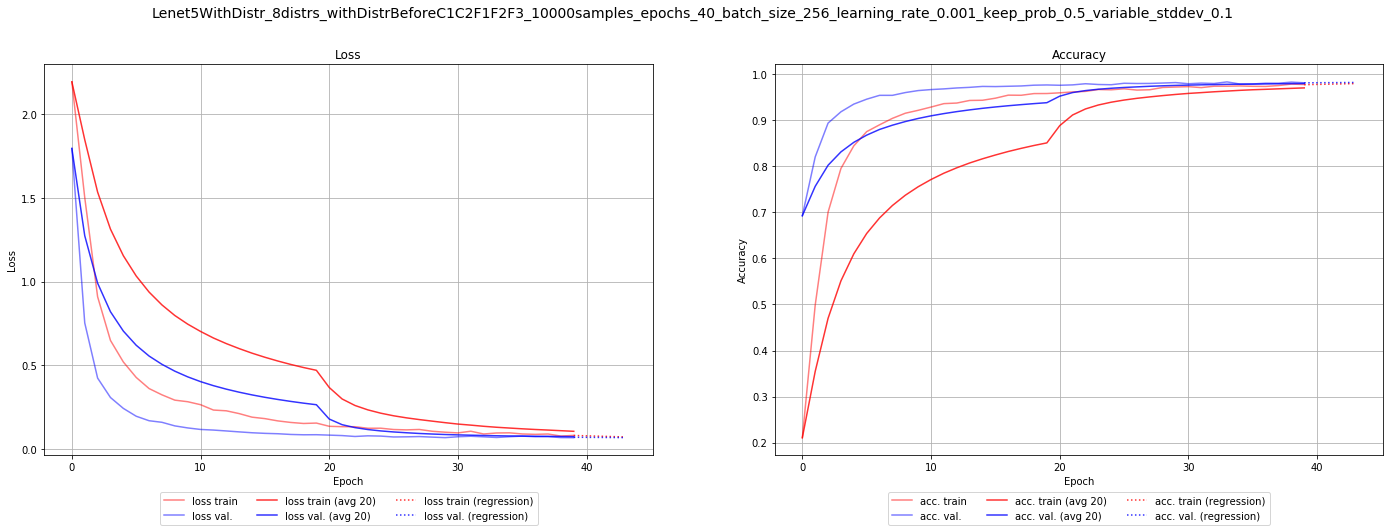

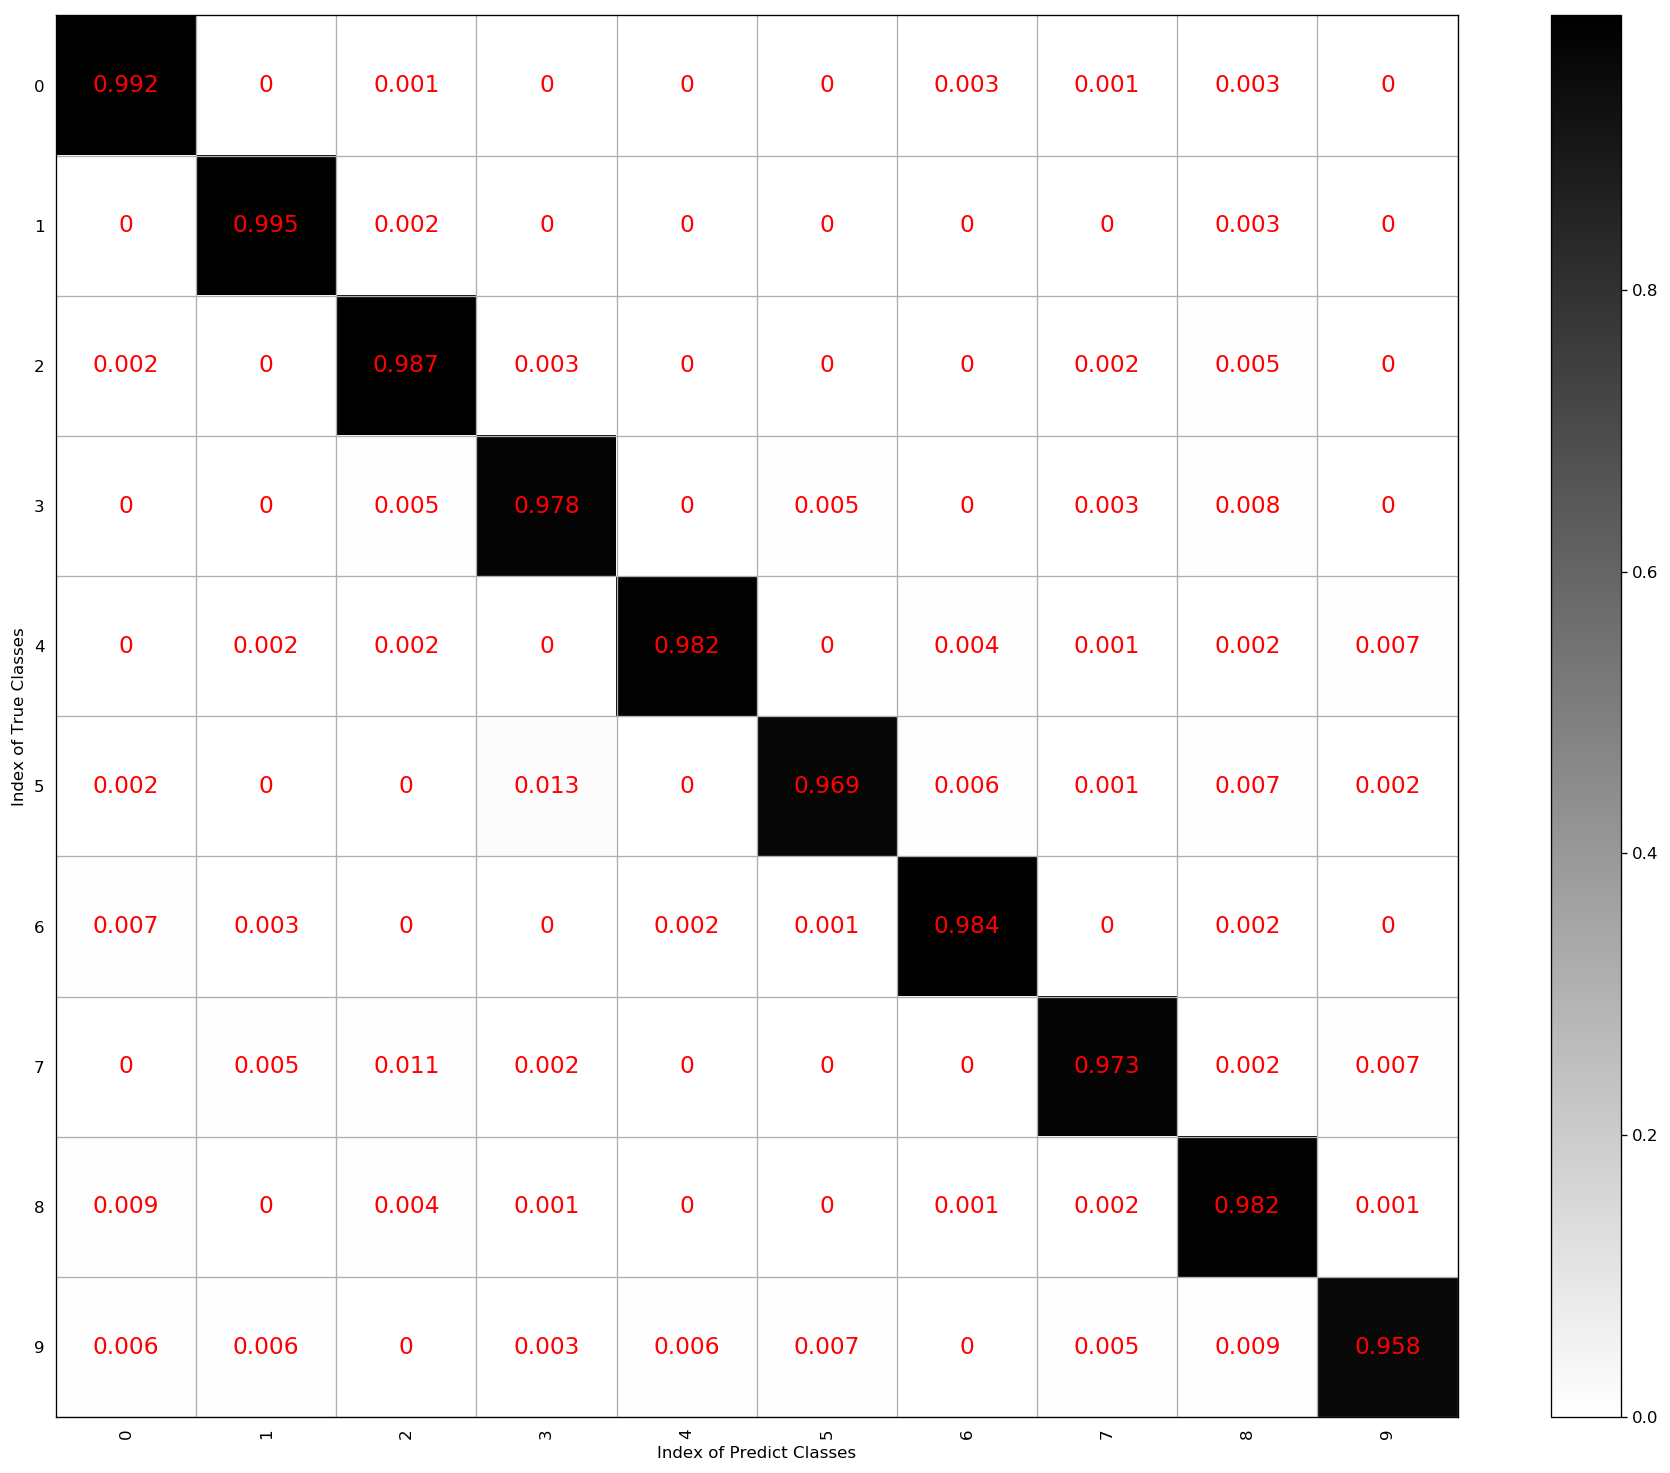

In [165]:
mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds.impose_distr_on_train_dataset(subset_size=SUBSET_SIZE, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

lenet5_model_with_distr = Lenet5WithDistr(mnist_ds, "8distrs_withDistrBeforeC1C2F1F2F3_{}samples".format(SUBSET_SIZE),
              epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1,
              learning_rate=0.001,
              drop_out_keep_prob=0.5,
              distr_pos = [True, True, True, True, True])
lenet5_model_with_distr.train(distrs_list=distrs_used_for_training)

---
### - restore and test the adapted models on subsets with different distributions; save the results to file
---

Restoring model 1 from Lenet5_8distrs_withDistrBeforeF3_10000samples_2018_05_21---08_30.model.ckpt
The restored model 1 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [False False False False  True]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.981
images sum 1038915.0
test_acc = 0.981 (9810/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 1 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9999726e-01 8.2350675e-11 4.3769708e-07 8.5299998e-09 8.3603569e-09 1.2774608e-07 3.9459908e-07 6.1940327e-08 2.0004633e-07 1.3978856e-06]]
indices_wrt_distr =  [ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
np.sum(indices_wrt_distr) =  4520886
[

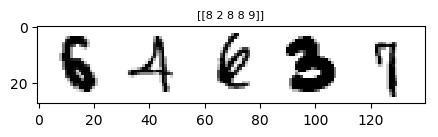

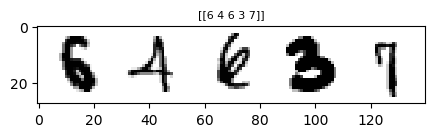

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.104, test_acc = 0.975 (2926/3000)
my test_acc = 0.975 = (2926/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 1 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9999726e-01 8.2350675e-11 4.3769708e-07 8.5299998e-09 8.3603569e-09 1.2774608e-07 3.9459908e-07 6.1940327e-08 2.0004633e-07 1.3978856e-06]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

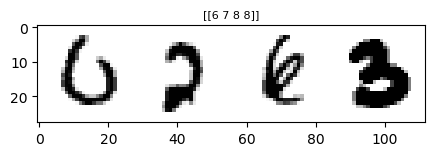

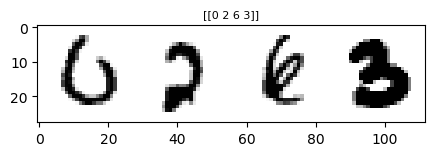

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.072, test_acc = 0.980 (2939/3000)
my test_acc = 0.980 = (2939/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 1 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[1.1025946e-10 9.9999976e-01 6.1232285e-08 1.1187588e-09 2.6348488e-08 1.1113024e-09 3.3120959e-09 4.4184869e-08 8.5001737e-08 1.0840486e-09]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

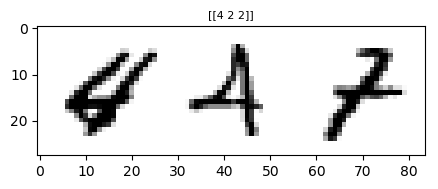

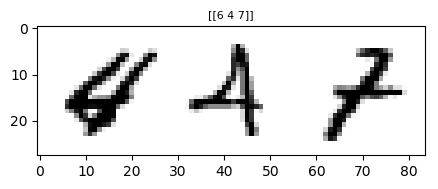

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.106, test_acc = 0.971 (2913/3000)
my test_acc = 0.971 = (2913/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 1 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9999726e-01 8.2350675e-11 4.3769708e-07 8.5299998e-09 8.3603569e-09 1.2774608e-07 3.9459908e-07 6.1940327e-08 2.0004633e-07 1.3978856e-06]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

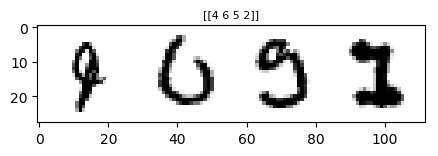

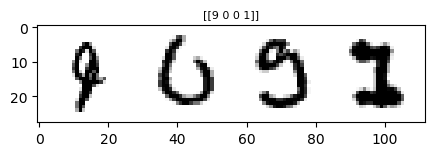

sum chosen images = 284097.594727242365
sum chosen images of class 0 =  49993.55337625742
sum chosen labels =  13493
test_loss = 0.083, test_acc = 0.975 (2926/3000)
my test_acc = 0.975 = (2926/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 1 on distribution 6: [0.0142 0.02   0.028  0.0392 0.055  0.077  0.1078 0.1508 0.2112 0.2968]
[ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
[[5.7062783e-07 9.9986565e-01 4.7377100e-05 3.1520201e-06 7.8502380e-06 1.6022818e-06 3.1638467e-06 2.1279535e-05 4.7523990e-05 1.7439460e-06]]
indices_wrt_distr =  [ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
np.sum(indices_wrt_distr) =  8118684
[ 42  60  84 117 165 231 323 453 634 891]
sum chosen images = 299476.156250000000 (3000, 28, 28, 1)
299476.16
sum chosen images of class 0 = 5115.635253906250 (3000, 28, 28, 1)
sum chosen labels = 

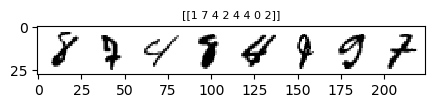

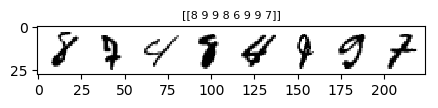

sum chosen images = 299476.167405257002
sum chosen images of class 0 =  5115.635337796994
sum chosen labels =  20594
test_loss = 0.113, test_acc = 0.968 (2904/3000)
my test_acc = 0.968 = (2904/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 1 on distribution 7: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]
[ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
[[9.9999726e-01 8.2350675e-11 4.3769708e-07 8.5299998e-09 8.3603569e-09 1.2774608e-07 3.9459908e-07 6.1940327e-08 2.0004633e-07 1.3978856e-06]]
indices_wrt_distr =  [ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
np.sum(indices_wrt_distr) =  7963076
[891 634 453 324 231 165 118  83  59  42]
sum chosen images = 303331.468750000000 (3000, 28, 28, 1)
303331.47
sum chosen images of class 0 = 120256.562500000000 (3000, 28, 28, 1)
sum chosen labels 

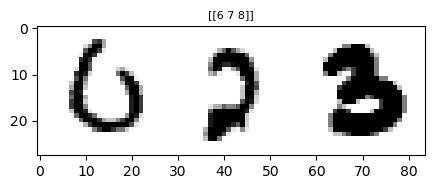

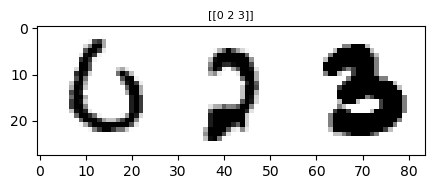

sum chosen images = 303331.524176409002
sum chosen images of class 0 =  120256.55780053511
sum chosen labels =  6400
test_loss = 0.058, test_acc = 0.984 (2951/3000)
my test_acc = 0.984 = (2951/3000)







Restoring model 2 from Lenet5_8distrs_withDistrBeforeF1_10000samples_2018_05_21---08_36.model.ckpt
The restored model 2 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [False False  True False False]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.9816
images sum 1038915.0
test_acc = 0.982 (9816/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 2 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9995768e-01 3.1028698e-08 3.4623848e-05 5.8697776e-08 3.7179014e-08 4.0834851e-07 3.7885452e-06 3.

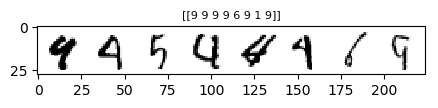

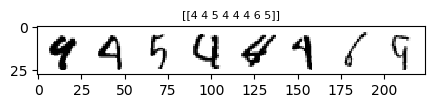

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.075, test_acc = 0.978 (2935/3000)
my test_acc = 0.978 = (2935/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 2 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9995768e-01 3.1028698e-08 3.4623848e-05 5.8697776e-08 3.7179014e-08 4.0834851e-07 3.7885452e-06 3.2535881e-06 1.4788247e-07 2.2578435e-07]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

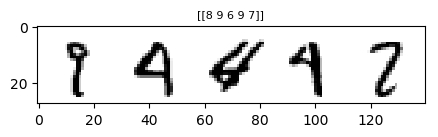

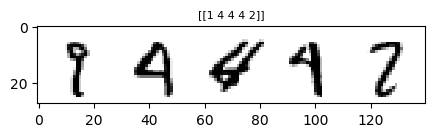

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.063, test_acc = 0.980 (2939/3000)
my test_acc = 0.980 = (2939/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 2 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[5.8464167e-09 9.9999869e-01 1.0259841e-08 1.1348029e-09 6.4884557e-07 1.4949636e-08 1.8491312e-08 1.6786190e-08 6.5443925e-07 7.6370164e-08]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

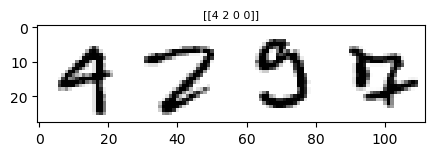

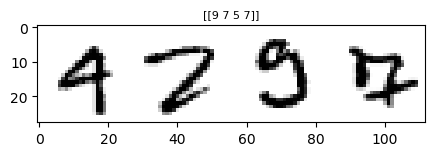

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.086, test_acc = 0.974 (2921/3000)
my test_acc = 0.974 = (2921/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 2 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9995768e-01 3.1028698e-08 3.4623848e-05 5.8697776e-08 3.7179014e-08 4.0834851e-07 3.7885452e-06 3.2535881e-06 1.4788247e-07 2.2578435e-07]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

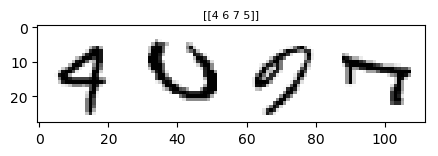

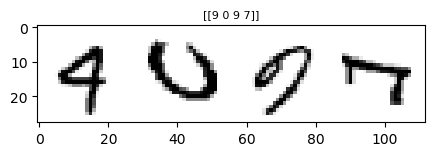

sum chosen images = 284097.594727242365
sum chosen images of class 0 =  49993.55337625742
sum chosen labels =  13493
test_loss = 0.083, test_acc = 0.976 (2927/3000)
my test_acc = 0.976 = (2927/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 2 on distribution 6: [0.0142 0.02   0.028  0.0392 0.055  0.077  0.1078 0.1508 0.2112 0.2968]
[ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
[[1.5569193e-06 9.9988592e-01 4.6208902e-06 8.5041887e-07 3.2423392e-05 2.8242519e-06 3.2705109e-06 4.9051582e-06 5.4789794e-05 8.8664710e-06]]
indices_wrt_distr =  [ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
np.sum(indices_wrt_distr) =  8118684
[ 42  60  84 117 165 231 323 453 634 891]
sum chosen images = 299476.156250000000 (3000, 28, 28, 1)
299476.16
sum chosen images of class 0 = 5115.635253906250 (3000, 28, 28, 1)
sum chosen labels = 

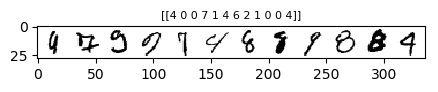

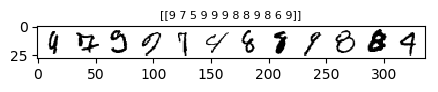

sum chosen images = 299476.167405257002
sum chosen images of class 0 =  5115.635337796994
sum chosen labels =  20594
test_loss = 0.099, test_acc = 0.969 (2908/3000)
my test_acc = 0.969 = (2908/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 2 on distribution 7: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]
[ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
[[9.9995768e-01 3.1028698e-08 3.4623848e-05 5.8697776e-08 3.7179014e-08 4.0834851e-07 3.7885452e-06 3.2535881e-06 1.4788247e-07 2.2578435e-07]]
indices_wrt_distr =  [ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
np.sum(indices_wrt_distr) =  7963076
[891 634 453 324 231 165 118  83  59  42]
sum chosen images = 303331.468750000000 (3000, 28, 28, 1)
303331.47
sum chosen images of class 0 = 120256.562500000000 (3000, 28, 28, 1)
sum chosen labels 

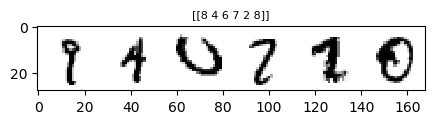

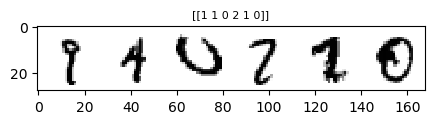

sum chosen images = 303331.524176409002
sum chosen images of class 0 =  120256.55780053511
sum chosen labels =  6400
test_loss = 0.057, test_acc = 0.982 (2947/3000)
my test_acc = 0.982 = (2947/3000)







Restoring model 3 from Lenet5_8distrs_withDistrBeforeF1F2F3_10000samples_2018_05_21---08_42.model.ckpt
The restored model 3 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [False False  True  True  True]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.9815
images sum 1038915.0
test_acc = 0.982 (9815/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9999177e-01 3.5616122e-08 2.3835921e-06 2.5274018e-08 7.5429201e-09 1.7791017e-07 2.9126306e-0

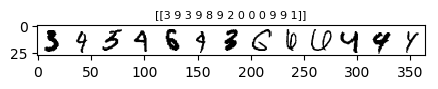

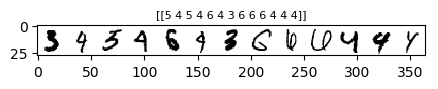

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.074, test_acc = 0.979 (2936/3000)
my test_acc = 0.979 = (2936/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9999177e-01 3.5616122e-08 2.3835921e-06 2.5274018e-08 7.5429201e-09 1.7791017e-07 2.9126306e-06 8.9921258e-08 6.1119692e-07 2.1009585e-06]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

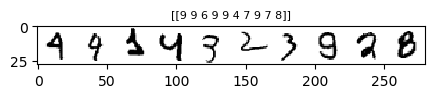

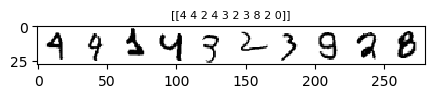

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.070, test_acc = 0.977 (2930/3000)
my test_acc = 0.977 = (2930/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[1.8378935e-09 9.9999928e-01 2.6370245e-08 1.6483901e-11 9.2327276e-08 1.2730037e-09 6.8713000e-09 4.1946731e-09 6.1765758e-07 1.1708803e-08]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

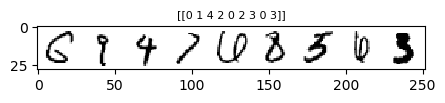

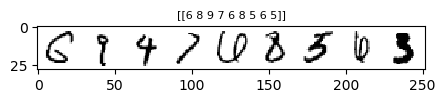

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.086, test_acc = 0.975 (2926/3000)
my test_acc = 0.975 = (2926/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9999177e-01 3.5616122e-08 2.3835921e-06 2.5274018e-08 7.5429201e-09 1.7791017e-07 2.9126306e-06 8.9921258e-08 6.1119692e-07 2.1009585e-06]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

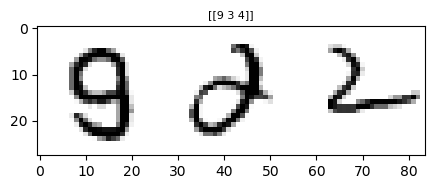

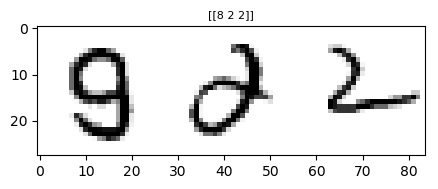

sum chosen images = 287587.363401819952
sum chosen images of class 0 =  18143.70996252168
sum chosen labels =  13500
test_loss = 0.081, test_acc = 0.975 (2925/3000)
my test_acc = 0.975 = (2925/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 5: [0.1368 0.194  0.0968 0.0484 0.0242 0.0242 0.0484 0.0968 0.1936 0.1368]
[ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
[[9.9999177e-01 3.5616122e-08 2.3835921e-06 2.5274018e-08 7.5429201e-09 1.7791017e-07 2.9126306e-06 8.9921258e-08 6.1119692e-07 2.1009585e-06]]
indices_wrt_distr =  [ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
np.sum(indices_wrt_distr) =  6110810
[411 583 290 145  72  72 145 290 581 411]
sum chosen images = 284097.562500000000 (3000, 28, 28, 1)
284097.56
sum chosen images of class 0 = 49993.550781250000 (3000, 28, 28, 1)
sum chosen labels =

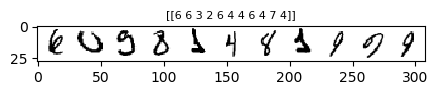

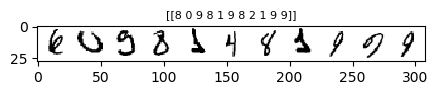

sum chosen images = 284097.594727242365
sum chosen images of class 0 =  49993.55337625742
sum chosen labels =  13493
test_loss = 0.077, test_acc = 0.976 (2929/3000)
my test_acc = 0.976 = (2929/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 6: [0.0142 0.02   0.028  0.0392 0.055  0.077  0.1078 0.1508 0.2112 0.2968]
[ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
[[1.56384056e-06 9.99888778e-01 1.39711365e-05 8.41270165e-08 1.73925673e-05 1.28155079e-06 7.82408097e-06 3.30233502e-06 6.24201057e-05
  3.19437186e-06]]
indices_wrt_distr =  [ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
np.sum(indices_wrt_distr) =  8118684
[ 42  60  84 117 165 231 323 453 634 891]
sum chosen images = 299476.156250000000 (3000, 28, 28, 1)
299476.16
sum chosen images of class 0 = 5115.635253906250 (3000, 28, 28, 1)
sum chos

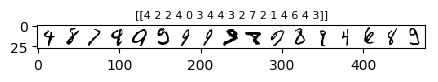

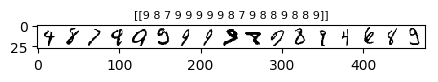

sum chosen images = 299476.167405257002
sum chosen images of class 0 =  5115.635337796994
sum chosen labels =  20594
test_loss = 0.093, test_acc = 0.972 (2917/3000)
my test_acc = 0.972 = (2917/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 3 on distribution 7: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]
[ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
[[9.9999177e-01 3.5616122e-08 2.3835921e-06 2.5274018e-08 7.5429201e-09 1.7791017e-07 2.9126306e-06 8.9921258e-08 6.1119692e-07 2.1009585e-06]]
indices_wrt_distr =  [ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
np.sum(indices_wrt_distr) =  7963076
[891 634 453 324 231 165 118  83  59  42]
sum chosen images = 303331.468750000000 (3000, 28, 28, 1)
303331.47
sum chosen images of class 0 = 120256.562500000000 (3000, 28, 28, 1)
sum chosen labels 

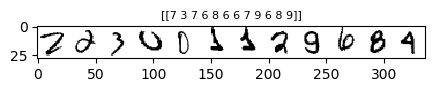

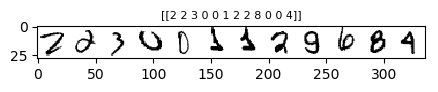

sum chosen images = 303331.524176409002
sum chosen images of class 0 =  120256.55780053511
sum chosen labels =  6400
test_loss = 0.060, test_acc = 0.981 (2942/3000)
my test_acc = 0.981 = (2942/3000)







Restoring model 4 from Lenet5_8distrs_withDistrBeforeC1_10000samples_2018_05_21---08_49.model.ckpt
The restored model 4 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [ True False False False False]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.9814
images sum 1038915.0
test_acc = 0.981 (9814/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 4 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9964738e-01 5.3661432e-07 1.1930303e-04 2.2106547e-05 1.1718118e-06 3.3748925e-05 6.2801220e-05 5.

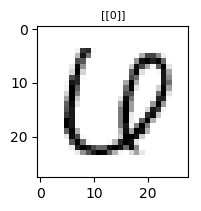

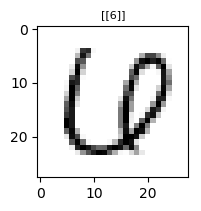

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.087, test_acc = 0.975 (2924/3000)
my test_acc = 0.975 = (2924/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 4 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9964738e-01 5.3661432e-07 1.1930303e-04 2.2106547e-05 1.1718118e-06 3.3748925e-05 6.2801220e-05 5.1997426e-06 3.8741484e-05 6.8926303e-05]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

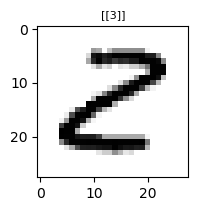

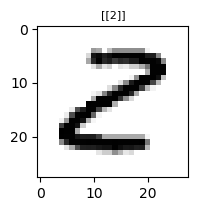

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.069, test_acc = 0.979 (2937/3000)
my test_acc = 0.979 = (2937/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 4 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[2.3141679e-10 9.9999928e-01 1.3755791e-09 3.7380992e-09 4.4379618e-08 1.5419748e-09 1.4554723e-09 6.0534376e-07 1.0414189e-07 1.8167967e-09]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

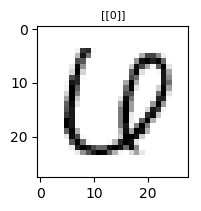

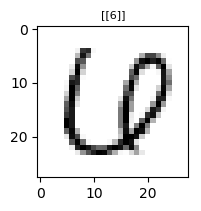

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.091, test_acc = 0.974 (2921/3000)
my test_acc = 0.974 = (2921/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 4 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9964738e-01 5.3661432e-07 1.1930303e-04 2.2106547e-05 1.1718118e-06 3.3748925e-05 6.2801220e-05 5.1997426e-06 3.8741484e-05 6.8926303e-05]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

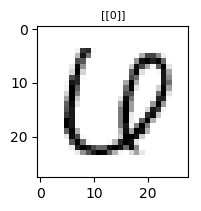

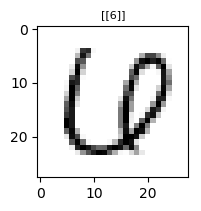

sum chosen images = 287587.363401819952
sum chosen images of class 0 =  18143.70996252168
sum chosen labels =  13500
test_loss = 0.073, test_acc = 0.978 (2933/3000)
my test_acc = 0.978 = (2933/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 4 on distribution 5: [0.1368 0.194  0.0968 0.0484 0.0242 0.0242 0.0484 0.0968 0.1936 0.1368]
[ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
[[9.9964738e-01 5.3661432e-07 1.1930303e-04 2.2106547e-05 1.1718118e-06 3.3748925e-05 6.2801220e-05 5.1997426e-06 3.8741484e-05 6.8926303e-05]]
indices_wrt_distr =  [ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
np.sum(indices_wrt_distr) =  6110810
[411 583 290 145  72  72 145 290 581 411]
sum chosen images = 284097.562500000000 (3000, 28, 28, 1)
284097.56
sum chosen images of class 0 = 49993.550781250000 (3000, 28, 28, 1)
sum chosen labels =

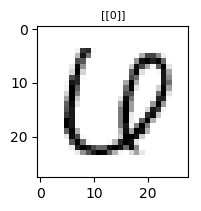

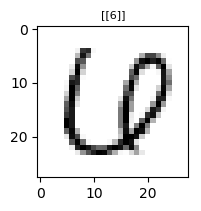

sum chosen images = 299476.167405257002
sum chosen images of class 0 =  5115.635337796994
sum chosen labels =  20594
test_loss = 0.105, test_acc = 0.969 (2906/3000)
my test_acc = 0.969 = (2906/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 4 on distribution 7: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]
[ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
[[9.9964738e-01 5.3661432e-07 1.1930303e-04 2.2106547e-05 1.1718118e-06 3.3748925e-05 6.2801220e-05 5.1997426e-06 3.8741484e-05 6.8926303e-05]]
indices_wrt_distr =  [ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
np.sum(indices_wrt_distr) =  7963076
[891 634 453 324 231 165 118  83  59  42]
sum chosen images = 303331.468750000000 (3000, 28, 28, 1)
303331.47
sum chosen images of class 0 = 120256.562500000000 (3000, 28, 28, 1)
sum chosen labels 

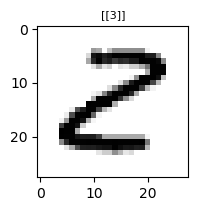

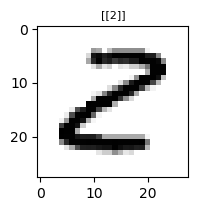

sum chosen images = 303331.524176409002
sum chosen images of class 0 =  120256.55780053511
sum chosen labels =  6400
test_loss = 0.057, test_acc = 0.983 (2948/3000)
my test_acc = 0.983 = (2948/3000)







Restoring model 5 from Lenet5_8distrs_withDistrBeforeC2_10000samples_2018_05_21---08_55.model.ckpt
The restored model 5 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [False  True False False False]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.9825
images sum 1038915.0
test_acc = 0.983 (9825/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9972647e-01 1.0016358e-06 2.2648428e-05 1.1996979e-06 6.2467791e-07 6.7865469e-05 8.3360275e-05 5.

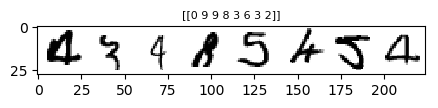

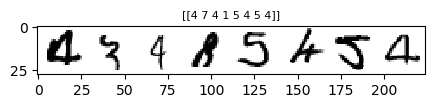

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.074, test_acc = 0.979 (2937/3000)
my test_acc = 0.979 = (2937/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9972647e-01 1.0016358e-06 2.2648428e-05 1.1996979e-06 6.2467791e-07 6.7865469e-05 8.3360275e-05 5.0158967e-05 5.7272109e-06 4.1114428e-05]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

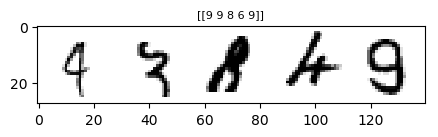

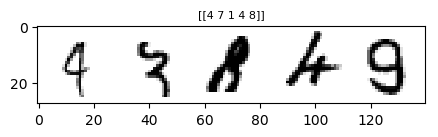

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.063, test_acc = 0.979 (2937/3000)
my test_acc = 0.979 = (2937/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[1.0655163e-11 1.0000000e+00 1.6008008e-09 4.9193857e-11 1.0504904e-08 2.4662697e-10 4.1422715e-10 1.1422065e-10 5.3130080e-08 1.1382629e-11]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

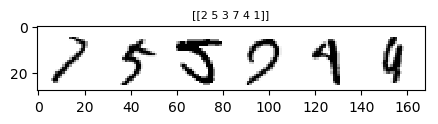

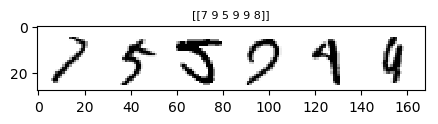

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.082, test_acc = 0.979 (2936/3000)
my test_acc = 0.979 = (2936/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9972647e-01 1.0016358e-06 2.2648428e-05 1.1996979e-06 6.2467791e-07 6.7865469e-05 8.3360275e-05 5.0158967e-05 5.7272109e-06 4.1114428e-05]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

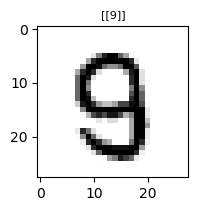

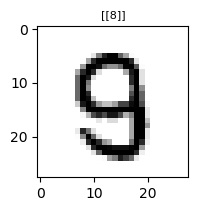

sum chosen images = 287587.363401819952
sum chosen images of class 0 =  18143.70996252168
sum chosen labels =  13500
test_loss = 0.071, test_acc = 0.979 (2936/3000)
my test_acc = 0.979 = (2936/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 5: [0.1368 0.194  0.0968 0.0484 0.0242 0.0242 0.0484 0.0968 0.1936 0.1368]
[ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
[[9.9972647e-01 1.0016358e-06 2.2648428e-05 1.1996979e-06 6.2467791e-07 6.7865469e-05 8.3360275e-05 5.0158967e-05 5.7272109e-06 4.1114428e-05]]
indices_wrt_distr =  [ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
np.sum(indices_wrt_distr) =  6110810
[411 583 290 145  72  72 145 290 581 411]
sum chosen images = 284097.562500000000 (3000, 28, 28, 1)
284097.56
sum chosen images of class 0 = 49993.550781250000 (3000, 28, 28, 1)
sum chosen labels =

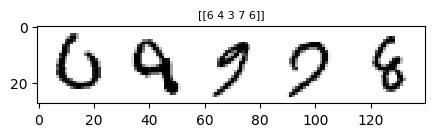

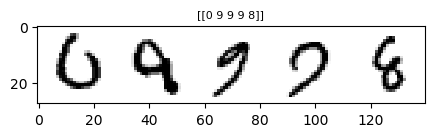

sum chosen images = 284097.594727242365
sum chosen images of class 0 =  49993.55337625742
sum chosen labels =  13493
test_loss = 0.069, test_acc = 0.979 (2936/3000)
my test_acc = 0.979 = (2936/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 6: [0.0142 0.02   0.028  0.0392 0.055  0.077  0.1078 0.1508 0.2112 0.2968]
[ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
[[4.31925000e-05 9.96110022e-01 2.76926876e-04 1.04507366e-04 1.71939435e-04 2.94754514e-04 3.46707704e-04 3.04556361e-05 2.60058674e-03
  2.10087292e-05]]
indices_wrt_distr =  [ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
np.sum(indices_wrt_distr) =  8118684
[ 42  60  84 117 165 231 323 453 634 891]
sum chosen images = 299476.156250000000 (3000, 28, 28, 1)
299476.16
sum chosen images of class 0 = 5115.635253906250 (3000, 28, 28, 1)
sum chos

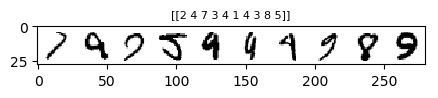

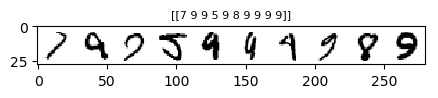

sum chosen images = 299476.167405257002
sum chosen images of class 0 =  5115.635337796994
sum chosen labels =  20594
test_loss = 0.095, test_acc = 0.972 (2915/3000)
my test_acc = 0.972 = (2915/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 5 on distribution 7: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]
[ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
[[9.9972647e-01 1.0016358e-06 2.2648428e-05 1.1996979e-06 6.2467791e-07 6.7865469e-05 8.3360275e-05 5.0158967e-05 5.7272109e-06 4.1114428e-05]]
indices_wrt_distr =  [ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
np.sum(indices_wrt_distr) =  7963076
[891 634 453 324 231 165 118  83  59  42]
sum chosen images = 303331.468750000000 (3000, 28, 28, 1)
303331.47
sum chosen images of class 0 = 120256.562500000000 (3000, 28, 28, 1)
sum chosen labels 

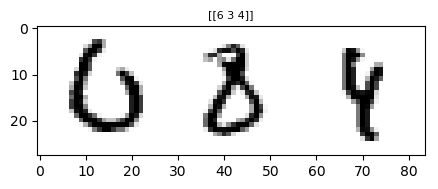

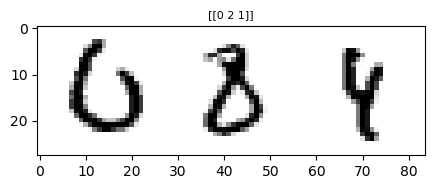

sum chosen images = 303331.524176409002
sum chosen images of class 0 =  120256.55780053511
sum chosen labels =  6400
test_loss = 0.047, test_acc = 0.985 (2955/3000)
my test_acc = 0.985 = (2955/3000)







Restoring model 6 from Lenet5_8distrs_withDistrBeforeC1C2_10000samples_2018_05_21---09_02.model.ckpt
The restored model 6 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [ True  True False False False]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.9818
images sum 1038915.0
test_acc = 0.982 (9818/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 6 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9975103e-01 4.7236952e-09 1.8187362e-05 5.4419672e-07 6.3636878e-07 1.2288687e-05 7.4251904e-05 

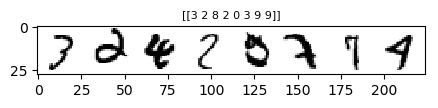

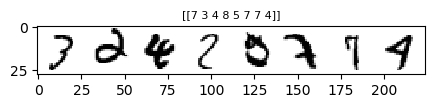

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.071, test_acc = 0.980 (2941/3000)
my test_acc = 0.980 = (2941/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 6 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9975103e-01 4.7236952e-09 1.8187362e-05 5.4419672e-07 6.3636878e-07 1.2288687e-05 7.4251904e-05 3.9788033e-06 6.0851462e-06 1.3295827e-04]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

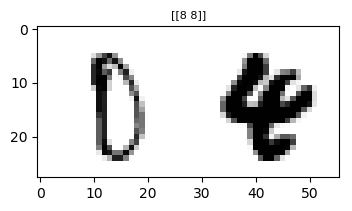

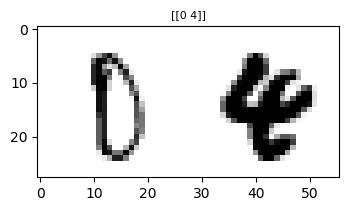

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.064, test_acc = 0.982 (2945/3000)
my test_acc = 0.982 = (2945/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 6 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[9.0576044e-13 9.9999988e-01 4.9493756e-09 5.5455851e-13 8.9572779e-08 1.9199404e-11 6.1594646e-10 4.2952697e-10 1.1888524e-08 1.5259417e-10]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

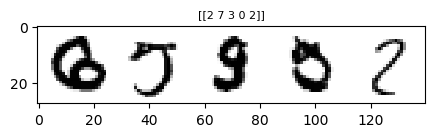

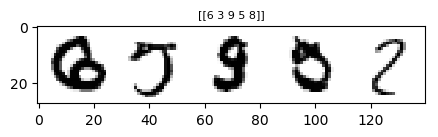

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.084, test_acc = 0.977 (2931/3000)
my test_acc = 0.977 = (2931/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 6 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9975103e-01 4.7236952e-09 1.8187362e-05 5.4419672e-07 6.3636878e-07 1.2288687e-05 7.4251904e-05 3.9788033e-06 6.0851462e-06 1.3295827e-04]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

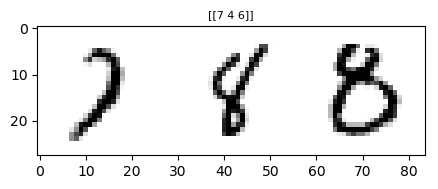

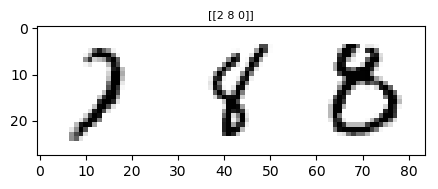

sum chosen images = 284097.594727242365
sum chosen images of class 0 =  49993.55337625742
sum chosen labels =  13493
test_loss = 0.082, test_acc = 0.978 (2934/3000)
my test_acc = 0.978 = (2934/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 6 on distribution 6: [0.0142 0.02   0.028  0.0392 0.055  0.077  0.1078 0.1508 0.2112 0.2968]
[ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
[[1.2703772e-06 9.9949849e-01 5.9283298e-05 3.2191804e-07 1.7061651e-04 8.0697164e-06 6.2993946e-05 8.3229388e-06 1.8320722e-04 7.1359668e-06]]
indices_wrt_distr =  [ 251 4700 2608 4230 2317   76 4467  441  578  612 ...   41 1003 4663  145 6070  461 8670  447 7641 1814]
np.sum(indices_wrt_distr) =  8118684
[ 42  60  84 117 165 231 323 453 634 891]
sum chosen images = 299476.156250000000 (3000, 28, 28, 1)
299476.16
sum chosen images of class 0 = 5115.635253906250 (3000, 28, 28, 1)
sum chosen labels = 

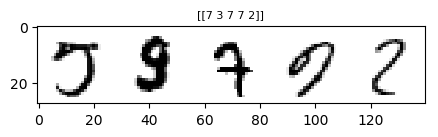

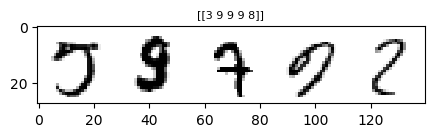

sum chosen images = 299476.167405257002
sum chosen images of class 0 =  5115.635337796994
sum chosen labels =  20594
test_loss = 0.103, test_acc = 0.973 (2918/3000)
my test_acc = 0.973 = (2918/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 6 on distribution 7: [0.2968 0.2112 0.1508 0.1078 0.077  0.055  0.0392 0.028  0.02   0.0142]
[ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
[[9.9975103e-01 4.7236952e-09 1.8187362e-05 5.4419672e-07 6.3636878e-07 1.2288687e-05 7.4251904e-05 3.9788033e-06 6.0851462e-06 1.3295827e-04]]
indices_wrt_distr =  [ 884  720 1839 3415 3264 2217 5081  441 2748 1898 ... 1054 5899  638  701  865 7688  292 3830  771 2822]
np.sum(indices_wrt_distr) =  7963076
[891 634 453 324 231 165 118  83  59  42]
sum chosen images = 303331.468750000000 (3000, 28, 28, 1)
303331.47
sum chosen images of class 0 = 120256.562500000000 (3000, 28, 28, 1)
sum chosen labels 

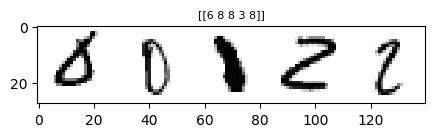

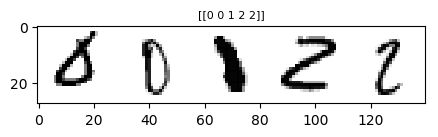

sum chosen images = 303331.524176409002
sum chosen images of class 0 =  120256.55780053511
sum chosen labels =  6400
test_loss = 0.052, test_acc = 0.986 (2957/3000)
my test_acc = 0.986 = (2957/3000)







Restoring model 7 from Lenet5_8distrs_withDistrBeforeC1C2F1F2F3_10000samples_2018_05_21---09_09.model.ckpt
The restored model 7 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]; distr_pos = [ True  True  True  True  True]

np.sum(mnist_ds.test.images) =  1038915.0
num_examples =  10000
test_batch_size =  10000
acc =  0.9802
images sum 1038915.0
test_acc = 0.980 (9802/10000)
np.sum(mnist_ds.test.images) =  1038915.0
sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 7 on distribution 0: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[ 884 2099 2546  973  555 2217 2457  441 2748 1898 ... 1205 2239 1973  701 2976 1227 2966  385 1998   85]
[[9.9998307e-01 3.2361196e-09 3.6612701e-07 9.0142507e-08 3.4993399e-09 3.2231546e-06 1.200824

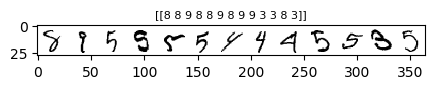

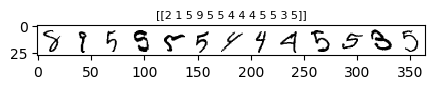

sum chosen images = 294488.586996767670
sum chosen images of class 0 =  5755.035343693569
sum chosen labels =  13499
test_loss = 0.088, test_acc = 0.975 (2924/3000)
my test_acc = 0.975 = (2924/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 7 on distribution 2: [0.0632 0.1264 0.2542 0.1788 0.1264 0.0894 0.0632 0.0446 0.0316 0.0222]
[ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
[[9.9998307e-01 3.2361196e-09 3.6612701e-07 9.0142507e-08 3.4993399e-09 3.2231546e-06 1.2008249e-05 2.9195814e-07 4.5718068e-07 4.6727180e-07]]
indices_wrt_distr =  [ 884  943 3896  109 6594   31 1315  441  393 1898 ... 4367 3237  861  701 1815 1451  558 1350  603 6132]
np.sum(indices_wrt_distr) =  6424445
[189 380 763 537 380 269 189 133  94  66]
sum chosen images = 294508.312500000000 (3000, 28, 28, 1)
294508.3
sum chosen images of class 0 = 22874.515625000000 (3000, 28, 28, 1)
sum chosen labels = 

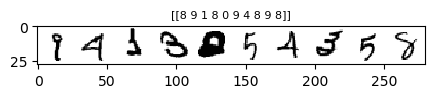

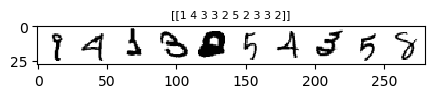

sum chosen images = 294508.426164184231
sum chosen images of class 0 =  22874.513924519066
sum chosen labels =  9793
test_loss = 0.073, test_acc = 0.978 (2934/3000)
my test_acc = 0.978 = (2934/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 7 on distribution 3: [0.0222 0.0316 0.0446 0.0632 0.0894 0.1264 0.1788 0.2542 0.1264 0.0632]
[  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
[[2.0951702e-12 9.9999964e-01 7.4576754e-09 1.3149383e-08 4.3149289e-09 1.9844791e-10 3.0093295e-10 2.4639721e-08 3.5896582e-07 1.2732397e-09]]
indices_wrt_distr =  [  74 1758  626 2115 1536  306 3603  441  796   82 ... 2951  698 1686  701 3838 2338 1851  595  862  943]
np.sum(indices_wrt_distr) =  6790945
[ 66  94 133 189 269 380 537 763 380 189]
sum chosen images = 290213.625000000000 (3000, 28, 28, 1)
290213.62
sum chosen images of class 0 = 7756.234863281250 (3000, 28, 28, 1)
sum chosen labels = 

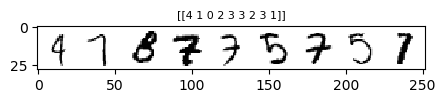

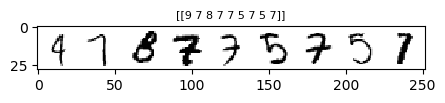

sum chosen images = 290213.543830343056
sum chosen images of class 0 =  7756.2353625711985
sum chosen labels =  17207
test_loss = 0.102, test_acc = 0.973 (2919/3000)
my test_acc = 0.973 = (2919/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 7 on distribution 4: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]
[ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
[[9.9998307e-01 3.2361196e-09 3.6612701e-07 9.0142507e-08 3.4993399e-09 3.2231546e-06 1.2008249e-05 2.9195814e-07 4.5718068e-07 4.6727180e-07]]
indices_wrt_distr =  [ 884  582  903 2643 2032  329 1078  441  777  143 ... 5507  924  527  701 1164 2662 1481 1766  422 1600]
np.sum(indices_wrt_distr) =  5718759
[150 300 600 300 150 150 300 600 300 150]
sum chosen images = 287587.437500000000 (3000, 28, 28, 1)
287587.44
sum chosen images of class 0 = 18143.710937500000 (3000, 28, 28, 1)
sum chosen labels = 13500
test_acc = 0

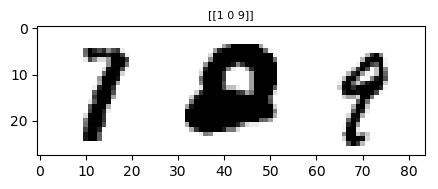

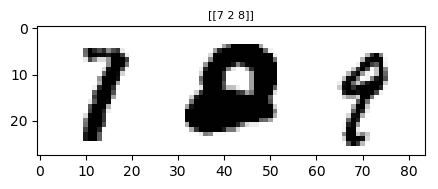

sum chosen images = 287587.363401819952
sum chosen images of class 0 =  18143.70996252168
sum chosen labels =  13500
test_loss = 0.087, test_acc = 0.974 (2922/3000)
my test_acc = 0.974 = (2922/3000)



sum all images = 1038915.000000000000
np.sum(mnist_ds.test.images) =  1038915.0
Testing model 7 on distribution 5: [0.1368 0.194  0.0968 0.0484 0.0242 0.0242 0.0484 0.0968 0.1936 0.1368]
[ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
[[9.9998307e-01 3.2361196e-09 3.6612701e-07 9.0142507e-08 3.4993399e-09 3.2231546e-06 1.2008249e-05 2.9195814e-07 4.5718068e-07 4.6727180e-07]]
indices_wrt_distr =  [ 884   99   75 1624 2459 2217  360  441 2748 1898 ...  306 1179   12  701  685 2878 4101 3830 3147 1991]
np.sum(indices_wrt_distr) =  6110810
[411 583 290 145  72  72 145 290 581 411]
sum chosen images = 284097.562500000000 (3000, 28, 28, 1)
284097.56
sum chosen images of class 0 = 49993.550781250000 (3000, 28, 28, 1)
sum chosen labels =

KeyboardInterrupt: 

In [30]:
# WORK_DIR = "./results/Lenet5WithDistr_8distr_10000samples/"
WORK_DIR = "./results/Lenet5WithDistr_8distr_10000samples_2/"
# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_10000samples/"
# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_10000samples_2/"

# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_allData/"
# WORK_DIR = "./results/Lenet5WithDistr_8distr_allData/"

NO_SHUFFLES = 0

ckpt_file_list = Utils.get_all_files_from_dir_ending_with(WORK_DIR, "ckpt.meta", without_file_extension=True)

perf_dict = {'idx_model':[], 'distr_pos':[], 'idx_distr':[], 'test_acc':[], 'total_predict':[], 'total_actual':[], 
             'correct_predicted_distr':[], 'wrong_predicted_distr':[], 'wrong_actual_distr':[],
             'train_distr':[], 'test_distr':[], 'ckpt_file':[]}


for idx_model, ckpt_file in enumerate(ckpt_file_list):
    if idx_model == 0:
        continue
    print('Restoring model {} from {}'.format(idx_model, ckpt_file))
    restored_distr_pos = Utils.restore_variable_from_checkpoint(ckpt_dir=WORK_DIR, ckpt_file=ckpt_file, var_name = 'distr_pos')
    test_model = Lenet5WithDistr(mnist_dataset=mnist_ds, verbose=False, distr_pos=restored_distr_pos)
    test_model.restore_session(ckpt_dir=WORK_DIR, ckpt_filename=ckpt_file)
    current_model_train_distr = test_model.session.run(test_model.train_distr)
    print('The restored model {} was trained using distr: {}; distr_pos = {}\n'.format(idx_model, current_model_train_distr, restored_distr_pos))
    
    # test on the entire MNIST dataset and impose distribution over the results in order to not retest over the subsets
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
    print('np.sum(mnist_ds.test.images) = ', np.sum(mnist_ds.test.images))
    
    # save the results for the entire dataset
    for s in range(NO_SHUFFLES): 
        mnist_ds.test.shuffle()  # for changing the order in total_predict which is used above for testing on the other distributions
    test_loss, test_acc, total_predict, total_actual, wrong_predict_images, output_probs = test_model.test_data(mnist_ds.test, use_only_one_batch=True)
    print('test_acc = {:.3f} ({}/{})'.format(test_acc, mnist_ds.test.num_examples - len(wrong_predict_images), mnist_ds.test.num_examples))
    
    # save the results into dictionary
    perf_dict['idx_model'].append(idx_model)
    perf_dict['distr_pos'].append(restored_distr_pos)
    perf_dict['idx_distr'].append(-1)
    perf_dict['test_acc'].append(test_acc)
    perf_dict['total_predict'].append(total_predict)
    perf_dict['total_actual'].append(total_actual)
    correct_predict = total_predict[total_actual == total_predict]
    wrong_predict = total_predict[total_actual != total_predict]
    wrong_actual = total_actual[total_actual != total_predict]
    perf_dict['correct_predicted_distr'].append(np.histogram(correct_predict)[0])
    perf_dict['wrong_predicted_distr'].append(np.histogram(wrong_predict)[0])
    perf_dict['wrong_actual_distr'].append(np.histogram(wrong_actual)[0])
    perf_dict['train_distr'].append(current_model_train_distr)
    perf_dict['test_distr'].append(mnist_ds.test.label_distr)
    perf_dict['ckpt_file'].append(ckpt_file)

    print('np.sum(mnist_ds.test.images) = ', np.sum(mnist_ds.test.images))
    for idx_distr, distr in enumerate(distrs_used_for_training):
        mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
        print('sum all images = {:.12f}'.format(np.sum(mnist_ds.test.images)))
        print('np.sum(mnist_ds.test.images) = ', np.sum(mnist_ds.test.images))
        print('Testing model {} on distribution {}: {}'.format(idx_model, idx_distr, distr))
#         indices_wrt_distr = Utils.get_indices_wrt_distr(labels = total_actual, weights=distr, max_no_examples=3000)
        indices_wrt_distr = Utils.get_indices_wrt_distr(labels = mnist_ds.test.labels, weights=distr, max_no_examples=3000)

        num_examples_selection = len(indices_wrt_distr)
        total_predict_selection = total_predict[[indices_wrt_distr]]
        total_actual_selection = total_actual[[indices_wrt_distr]]
        print(indices_wrt_distr)
        images_selection = mnist_ds.test.images[[indices_wrt_distr]]
        no_correct_predicted = np.sum(total_predict_selection == total_actual_selection)
        test_acc = no_correct_predicted / num_examples_selection
        print(output_probs[[indices_wrt_distr[0]]])
        print('indices_wrt_distr = ', indices_wrt_distr)
        print('np.sum(indices_wrt_distr) = ', np.sum(indices_wrt_distr))
        print(np.histogram(total_actual_selection)[0])
        print('sum chosen images = {:.12f}'.format(np.sum(images_selection)), images_selection.shape)
#         nlines = 5
#         ncols = 70
#         plt.figure(figsize=(16, 3), dpi = 150)
#         plt.imshow(Utils.concat_images(mnist_ds.test.images[[indices_wrt_distr]][0:nlines*ncols], 28, nlines, ncols), cmap='gray_r')
#         plt.title(str(np.argmax(mnist_ds.test.labels[[indices_wrt_distr]][0:nlines*ncols], axis=1).reshape(nlines, ncols)), fontsize=8)
#         plt.show()
        print(np.sum(images_selection))
        print('sum chosen images of class 0 = {:.12f}'.format(np.sum(mnist_ds.test.images[[indices_wrt_distr]][[total_actual_selection == 0]])), images_selection.shape)
        print('sum chosen labels = {}'.format(np.sum(total_actual_selection)))
        print('test_acc = {:.3f} ({}/{})'.format(test_acc, no_correct_predicted, num_examples_selection))
        
        # save the results into dictionary
        perf_dict['idx_model'].append(idx_model)
        perf_dict['distr_pos'].append(restored_distr_pos)
        perf_dict['idx_distr'].append(idx_distr)
        perf_dict['test_acc'].append(test_acc)
        perf_dict['total_predict'].append(total_predict_selection)
        perf_dict['total_actual'].append(total_actual_selection)
        correct_predict = total_predict_selection[total_actual_selection == total_predict_selection]
        wrong_predict = total_predict_selection[total_actual_selection != total_predict_selection]
        wrong_actual = total_actual_selection[total_actual_selection != total_predict_selection]
        perf_dict['correct_predicted_distr'].append(np.histogram(correct_predict)[0])
        perf_dict['wrong_predicted_distr'].append(np.histogram(wrong_predict)[0])
        perf_dict['wrong_actual_distr'].append(np.histogram(wrong_actual)[0])
        perf_dict['train_distr'].append(current_model_train_distr)
        perf_dict['test_distr'].append(mnist_ds.test.label_distr)
        perf_dict['ckpt_file'].append(ckpt_file)
        
        print('***************************************************************************************************************************')
        
        mnist_ds1 = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
        print('np.sum(mnist_ds1.test.images) = ', np.sum(mnist_ds1.test.images))
        mnist_ds1.impose_distribution(weights=distr, global_max_weight=np.max(distrs_used_for_training))
        print('sum chosen images = {:.12f}'.format(np.sum(mnist_ds1.test.images)))
#         nlines = 5
#         ncols = 70
#         plt.figure(figsize=(16, 3), dpi = 150)
#         plt.imshow(Utils.concat_images(mnist_ds1.test.images[0:nlines*ncols], 28, nlines, ncols), cmap='gray_r')
#         plt.title(str(np.argmax(mnist_ds1.test.labels[0:nlines*ncols], axis=1).reshape(nlines, ncols)), fontsize=8)
#         plt.show()
        test_loss1, test_acc1, total_predict1, total_actual1, wrong_predict_images1, output_probs1 = test_model.test_data(mnist_ds1.test, use_only_one_batch=True)
        print(output_probs1[0])
        
        indices_corresponding_to_different_predictions = np.where(total_predict1 != total_predict[[indices_wrt_distr]])[0]
        print('indices_corresponding_to_different_predictions = ',indices_corresponding_to_different_predictions)
        if len(indices_corresponding_to_different_predictions) > 0:
            print(output_probs[[indices_wrt_distr[indices_corresponding_to_different_predictions[0]]]])
            print(output_probs1[indices_corresponding_to_different_predictions[0]])
            
            nlines = 1
            ncols = len(indices_corresponding_to_different_predictions)

            plt.figure(figsize=(5, 2), dpi = 100)
            plt.imshow(Utils.concat_images(mnist_ds.test.images[[indices_wrt_distr]][[indices_corresponding_to_different_predictions]], 28, nlines, ncols), cmap='gray_r')
            plt.title(str(total_predict[[indices_wrt_distr]][[indices_corresponding_to_different_predictions]].reshape(nlines, ncols)), fontsize=8)
            plt.show()

            plt.figure(figsize=(5, 2), dpi = 100)
            plt.imshow(Utils.concat_images(mnist_ds1.test.images[[indices_corresponding_to_different_predictions]], 28, nlines, ncols), cmap='gray_r')
            plt.title(str(total_predict1[[indices_corresponding_to_different_predictions]].reshape(nlines, ncols)), fontsize=8)
            plt.show()
        
        
        print('sum chosen images = {:.12f}'.format(np.sum(mnist_ds1.test.images)))
        print('sum chosen images of class 0 = ', np.sum(mnist_ds1.test.images[[total_actual1 == 0]]))
        print('sum chosen labels = ', np.sum(total_actual1))
        print('test_loss = {:.3f}, test_acc = {:.3f} ({}/{})'.format(test_loss1, test_acc1, mnist_ds1.test.num_examples - len(wrong_predict_images1), mnist_ds1.test.num_examples))
        print('my test_acc = {:.3f} = ({}/{})'.format(np.sum(total_predict1 == total_actual1) / len(total_predict1),np.sum(total_predict1 == total_actual1), len(total_predict1)))
        
        print('\n\n')
              
    
    # analyze error distribution
    # restore_and_test_a_model_on_a_mnist_subset(mnist_ds, ckpt_dir=WORK_DIR, ckpt_filemame=ckpt_file, plot_filename = 'test_model')
    print('\n\n\n')
# # save the above results dictionary to file
# filename = 'testing_results_{}_shuffles_{}.dict.pickle'.format(Utils.now_as_str(), NO_SHUFFLES)
# full_filepath = os.path.join(WORK_DIR, filename)
# filehandler = open(full_filepath, 'wb') 
# pickle.dump(perf_dict, filehandler)
# print('Results dictionary was succesfully saved to: {}'.format(full_filepath))
# filehandler.close()

In [ ]:
# WORK_DIR = "./results/Lenet5WithDistr_8distr_10000samples/"
WORK_DIR = "./results/Lenet5WithDistr_8distr_10000samples_2/"
# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_10000samples/"
# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_10000samples_2/"

# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_allData/"
# WORK_DIR = "./results/Lenet5WithDistr_8distr_allData/"


NO_SHUFFLES = 0

ckpt_file_list = Utils.get_all_files_from_dir_ending_with(WORK_DIR, "ckpt.meta", without_file_extension=True)

perf_dict = {'idx_model':[], 'distr_pos':[], 'idx_distr':[], 'test_loss':[], 'test_acc':[], 'total_predict':[], 'total_actual':[], 
             'correct_predicted_distr':[], 'wrong_predicted_distr':[], 'wrong_actual_distr':[],
             'train_distr':[], 'test_distr':[], 'ckpt_file':[]}


for idx_model, ckpt_file in enumerate(ckpt_file_list):
    print('Restoring model {} from {}'.format(idx_model, ckpt_file))
    restored_distr_pos = Utils.restore_variable_from_checkpoint(ckpt_dir=WORK_DIR, ckpt_file=ckpt_file, var_name = 'distr_pos')
    test_model = Lenet5WithDistr(mnist_dataset=mnist_ds, verbose=False, distr_pos=restored_distr_pos)
    test_model.restore_session(ckpt_dir=WORK_DIR, ckpt_filename=ckpt_file)
    current_model_train_distr = test_model.session.run(test_model.train_distr)
    print('The restored model {} was trained using distr: {}; distr_pos = {}\n'.format(idx_model, current_model_train_distr, restored_distr_pos))
    
    # test on the entire MNIST dataset and impose distribution over the results in order to not retest over the subsets
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
    
    # save the results for the entire dataset
    test_loss, test_acc, total_predict, total_actual, wrong_predict_images, output_probs = test_model.test_data(mnist_ds.test, use_only_one_batch=True)
    print('sum chosen images = ', np.sum(mnist_ds.test.images))
    print('test_loss = {:.3f}, test_acc = {:.3f} ({}/{})'.format(test_loss, test_acc, mnist_ds.test.num_examples - len(wrong_predict_images), mnist_ds.test.num_examples))
    
    # save the results into dictionary
    perf_dict['idx_model'].append(idx_model)
    perf_dict['distr_pos'].append(restored_distr_pos)
    perf_dict['idx_distr'].append(-1)
    perf_dict['test_loss'].append(test_loss)
    perf_dict['test_acc'].append(test_acc)
    perf_dict['total_predict'].append(total_predict)
    perf_dict['total_actual'].append(total_actual)
    correct_predict = total_predict[total_actual == total_predict]
    wrong_predict = total_predict[total_actual != total_predict]
    wrong_actual = total_actual[total_actual != total_predict]
    perf_dict['correct_predicted_distr'].append(np.histogram(correct_predict)[0])
    perf_dict['wrong_predicted_distr'].append(np.histogram(wrong_predict)[0])
    perf_dict['wrong_actual_distr'].append(np.histogram(wrong_actual)[0])
    perf_dict['train_distr'].append(current_model_train_distr)
    perf_dict['test_distr'].append(mnist_ds.test.label_distr)
    perf_dict['ckpt_file'].append(ckpt_file)

    for idx_distr, distr in enumerate(distrs_used_for_training):
        for s in range(NO_SHUFFLES):
            mnist_ds.test.shuffle()
        mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
        mnist_ds.impose_distribution(weights=distr, global_max_weight=np.max(distrs_used_for_training))
        test_loss, test_acc, total_predict, total_actual, wrong_predict_images, output_probs = test_model.test_data(mnist_ds.test, use_only_one_batch=True)
        print('sum chosen images = ', np.sum(mnist_ds.test.images))
        print('sum chosen images of class 0 = ', np.sum(mnist_ds.test.images[[total_actual == 0]]))
        print('sum chosen labels = ', np.sum(total_actual))
        print('test_loss = {:.3f}, test_acc = {:.3f} ({}/{})'.format(test_loss, test_acc, mnist_ds.test.num_examples - len(wrong_predict_images), mnist_ds.test.num_examples))
        print('my test_acc = {:.3f} = ({}/{})'.format(np.sum(total_predict == total_actual) / len(total_predict),np.sum(total_predict == total_actual), len(total_predict)))
        
        # save the results into dictionary
        perf_dict['idx_model'].append(idx_model)
        perf_dict['distr_pos'].append(restored_distr_pos)
        perf_dict['idx_distr'].append(idx_distr)
        perf_dict['test_loss'].append(test_loss)
        perf_dict['test_acc'].append(test_acc)
        perf_dict['total_predict'].append(total_predict)
        perf_dict['total_actual'].append(total_actual)
        correct_predict = total_predict[total_actual == total_predict]
        wrong_predict = total_predict[total_actual != total_predict]
        wrong_actual = total_actual[total_actual != total_predict]
        perf_dict['correct_predicted_distr'].append(np.histogram(correct_predict)[0])
        perf_dict['wrong_predicted_distr'].append(np.histogram(wrong_predict)[0])
        perf_dict['wrong_actual_distr'].append(np.histogram(wrong_actual)[0])
        perf_dict['train_distr'].append(current_model_train_distr)
        perf_dict['test_distr'].append(mnist_ds.test.label_distr)
        perf_dict['ckpt_file'].append(ckpt_file)
        
        print('\n')
          
   
    
    # analyze error distribution
    # restore_and_test_a_model_on_a_mnist_subset(mnist_ds, ckpt_dir=WORK_DIR, ckpt_filemame=ckpt_file, plot_filename = 'test_model')
    print('\n\n\n')

# save the above results dictionary to file
# filename = 'testing_results_{}_shuffles_{}.dict.pickle'.format(Utils.now_as_str(), NO_SHUFFLES)
# full_filepath = os.path.join(WORK_DIR, filename)
# filehandler = open(full_filepath, 'wb') 
# pickle.dump(perf_dict, filehandler)
# print('Results dictionary was succesfully saved to: {}'.format(full_filepath))
# filehandler.close()

---
### - restore the results saved earlier and plot them
---

In [ ]:
# WORK_DIR = "./results/Lenet5WithDistr_8distr_10000samples/"
# filename = 'testing_results_2018_05_21---00_14.dict.pickle'

WORK_DIR = "./results/Lenet5WithDistr_8distr_10000samples_2/"
# filename = 'testing_results_2018_05_21---09_33.dict.pickle'
filename = 'testing_results_2018_05_21---11_37_shuffles_0.dict.pickle'

# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_10000samples/"
# filename = 'testing_results_2018_05_21---00_44.dict.pickle'

# WORK_DIR = "./results/Lenet5WithDistr_randomDistr_10000samples_2/"
# filename ='testing_results_2018_05_21---08_02.dict.pickle'

filehandler = open(os.path.join(WORK_DIR,filename), 'rb') 
restored_perf_dict = pickle.load(filehandler)
filehandler.close()
print('Results dictionary was succesfully restored from: {}'.format(filename))

# build a pandas dataframe from results dictionary
perf_df = pd.DataFrame(restored_perf_dict, columns=list(restored_perf_dict.keys()))
display(perf_df.describe())
display(perf_df.head())


# print results
for idx_model in perf_df.idx_model.unique():
    for index, row in perf_df[perf_df['idx_model'] == idx_model].iterrows():
        print('acc = {:.3f}  '.format(row['test_acc']), end="", flush=True)
    print(perf_df[perf_df['idx_model'] == idx_model].distr_pos.iloc[0])
    
    
# plot results
for idx_model in perf_df.idx_model.unique():
    k = 0
    fig = plt.figure(figsize=(40, 2.5))
    fig.suptitle(y = 1.15, t = str(perf_df[perf_df['idx_model'] == idx_model].distr_pos.iloc[0]), fontsize=20, fontweight='bold')
#     plt.figtext(x = 0.45, y = 1.2, s = str(perf_df[perf_df['idx_model'] == idx_model].distr_pos.iloc[0]), fontsize=20, fontweight='bold')

    no_subplots = len(distrs_used_for_training) + 1

    for index, row in perf_df[perf_df['idx_model'] == idx_model].iterrows():
        k+=1
        plt.subplot(1, no_subplots, k)
        plt.bar(range(10), row['test_distr'])
        plt.xticks(range(0, 10))
        plt.title('test distr. (acc = {:.3f})'.format(row['test_acc']), fontsize=16)
    
    plt.savefig(os.path.join(WORK_DIR, perf_df[perf_df['idx_model'] == idx_model]['ckpt_file'].iloc[0] + '.testing.png'), bbox_inches='tight' )
    plt.show()


In [266]:
WORK_DIRS =  [
            "./results/Lenet5WithDistr_8distr_allData",
            "./results/Lenet5WithDistr_randomDistr_allData",
            "./results/Lenet5WithDistr_randomDistr_10000samples/",
            "./results/Lenet5WithDistr_randomDistr_10000samples_2/",
            "./results/Lenet5WithDistr_8distr_10000samples/", 
            "./results/Lenet5WithDistr_8distr_10000samples_2/" ] 

for work_dir in WORK_DIRS:
    print('work_dir = {}'.format(work_dir))
    dict_files = Utils.get_all_files_from_dir_ending_with(work_dir, "dict.pickle")

    for filename in dict_files:
        filehandler = open(os.path.join(work_dir,filename), 'rb') 
        restored_perf_dict = pickle.load(filehandler)
        
        filehandler.close()
        print('Results dictionary was succesfully restored from: {}'.format(filename))

        # build a pandas dataframe from results dictionary
        perf_df = pd.DataFrame(restored_perf_dict, columns=list(restored_perf_dict.keys()))

        # print results
        for idx_model in perf_df.idx_model.unique():
            for index, row in perf_df[perf_df['idx_model'] == idx_model].iterrows():
                print('acc = {:.1f}% | '.format(row['test_acc'] * 100), end="", flush=True)
            print(perf_df[perf_df['idx_model'] == idx_model].distr_pos.iloc[0])
        print('\n')

    print('\n\n')
    

work_dir = ./results/Lenet5WithDistr_8distr_allData
Results dictionary was succesfully restored from: testing_results_2018_05_21---14_40_shuffles_0.dict.pickle
acc = 98.7% | acc = 99.0% | acc = 99.1% | acc = 98.7% | acc = 98.9% | acc = 98.7% | acc = 98.5% | acc = 99.3% | acc = 99.3% | [False False False False False]
acc = 98.3% | acc = 98.6% | acc = 98.7% | acc = 98.5% | acc = 98.5% | acc = 98.5% | acc = 98.3% | acc = 98.9% | acc = 99.0% | [False False False False False]
acc = 98.3% | acc = 99.0% | acc = 99.1% | acc = 98.5% | acc = 98.8% | acc = 98.9% | acc = 98.7% | acc = 99.3% | acc = 99.1% | [False False False False  True]
acc = 98.5% | acc = 98.9% | acc = 99.0% | acc = 98.5% | acc = 98.8% | acc = 99.1% | acc = 98.5% | acc = 99.3% | acc = 99.0% | [False False  True False False]
acc = 98.6% | acc = 99.1% | acc = 99.1% | acc = 98.8% | acc = 98.9% | acc = 98.8% | acc = 98.8% | acc = 99.4% | acc = 99.0% | [False False  True  True  True]





work_dir = ./results/Lenet5WithDistr_randomDi